In [1]:
import io
import os
import sys
import csv
import gzip
import time
import json
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
import sqlite3
import plotly.graph_objects as go
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from plotnine import *
from sklearn.decomposition import PCA
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import poisson
import itertools
import collections
import patchworklib as pw
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
sys.path.append('/well/band/users/rbx225/software/QUILT_test/QUILT/Python/')
import lcwgsus
from lcwgsus.variables import *
from hla_phase_functions import *
from hla_align_functions import *
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/


configfile = "/well/band/users/rbx225/GAMCC/pipelines/config.json"
with open(configfile, 'r') as file:
    data = json.load(file)
    
imp_dirs = data['imputation_dir']
imp_dirs = imp_dirs[:6] + imp_dirs[7:]

mini_imp_dirs = data['mini_imputation_dir']
lr_imp_dirs = data['lr_imputation_dir']
sr_imp_dirs = data['sr_imputation_dir']

outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_fig = True

impaccs = []
for d in imp_dirs:
    v = pd.read_csv(d + "impacc/all_samples/by_sample/all.v.impacc.tsv", sep = '\t')
    impaccs.append(v)

/gpfs3/well/band/users/rbx225/GAMCC


<Figure size 100x100 with 0 Axes>

# F1 Low-coverage QUILT imputation is accurate at genotyping array typed variants

## F1a

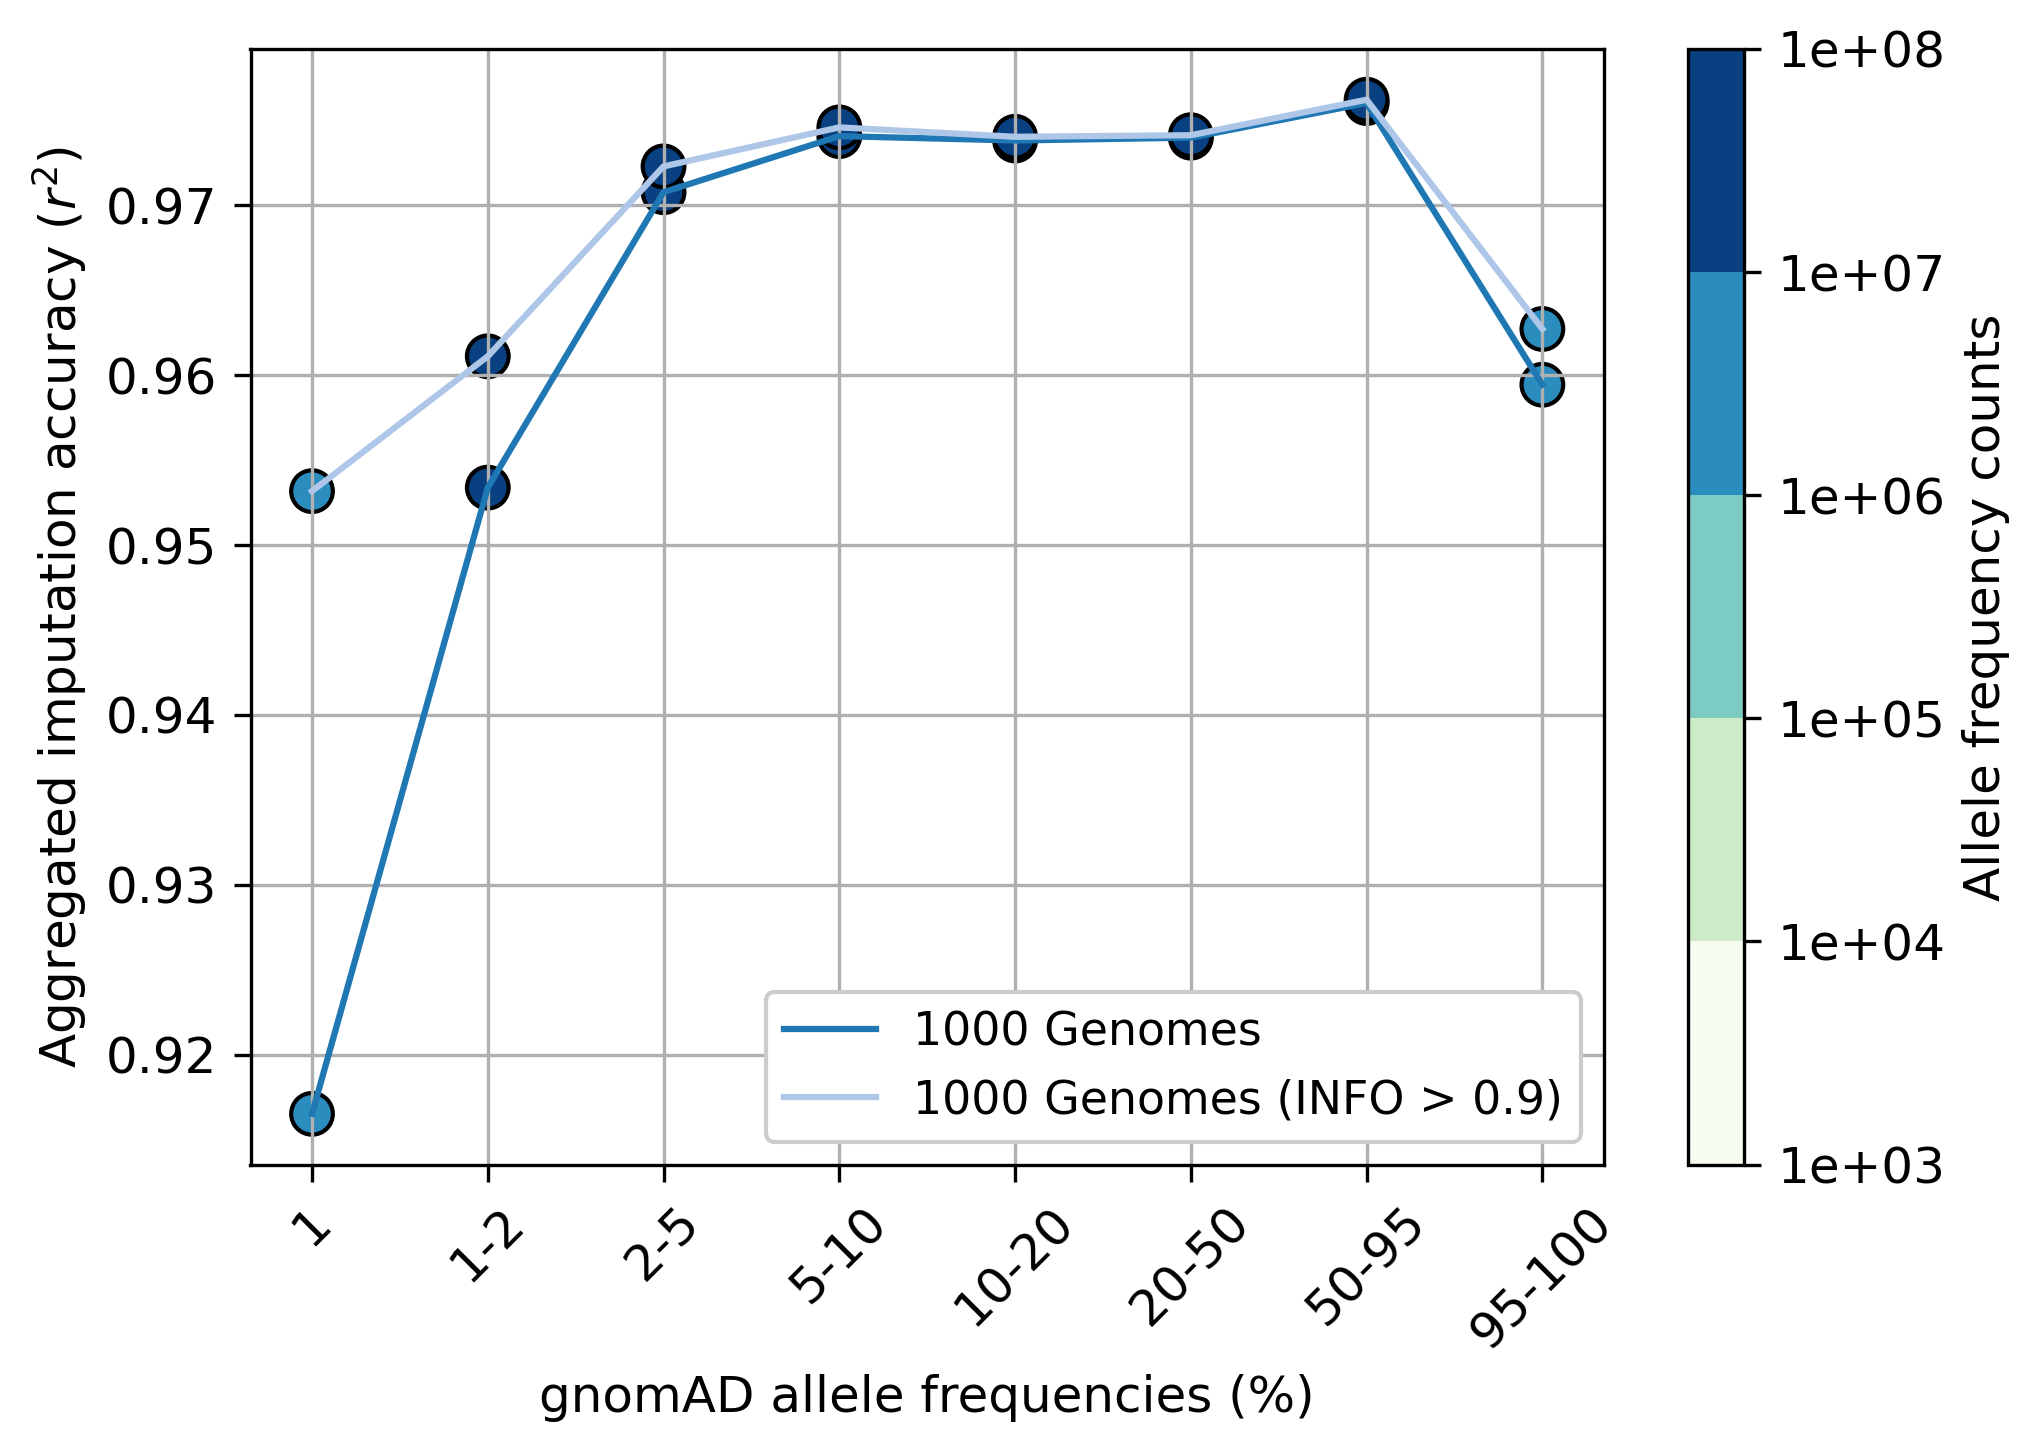

In [60]:
ix = [0, 1]
labels = ['1000 Genomes', '1000 Genomes (INFO > 0.9)']
title = ''
t = 0.01

save_fig = True
impacc_lst = [impaccs[i] for i in ix]
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'f1a.png'
metric = 'r2'
colorbar_cmap=COLORBAR_CMAP
line_colors=CATEGORY_CMAP_HEX

cols = ['AF', metric, metric + '_AC']

df_lst = [impacc[cols] for impacc in impacc_lst]

fig = plt.figure(figsize=(7, 5), dpi = 300)
ax = fig.add_subplot(111)

magnitude = 5
bounds = np.logspace(3, 8, magnitude + 1)
norm = mcolors.BoundaryNorm(bounds, colorbar_cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

for i in range(len(df_lst)):
    triplet = df_lst[i]
    triplet = triplet[triplet['AF'] >= t]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = lcwgsus.generate_af_axis(triplet[c0].values)
    vals = triplet[c1]
    allele_counts = triplet[c2]

    plt.plot(x, vals, label=label, c = line_colors[i])
    plt.xticks(x, afs, rotation=45)

    im = ax.scatter(x,
                    vals,
                    c=allele_counts,
                    edgecolor='black',
                    cmap=colorbar_cmap,
                    norm=norm,
                    s=100)

plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            format=FuncFormatter(fmt),
            label='Allele frequency counts')

plt.xlabel('gnomAD allele frequencies (%)')

legend = ax.legend(
    loc = 'lower right',
    framealpha=1,
    prop={'size': 11}
)

legend.get_title().set_fontsize(11)

plt.ylabel('Aggregated imputation accuracy ($r^2$)')
ax.grid()
fig.tight_layout()

lcwgsus.save_figure(save_fig, outdir, save_name)

## F1b

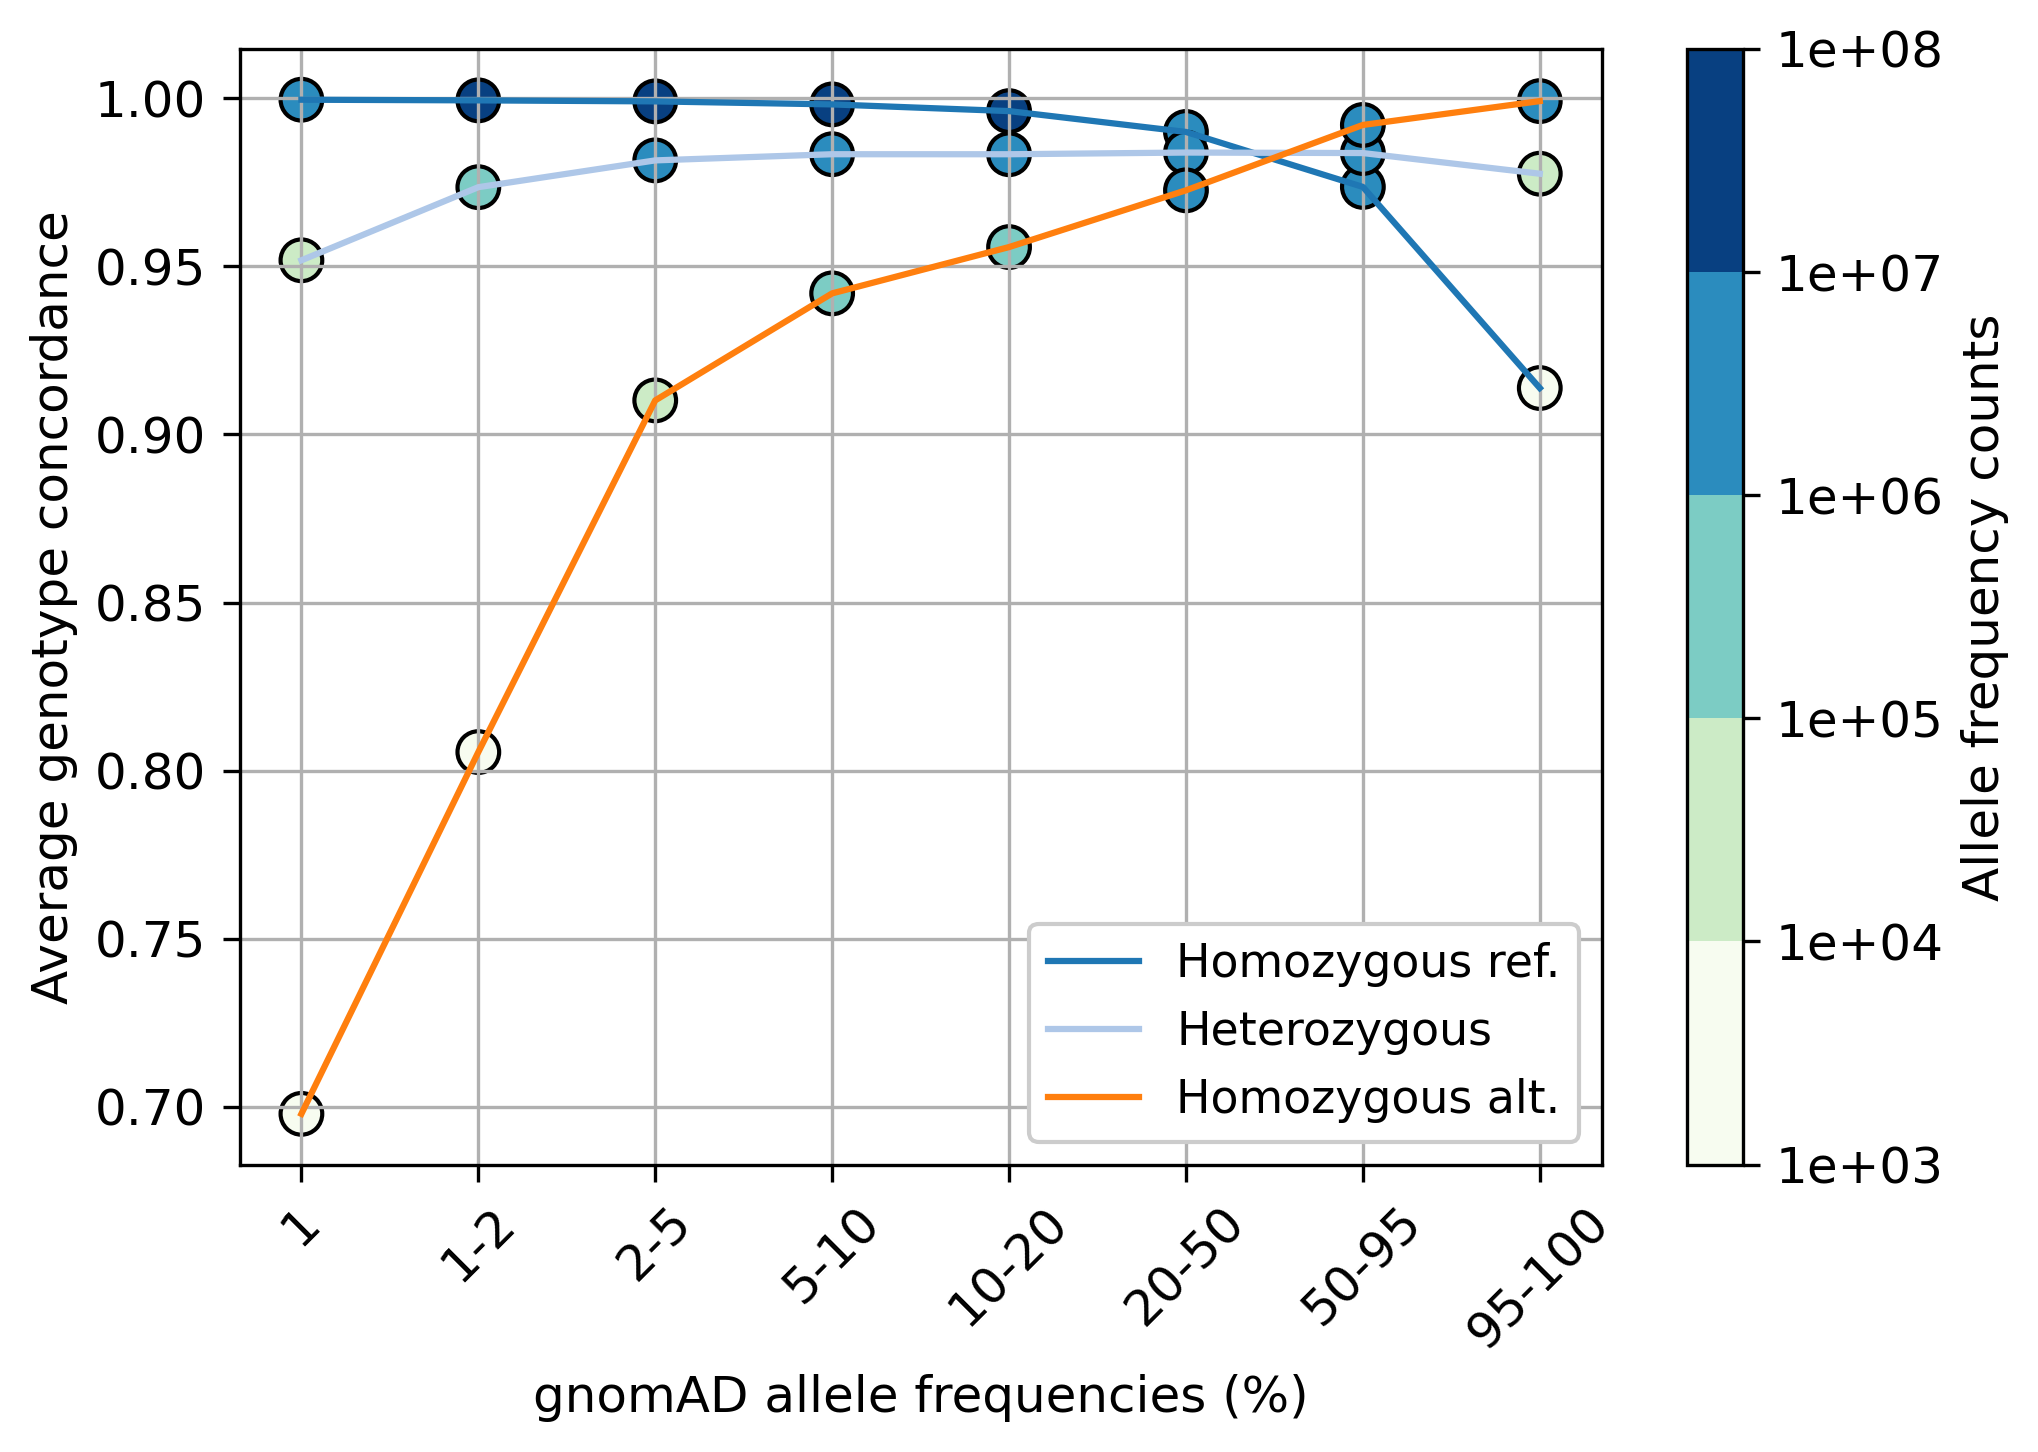

In [61]:
save_fig = True
impacc = impacc_lst[0]
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'f1b.png'
metrics = ['ccd_homref', 'ccd_het', 'ccd_homalt']
colorbar_cmap=COLORBAR_CMAP
line_colors=CATEGORY_CMAP_HEX
threshold = t
marker_size = 100
labels = ['Homozygous ref.', 'Heterozygous', 'Homozygous alt.']

fig = plt.figure(figsize=(7, 5), dpi = 300)
ax = fig.add_subplot(111)
plt.grid(False)

magnitude = 5
bounds = np.logspace(3, 8, magnitude + 1)
norm = mcolors.BoundaryNorm(bounds, colorbar_cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

for i, m in enumerate(metrics):
    cols = ['AF', m, m + '_AC']
    triplet = impacc[cols]
    if threshold is not None:
        triplet = triplet[triplet['AF'] >= threshold]
    c0, c1, c2 = tuple(list(triplet.columns))
    label = labels[i]

    x = np.arange(triplet.shape[0])
    afs = lcwgsus.generate_af_axis(triplet[c0].values)
    vals = triplet[c1]
    allele_counts = triplet[c2]

    plt.plot(x, vals, label=label, c=line_colors[i])
    plt.xticks(x, afs, rotation=45)

    im = ax.scatter(x,
                    vals,
                    c=allele_counts,
                    edgecolor='black',
                    cmap=colorbar_cmap,
                    norm=norm,
                    s=marker_size)

plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            format=FuncFormatter(fmt),
            label='Allele frequency counts')

plt.xlabel('gnomAD allele frequencies (%)')
plt.title(title)
legend = ax.legend(
    loc = 'lower right',
    framealpha=1,
    prop={'size': 11}
)

legend.get_title().set_fontsize(11)
plt.ylabel('Average genotype concordance')

ax.grid()
fig.tight_layout()

lcwgsus.save_figure(save_fig, outdir, save_name)

# F2 lc-mGen increases imputation accuracy

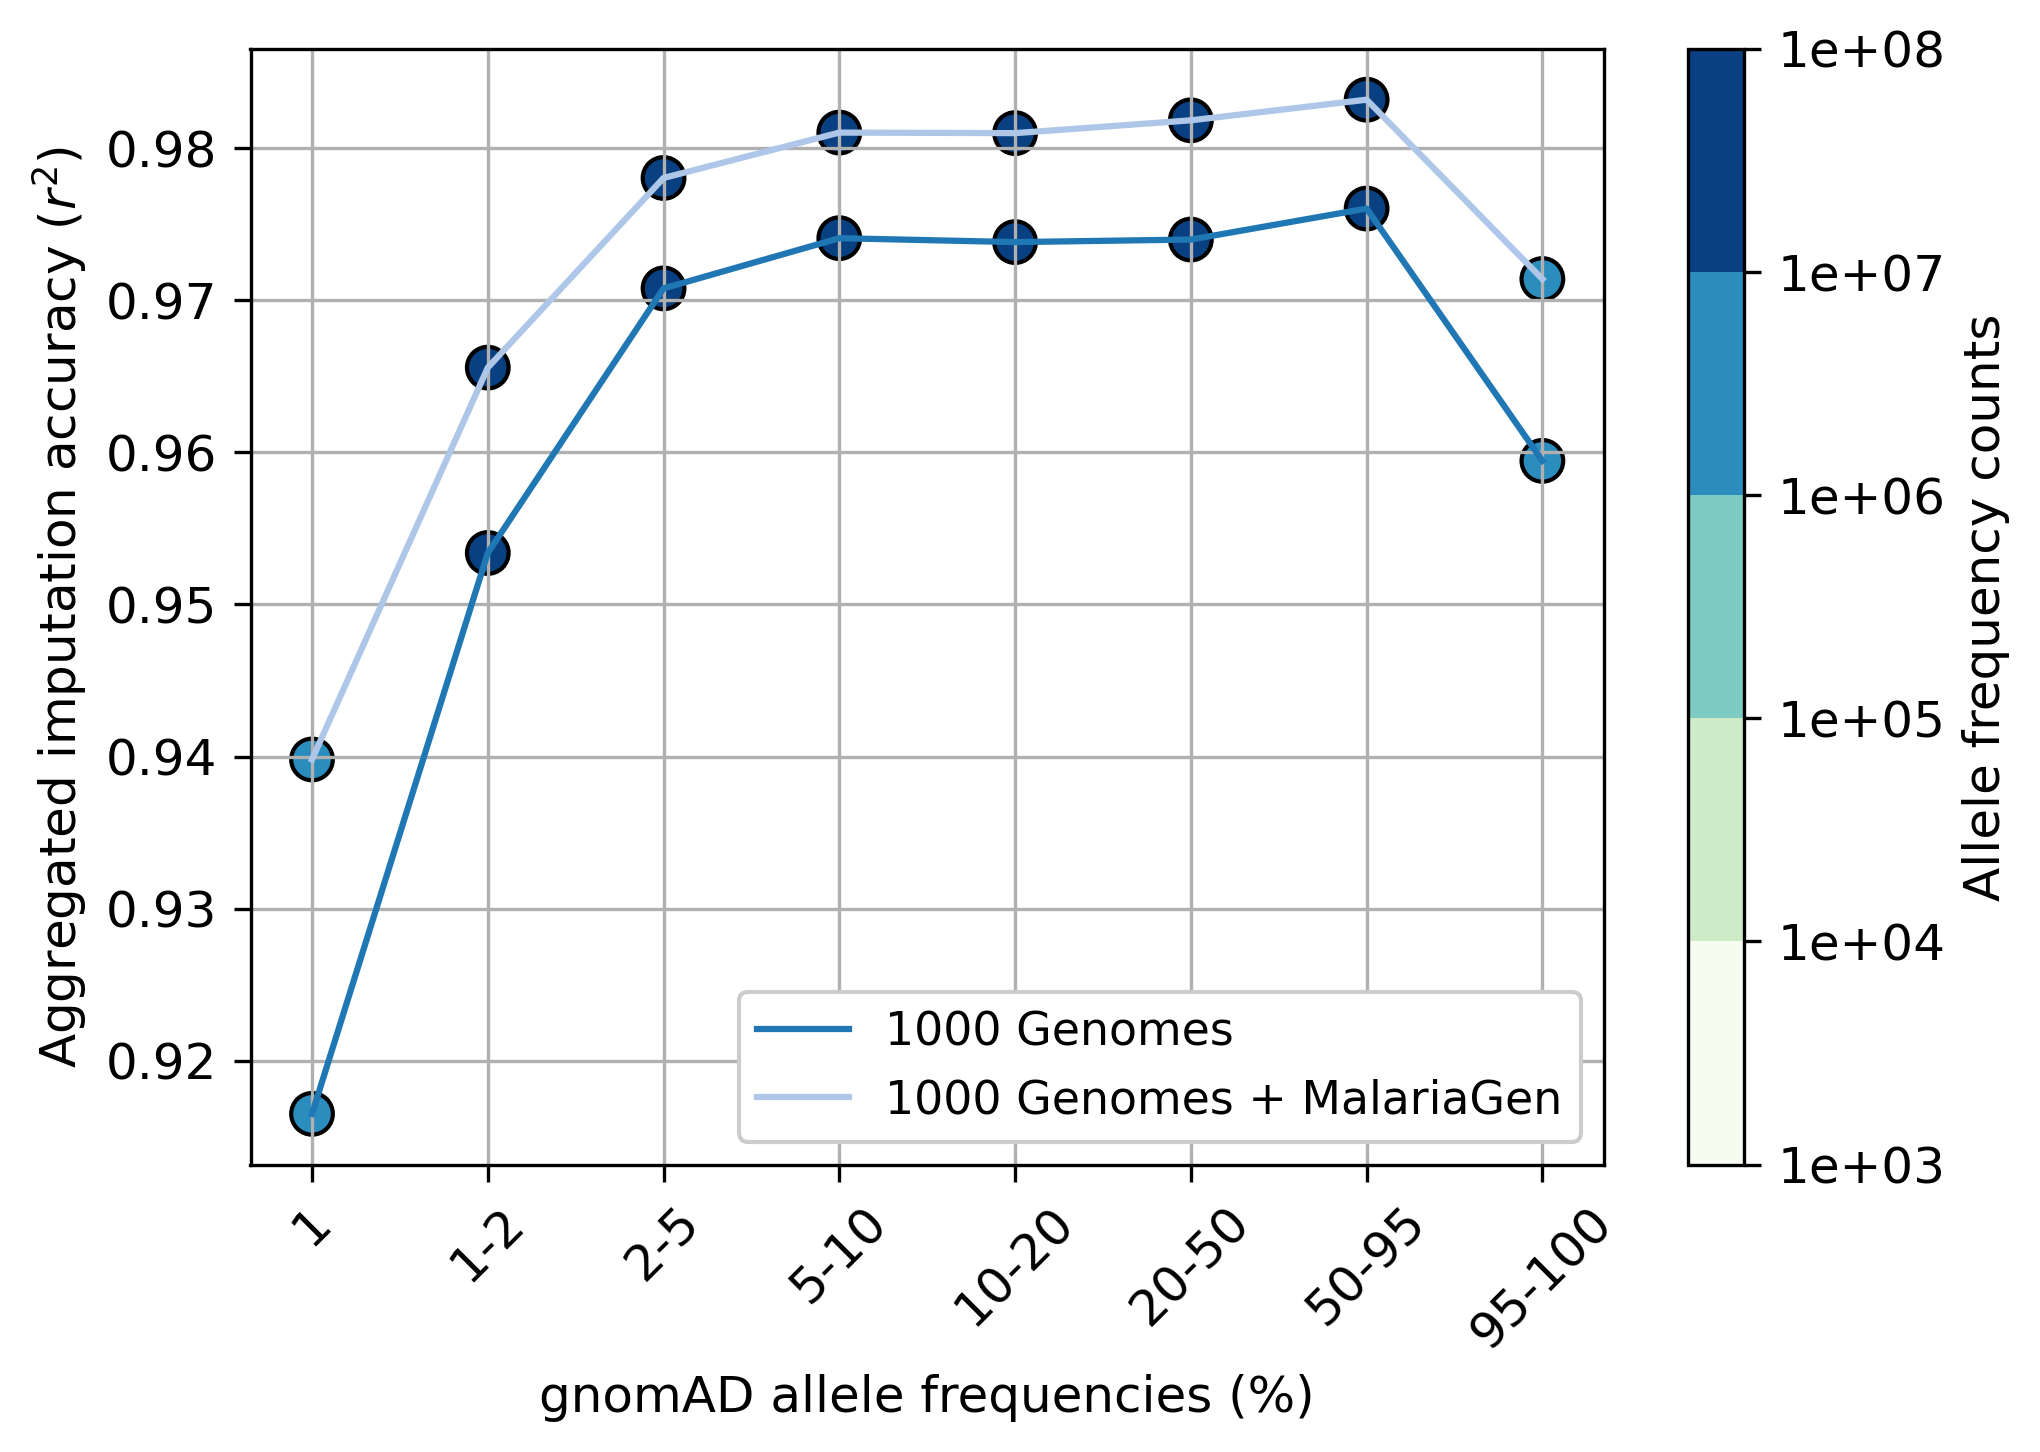

In [62]:
impaccs = []
for d in imp_dirs:
    v = pd.read_csv(d + "impacc/all_samples/by_sample/all.v.impacc.tsv", sep = '\t')
    impaccs.append(v)

ix = [0, 12]
labels = ['1000 Genomes', '1000 Genomes + MalariaGen']
title = ''
t = 0.01

save_fig = True
impacc_lst = [impaccs[i] for i in ix]
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'f2.png'
metric = 'r2'
colorbar_cmap=COLORBAR_CMAP
line_colors=CATEGORY_CMAP_HEX

cols = ['AF', metric, metric + '_AC']

df_lst = [impacc[cols] for impacc in impacc_lst]

fig = plt.figure(figsize=(7, 5), dpi = 300)
ax = fig.add_subplot(111)

magnitude = 5
bounds = np.logspace(3, 8, magnitude + 1)
norm = mcolors.BoundaryNorm(bounds, colorbar_cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

for i in range(len(df_lst)):
    triplet = df_lst[i]
    triplet = triplet[triplet['AF'] >= t]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = lcwgsus.generate_af_axis(triplet[c0].values)
    vals = triplet[c1]
    allele_counts = triplet[c2]

    plt.plot(x, vals, label=label, c = line_colors[i])
    plt.xticks(x, afs, rotation=45)

    im = ax.scatter(x,
                    vals,
                    c=allele_counts,
                    edgecolor='black',
                    cmap=colorbar_cmap,
                    norm=norm,
                    s=100)

plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            format=FuncFormatter(fmt),
            label='Allele frequency counts')

plt.xlabel('gnomAD allele frequencies (%)')

legend = ax.legend(
    loc = 'lower right',
    framealpha=1,
    prop={'size': 11}
)

legend.get_title().set_fontsize(11)
plt.ylabel('Aggregated imputation accuracy ($r^2$)')
ax.grid()
fig.tight_layout()

lcwgsus.save_figure(save_fig, outdir, save_name)

# F3 Two-stage imputation

## F3a

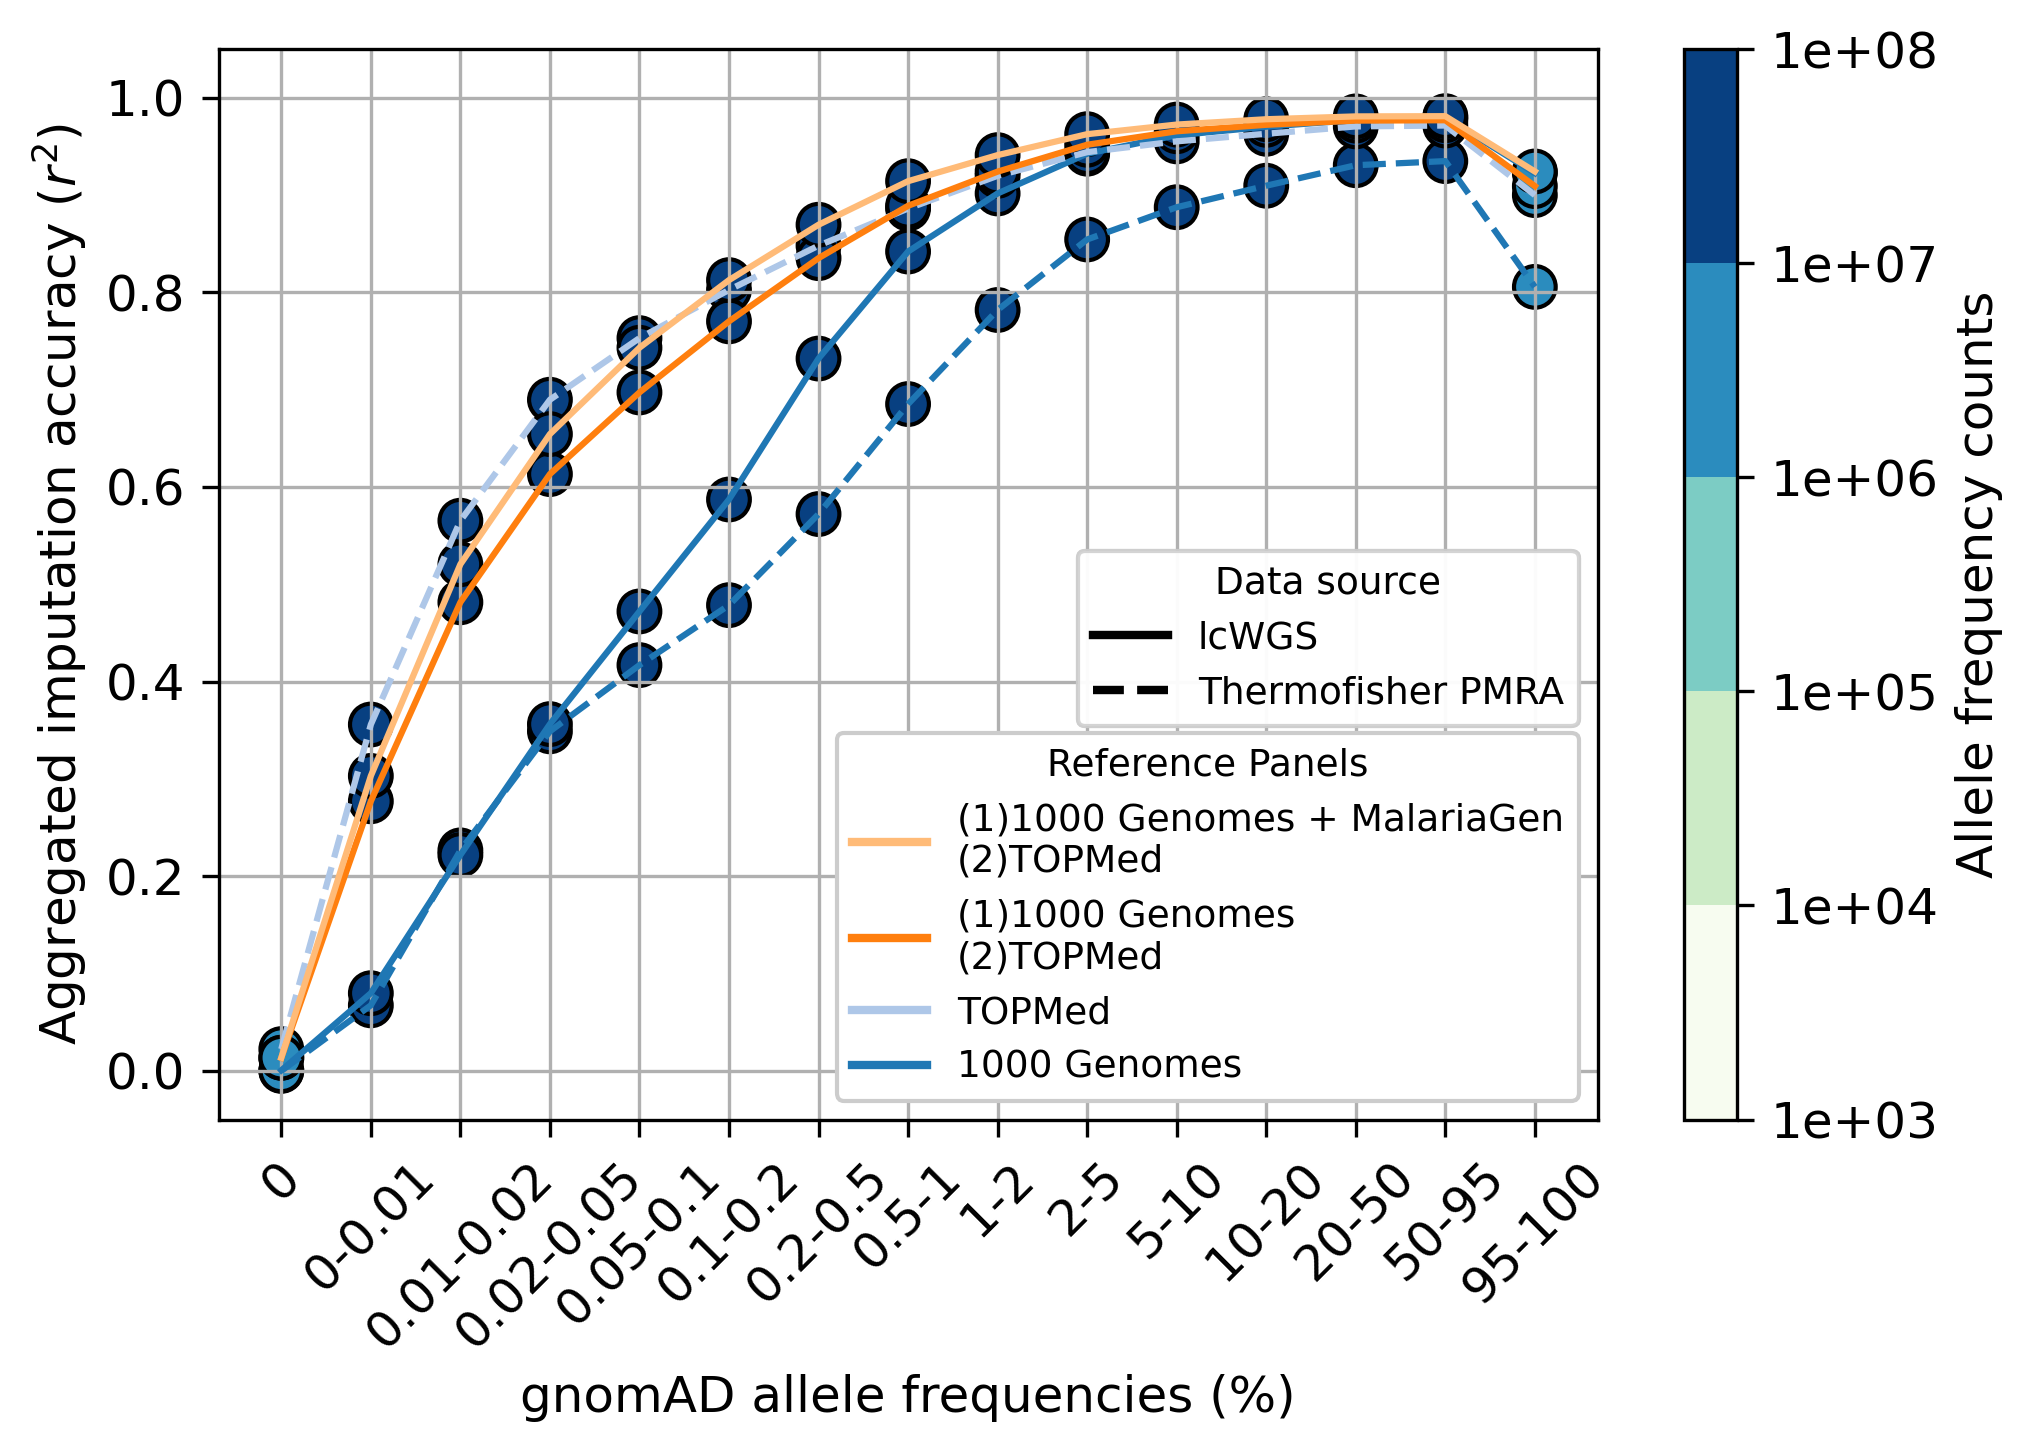

In [56]:
impaccs = []
for d in imp_dirs:
    v = pd.read_csv(d + "/impacc/all_samples/by_sample/all.v.impacc.tsv", sep = '\t')
    impaccs.append(v)

ix = [2, 3, 4, 6, 10]
impacc_lst = [impaccs[i] for i in ix]
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'f3a.png'

colorbar_cmap=COLORBAR_CMAP
line_colors=CATEGORY_CMAP_HEX

style = ['--', '-', '--', '-', '-']
colors = [line_colors[i] for i in [0,0,1,2,3]]

metric='r2'
marker_size=100
colorbar_cmap=COLORBAR_CMAP
line_colors=CATEGORY_CMAP_HEX

cols = ['AF', metric, metric + '_AC']
df_lst = [impacc[cols] for impacc in impacc_lst]

fig1 = plt.figure(figsize=(7,5), dpi = 300)
ax = fig1.add_subplot(111)

magnitude = 5
bounds = np.logspace(3, 8, magnitude + 1)
norm = mcolors.BoundaryNorm(bounds, colorbar_cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

threshold = None
set_ylim = True
subplot = False

for i in range(len(df_lst)):
    triplet = df_lst[i]
    if threshold is not None:
        triplet = triplet[triplet['AF'] >= threshold]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = lcwgsus.generate_af_axis(triplet[c0].values)
    vals = triplet[c1]
    allele_counts = triplet[c2]

    plt.plot(x, vals, c = colors[i], linestyle = style[i], zorder = 2)
    if set_ylim:
        plt.ylim((-0.05, 1.05))
    if not subplot:
        plt.xticks(x, afs, rotation=45)
    else:
        ax.set_xticks(x, ['' for _ in afs])

    im = ax.scatter(x,
                    vals,
                    c=allele_counts,
                    edgecolor='black',
                    cmap=colorbar_cmap,
                    norm=norm,
                    s=marker_size)
if not subplot:
    plt.colorbar(im,
                boundaries=bounds,
                ticks=bounds,
                format=FuncFormatter(fmt),
                label='Allele frequency counts')

    plt.xlabel('gnomAD allele frequencies (%)')
    
    color_handles = [
        Line2D([0], [0], color=line_colors[0], lw=2, label='1000 Genomes'),
        Line2D([0], [0], color=line_colors[1], lw=2, label='TOPMed'),
        Line2D([0], [0], color=line_colors[2], lw=2, label='(1)1000 Genomes\n(2)TOPMed'),
        Line2D([0], [0], color=line_colors[3], lw=2, label='(1)1000 Genomes + MalariaGen\n(2)TOPMed'),
    ][::-1]

    legend1 = plt.legend(handles=color_handles, title='Reference Panels', loc='lower right', prop={'size': 9}, framealpha=1)
    legend1.get_title().set_fontsize(9)
    plt.gca().add_artist(legend1)
    legend1.get_frame().set_zorder(1)

    linestyle_handles = [
        Line2D([0], [0], color='black', lw=2, linestyle='-', label='lcWGS'),
        Line2D([0], [0], color='black', lw=2, linestyle='--', label='Thermofisher PMRA')
    ]
    legend2 = plt.legend(handles=linestyle_handles, title='Data source', loc='lower right', prop={'size': 9}, bbox_to_anchor=(1, 0.35))
    legend2.get_title().set_fontsize(9)
    plt.gca().add_artist(legend2)   
    legend2.get_frame().set_zorder(2)

    plt.ylabel('Aggregated imputation accuracy ($r^2$)')
ax.grid()
fig1.tight_layout()

lcwgsus.save_figure(save_fig, outdir, save_name)

## F3b

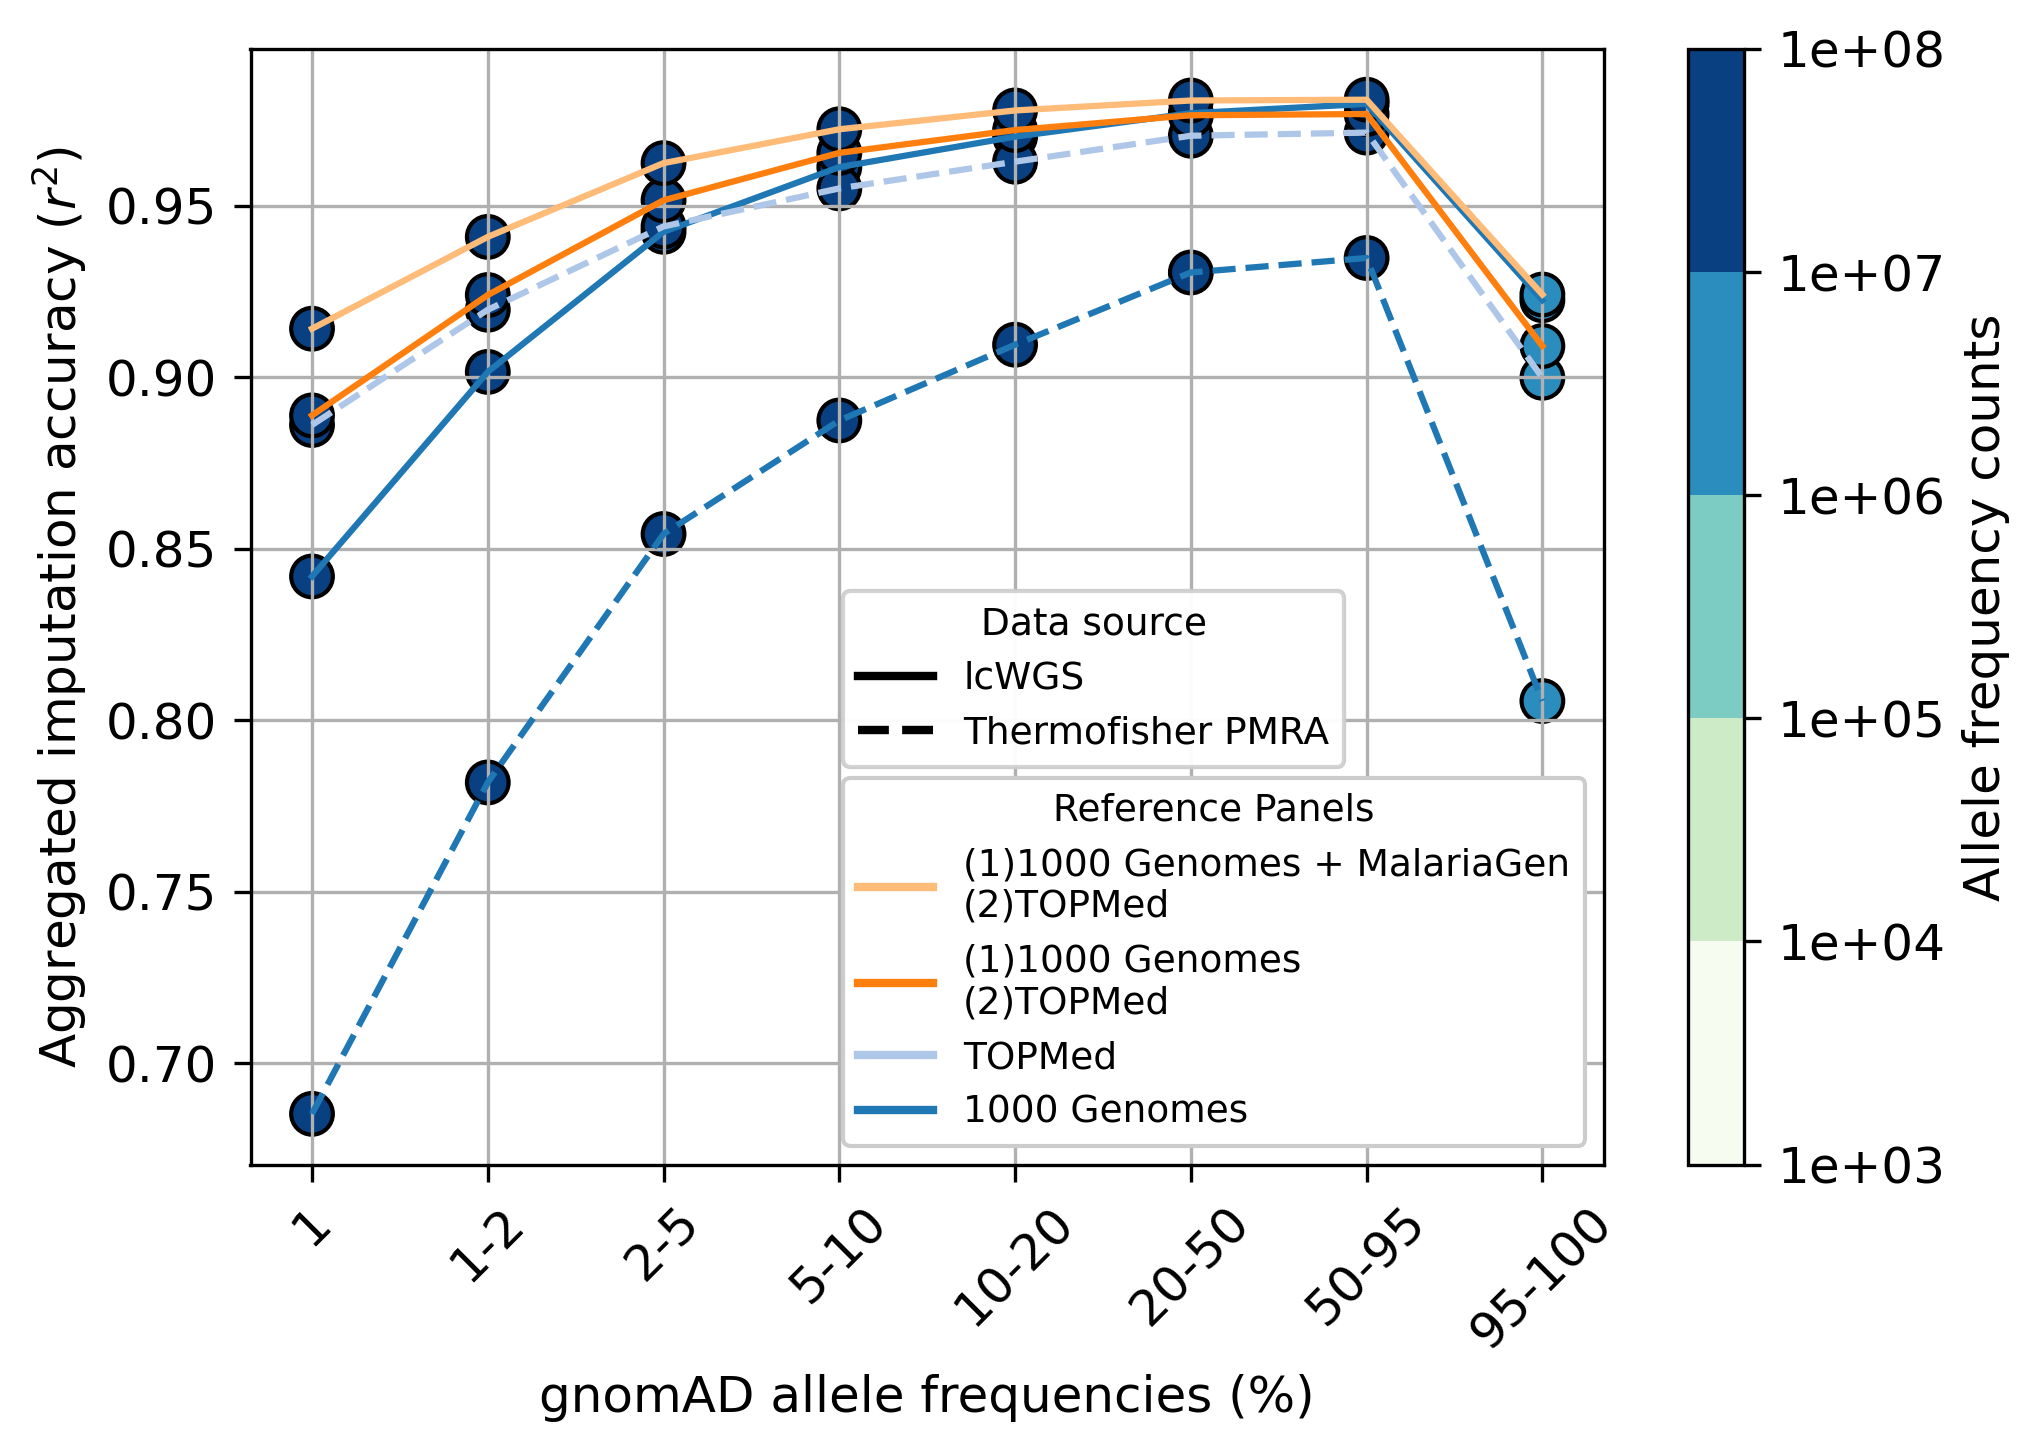

In [57]:
impaccs = []
for d in imp_dirs:
    v = pd.read_csv(d + "/impacc/all_samples/by_sample/all.v.impacc.tsv", sep = '\t')
    impaccs.append(v)

ix = [2, 3, 4, 6, 10]
impacc_lst = [impaccs[i] for i in ix]
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'f3b.png'

colorbar_cmap=COLORBAR_CMAP
line_colors=CATEGORY_CMAP_HEX

style = ['--', '-', '--', '-', '-']
colors = [line_colors[i] for i in [0,0,1,2,3]]

metric='r2'
marker_size=100
colorbar_cmap=COLORBAR_CMAP
line_colors=CATEGORY_CMAP_HEX

cols = ['AF', metric, metric + '_AC']
df_lst = [impacc[cols] for impacc in impacc_lst]

fig1 = plt.figure(figsize=(7,5), dpi = 300)
ax = fig1.add_subplot(111)

magnitude = 5
bounds = np.logspace(3, 8, magnitude + 1)
norm = mcolors.BoundaryNorm(bounds, colorbar_cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

threshold = 0.01
set_ylim = False
subplot = False

for i in range(len(df_lst)):
    triplet = df_lst[i]
    if threshold is not None:
        triplet = triplet[triplet['AF'] >= threshold]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = lcwgsus.generate_af_axis(triplet[c0].values)
    vals = triplet[c1]
    allele_counts = triplet[c2]

    plt.plot(x, vals, c = colors[i], linestyle = style[i], zorder = 2)
    if set_ylim:
        plt.ylim((-0.05, 1.05))
    if not subplot:
        plt.xticks(x, afs, rotation=45)
    else:
        ax.set_xticks(x, ['' for _ in afs])

    im = ax.scatter(x,
                    vals,
                    c=allele_counts,
                    edgecolor='black',
                    cmap=colorbar_cmap,
                    norm=norm,
                    s=marker_size)
if not subplot:
    plt.colorbar(im,
                boundaries=bounds,
                ticks=bounds,
                format=FuncFormatter(fmt),
                label='Allele frequency counts')

    plt.xlabel('gnomAD allele frequencies (%)')
    
    color_handles = [
        Line2D([0], [0], color=line_colors[0], lw=2, label='1000 Genomes'),
        Line2D([0], [0], color=line_colors[1], lw=2, label='TOPMed'),
        Line2D([0], [0], color=line_colors[2], lw=2, label='(1)1000 Genomes\n(2)TOPMed'),
        Line2D([0], [0], color=line_colors[3], lw=2, label='(1)1000 Genomes + MalariaGen\n(2)TOPMed'),
    ][::-1]

    legend1 = plt.legend(handles=color_handles, title='Reference Panels', loc='lower right', prop={'size': 9}, framealpha=1)
    legend1.get_title().set_fontsize(9)
    plt.gca().add_artist(legend1)
    legend1.get_frame().set_zorder(1)

    linestyle_handles = [
        Line2D([0], [0], color='black', lw=2, linestyle='-', label='lcWGS'),
        Line2D([0], [0], color='black', lw=2, linestyle='--', label='Thermofisher PMRA')
    ]
    legend2 = plt.legend(handles=linestyle_handles, title='Data source', loc='lower right', prop={'size': 9}, bbox_to_anchor=(0.822, 0.34))
    legend2.get_title().set_fontsize(9)
    plt.gca().add_artist(legend2)   
    legend2.get_frame().set_zorder(2)

    plt.ylabel('Aggregated imputation accuracy ($r^2$)')
ax.grid()
fig1.tight_layout()

lcwgsus.save_figure(save_fig, outdir, save_name)

# F4 Blood group variants

In [3]:
genes = pd.read_csv('data/blood_group_variants/blood_group_genes.tsv', sep = '\t', index_col = False)
genes = genes[genes['Chromosome'] != 'X'].reset_index(drop = True)
genes = genes.iloc[:,[1,2,3,0]]
genes.columns = ['chr', 'start', 'end', 'gene']
genes['chr'] = genes['chr'].astype(int)

variants = pd.read_csv('data/blood_group_variants/blood_group_variants.tsv', sep = '\t', index_col = False)

imp_dir = f'{imp_dirs[10]}impacc/all_samples/by_variant/'
hs = []
for i in CHROMOSOMES_ALL:
    t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
    hs.append(t)
h = pd.concat(hs)
h = h[h['r2'] != -9]

# af_files = [f'data/gnomAD_MAFs/afr/gnomAD_MAF_afr_chr{i}.txt' for i in CHROMOSOMES_ALL]
# af = lcwgsus.multi_read_af_chunks(af_files, ncores = 4) 

## F4a: blood group r2 (N=8)

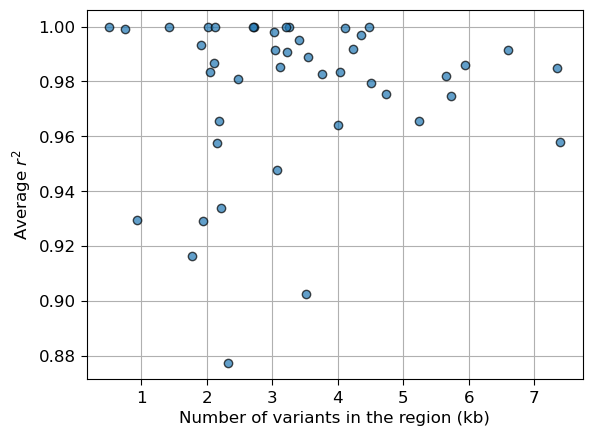

In [15]:
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'f4a.png'

threshold = 0.01

region = genes.copy()

region.loc[len(region)] = [11, 5227002, 5227002, 'rs334']
region.loc[len(region)] = [11, 5227003, 5227003, 'rs33930165']
region.loc[len(region)] = [9, 133257521, 133257521, 'rs8176719']
region.loc[len(region)] = [8, 697972, 697972, 'rs1075451']

region['r2'] = 0
region['n_variants'] = 0
region['rho_variants'] = 0 # Density
for i in range(len(genes)):
    c,s,e,t = region.iloc[i, :4]
    tmp = h[h['chr'] == c]
    tmp = tmp[tmp['MAF'] >= threshold]
    tmp = tmp[tmp['r2'] != -9]

    df = tmp[(tmp['pos'] <= e) & (tmp['pos'] >= s)]
    if len(df) == 0:
        pass
    else:
        region.loc[i, 'r2'] = df['r2'].mean()
        region.loc[i, 'n_variants'] = len(df)
        region.loc[i, 'rho_variants'] = 1000*len(df)/(e-s)
        
region_non_empty = region[region['n_variants'] != 0]

plt.scatter(region_non_empty['rho_variants'], region_non_empty['r2'], marker = 'o', ec = 'black', alpha = 0.7, zorder = 2)
plt.xlabel('Number of variants in the region (kb)')
plt.ylabel('Average $r^2$')
plt.grid(True, zorder = 1)
plt.title('')
# FUT3 and AQP1

lcwgsus.save_figure(save_fig, outdir, save_name)

## F4b: PieChart

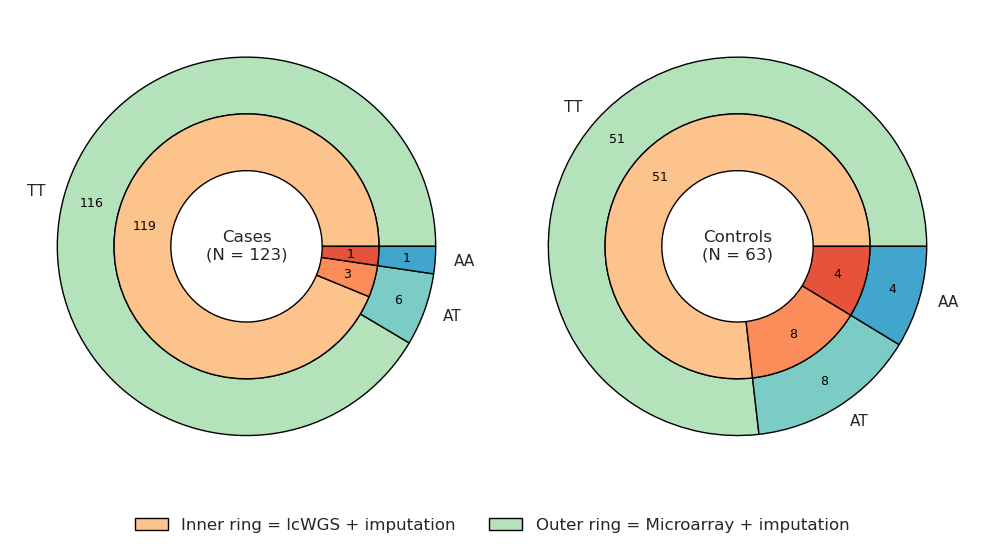

In [158]:
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'f4b.png'

def get_genotype(stat, source):
    sumstat_chip = pd.read_csv(stat, sep = '\t', comment = '#')
    annot_chip = sumstat_chip[(sumstat_chip['chromosome'] == 'chr11') & (sumstat_chip['position'] == 5227002)]
    c0 = int(np.round(annot_chip.T.loc['cases_AA'].values[0])) + 2
    c1 = int(np.round(annot_chip.T.loc['cases_AB'].values[0])) + 2
    c2 = int(np.round(annot_chip.T.loc['cases_BB'].values[0])) + 2
    
    ct0 = int(np.round(annot_chip.T.loc['controls_AA'].values[0])) + 2
    ct1 = int(np.round(annot_chip.T.loc['controls_AB'].values[0])) + 2
    ct2 = int(np.round(annot_chip.T.loc['controls_BB'].values[0])) + 2
    gen = ['TT']*c0 + ['AT']*c1 + ['AA']*c2 + ['TT']*ct0 + ['AT']*ct1 + ['AA']*ct2
    phe = [1]*(c0+c1+c2) + [0]*(ct0+ct1+ct2)
                              
    df = pd.DataFrame({'Genotype': gen, 'Malaria': phe})
    df['Source'] = source
    return c0, c1, c2, ct0, ct1, ct2

v1 = get_genotype('results/gwas/mGenv1_topmed/lr1/chip/results/stats.out', 'chip')
v2 = get_genotype('results/gwas/mGenv1_topmed/lr1/lc/results/stats.out', 'lc')

genotypes = ['TT', 'AT', 'AA']

cases_A = np.array(list(v1[:3]))
ctrls_A = np.array(list(v1[3:]))
cases_B = np.array(list(v2[:3]))
ctrls_B = np.array(list(v2[3:]))

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

num_colors = 7
colors1 = plt.cm.GnBu(np.linspace(0, 1, num_colors))[2:5]
colors2 = plt.cm.OrRd(np.linspace(0, 1, num_colors))[2:5]

def add_labels(patches, values, ax, radius):
    for p, val in zip(patches, values - 2):
        angle = (p.theta2 + p.theta1) / 2
        rad = np.deg2rad(angle)
        # Slightly inside the outer edge of the wedge
        x = (radius - 0.15) * np.cos(rad)
        y = (radius - 0.15) * np.sin(rad)
        ax.text(x, y, str(val), ha='center', va='center', fontsize=9, color='black')


patches_outer, _ = axes[0].pie(cases_B, radius=1, labels=genotypes, labeldistance=1.1,
                               colors=colors1, wedgeprops=dict(width=0.3, edgecolor='black'))
patches_inner, _ = axes[0].pie(cases_A, radius=0.7,
                               colors=colors2, wedgeprops=dict(width=0.3, edgecolor='black'))

axes[0].text(0, 0, f'Cases\n(N = {sum(cases_A-2)})', ha='center', va='center', fontsize=12)
add_labels(patches_outer, cases_B, axes[0], radius=1)
add_labels(patches_inner, cases_A, axes[0], radius=0.7)

patches_outer, _ = axes[1].pie(ctrls_B, radius=1, labels=genotypes, labeldistance=1.1,
                               colors=colors1, wedgeprops=dict(width=0.3, edgecolor='black'))
patches_inner, _ = axes[1].pie(ctrls_A, radius=0.7,
                               colors=colors2, wedgeprops=dict(width=0.3, edgecolor='black'))

axes[1].text(0, 0, f'Controls\n(N = {sum(ctrls_A-2)})', ha='center', va='center', fontsize=12)
add_labels(patches_outer, ctrls_B, axes[1], radius=1)
add_labels(patches_inner, ctrls_A, axes[1], radius=0.7)

plt.tight_layout()



# Add this before plt.show()
legend_elements = [
    Patch(facecolor=colors2[0], edgecolor='black', label='Inner ring = microarray typed'),
    Patch(facecolor=colors1[0], edgecolor='black', label='Outer ring = lcWGS + imputation')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, frameon=False, fontsize=12)
lcwgsus.save_figure(save_fig, outdir, save_name)

In [143]:
# fig, ax = plt.subplots(figsize=(7, 5), dpi = 300)
# offset = 0.1
# xaxis = np.arange(3)

# v1_cases = list(v1[:3])
# v1_controls = list(v1[3:])
# v2_cases = list(v2[:3])
# v2_controls = list(v2[3:])

# colors = plt.get_cmap(CATEGORY_CMAP_STR).colors[:2]
# c = [mcolors.to_hex(c) for c in colors]

# p = ax.bar(xaxis - offset, v1_cases, width = offset*2, color = c[0])
# ax.bar_label(p, label_type='center')
# p = ax.bar(xaxis - offset, v1_controls, width = offset*2, bottom = v1_cases, color = c[1])
# ax.bar_label(p, label_type='center')
# p = ax.bar(xaxis + offset, v2_cases, width = offset*2, color = c[0])
# ax.bar_label(p, label_type='center')
# p = ax.bar(xaxis + offset, v2_controls, width = offset*2, bottom = v2_cases, color = c[1])
# ax.bar_label(p, label_type='center')


## F4c: Forest plot

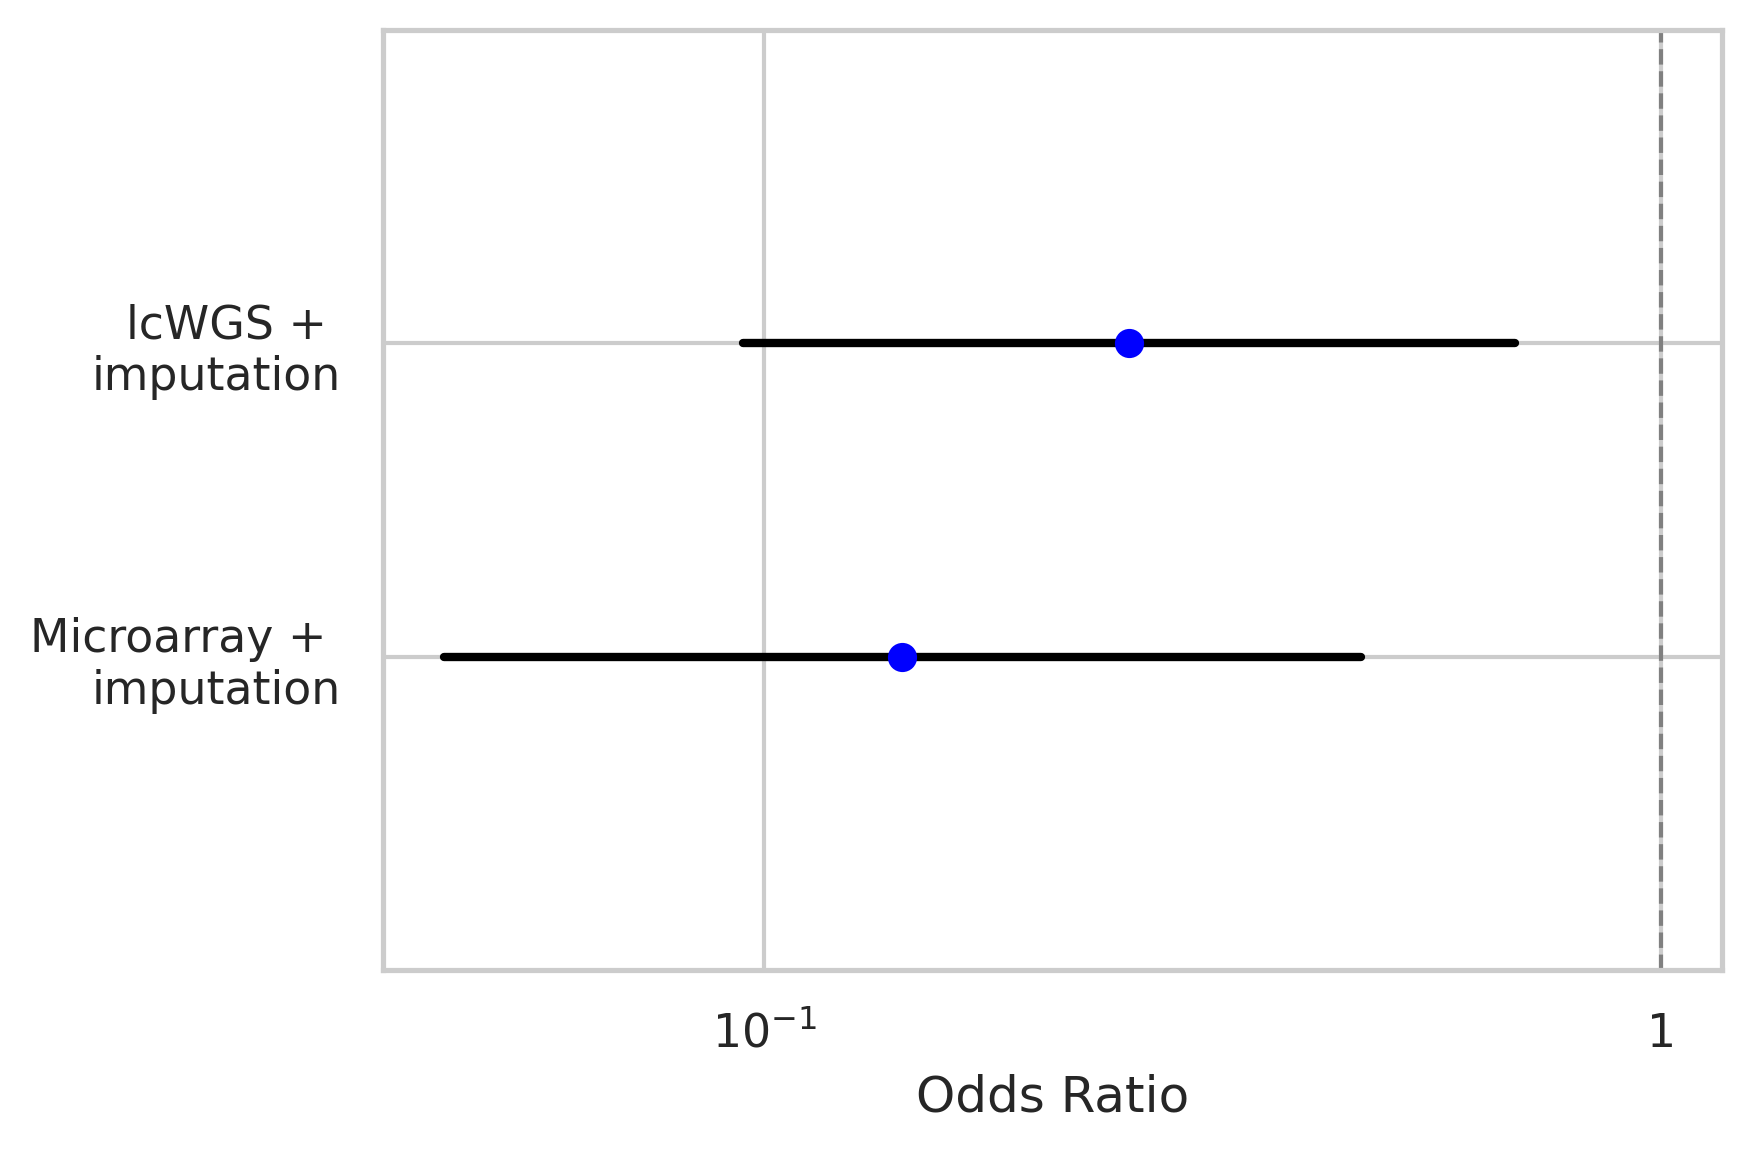

In [156]:
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'f4c.png'

studies = ['lcWGS + \nimputation', 'Microarray + \nimputation']

annot_chip = pd.read_csv('results/gwas/mGenv1_topmed/lr1/chip/results/stats.out', sep = '\t', comment = '#')
annot_lc = pd.read_csv('results/gwas/mGenv1_topmed/lr1/lc/results/stats.out', sep = '\t', comment = '#')

beta_lc = annot_lc[annot_lc['rsid'] == 'rs334']['frequentist_dom_beta_1:dom/malaria=1'].values[0]
se_lc = annot_lc[annot_lc['rsid'] == 'rs334']['frequentist_dom_se_1'].values[0]
beta_chip = annot_chip[annot_chip['rsid'] == 'rs334']['frequentist_dom_beta_1:dom/malaria=1'].values[0]
se_chip = annot_chip[annot_chip['rsid'] == 'rs334']['frequentist_dom_se_1'].values[0]
z = 1.96 

effect_sizes = [np.exp(beta_lc), np.exp(beta_chip)]
conf_intervals = [(np.exp(beta_lc + z * se_lc), np.exp(beta_lc - z * se_lc)), 
                  (np.exp(beta_chip + z * se_chip), np.exp(beta_chip - z * se_chip))]

fig, ax = plt.subplots(figsize=(6, 4), dpi = 300)
for i, (effect, (ci_low, ci_high)) in enumerate(zip(effect_sizes, conf_intervals)):
    ax.plot([ci_low, ci_high], [i, i], color='black', linestyle='-', lw=2)
    ax.scatter(effect, i, color='blue', zorder=3)

# Add labels
ax.set_yticks(range(len(studies)))
ax.set_yticklabels(studies)
ax.axvline(1, color='gray', linestyle='--', lw=1)
ax.set_xlabel('Odds Ratio')
ax.set_xscale('log')
ax.set_ylim((-1,2))
ax.set_xticks([0.1, 1], ['$10^{-1}$', '1'])

plt.gca().invert_yaxis()  
plt.tight_layout()

lcwgsus.save_figure(save_fig, outdir, save_name)

# F5 QUILT-HLA imputation accuracy by gene

## F5a: Accuracy

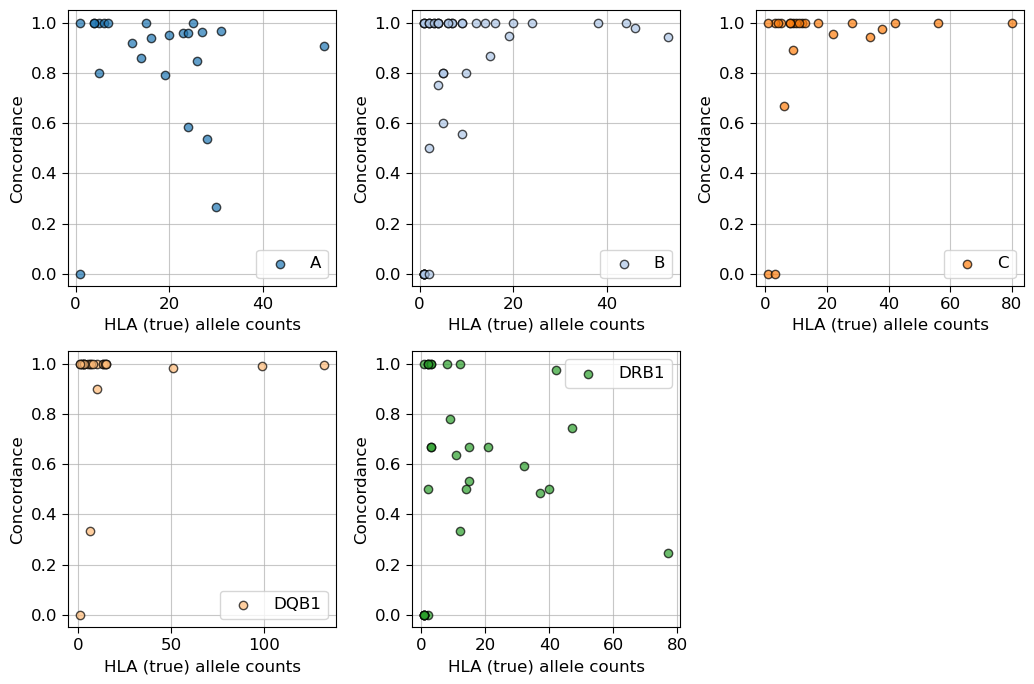

In [63]:
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'f5a.png'
title = ''

hla_dir = '/well/band/users/rbx225/GAMCC/results/hla/imputation/QUILT_HLA_result_db/'
hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv')
lc = lcwgsus.read_hla_lc_imputation_results(hla_dir, retain = 'fv')

ccd_dict_lc = lcwgsus.compare_hla_types_by_type(hla, lc)
ccd_dict_lc = lcwgsus.calculate_hla_concordance_by_type(ccd_dict_lc, verbose = False)
    
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10.5, 7))
axes = axes.flatten()

for i, l in enumerate(HLA_GENES):
    ax = axes[i]
    ax.grid(True, alpha = 0.7, zorder = 2)
    df = ccd_dict_lc[l]
    ax.scatter(df['Sum'], df['Accuracy'], c = CATEGORY_CMAP_HEX[i], 
               marker = 'o', ec = 'black', alpha = 0.7, label = l, zorder = 3)
    
    ax.legend()
    ax.set_xlabel('HLA (true) allele counts')
    ax.set_ylabel('Concordance')
    
fig.delaxes(axes[-1])
plt.tight_layout()

lcwgsus.save_figure(save_fig, outdir, save_name)

## F5b Abundance

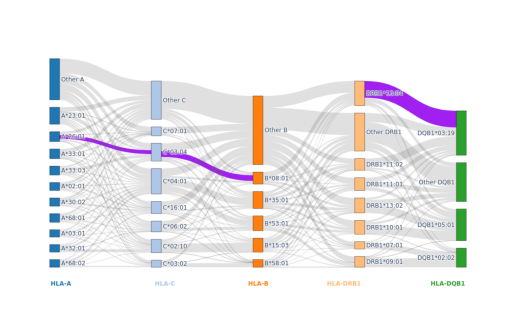

In [12]:
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'f5b.png'
title = ''

df = pd.read_csv('results/hla_ref_panel/oneKG_mGenv1/oneKG_mGenv1_HLA_calls.tsv', sep='\t')
df = df[df['Sample ID'].str.contains('IDT')].fillna('')
df = df.iloc[:, 3:]

for c in df.columns:
    g = c.split(' ')[0].split('-')[1]
    df[c] = g + '*' + df[c]

haplotypes = []
for _, row in df.iterrows():
    haplo1 = (row['HLA-A 1'], row['HLA-C 1'], row['HLA-B 1'], row['HLA-DRB1 1'], row['HLA-DQB1 1'])
    haplo2 = (row['HLA-A 2'], row['HLA-C 2'], row['HLA-B 2'], row['HLA-DRB1 2'], row['HLA-DQB1 2'])
    haplotypes.extend([haplo1, haplo2])

a_counts = Counter([h[0] for h in haplotypes])
c_counts = Counter([h[1] for h in haplotypes])
b_counts = Counter([h[2] for h in haplotypes])
drb1_counts = Counter([h[3] for h in haplotypes])
dqb1_counts = Counter([h[4] for h in haplotypes])
total = len(haplotypes)

def collapse_alleles(h, threshold=0.05):
    a, c, b, drb1, dqb1 = h
    a = a if a_counts[a]/total >= threshold else 'Other A'
    b = b if b_counts[b]/total >= threshold else 'Other B'
    c = c if c_counts[c]/total >= threshold else 'Other C'
    drb1 = drb1 if drb1_counts[drb1]/total >= threshold else 'Other DRB1'
    dqb1 = dqb1 if dqb1_counts[dqb1]/total >= threshold else 'Other DQB1'
    return (a, c, b, drb1, dqb1)

haplotypes_collapsed = [collapse_alleles(h) for h in haplotypes]
hap_counter = Counter(haplotypes_collapsed)

alleles_a = sorted({h[0] for h in hap_counter})
alleles_c = sorted({h[1] for h in hap_counter})
alleles_b = sorted({h[2] for h in hap_counter})
alleles_drb1 = sorted({h[3] for h in hap_counter})
alleles_dqb1 = sorted({h[4] for h in hap_counter})

labels = alleles_a + alleles_c + alleles_b + alleles_drb1 + alleles_dqb1
index_map = {allele: i for i, allele in enumerate(labels)}

colors = plt.get_cmap(CATEGORY_CMAP_STR).colors[:5]
hex_codes = [mcolors.to_hex(color) for color in colors]

color_a = [hex_codes[0]] * len(alleles_a)
color_c = [hex_codes[1]] * len(alleles_c)
color_b = [hex_codes[2]] * len(alleles_b)
color_drb1 = [hex_codes[3]] * len(alleles_drb1)
color_dqb1 = [hex_codes[4]] * len(alleles_dqb1)
node_colors = color_a + color_c + color_b + color_drb1 + color_dqb1

source = []
target = []
value = []

for (a, c, b, drb1, dqb1), count in hap_counter.items():
    source.append(index_map[a])
    target.append(index_map[c])
    value.append(count)
    
    source.append(index_map[c])
    target.append(index_map[b])
    value.append(count)
    
    source.append(index_map[b])
    target.append(index_map[drb1])
    value.append(count)
    
    source.append(index_map[drb1])
    target.append(index_map[dqb1])
    value.append(count)

results = pd.DataFrame({'source': source, 'target': target, 'value': value}).groupby(['source', 'target'], as_index=False)['value'].sum()
results['link_colors'] = 'rgba(100,100,100,0.2)'

hap_counter = Counter([(i,j,k) for (i,j,k,_,_) in haplotypes_collapsed])
filtered_hap_counter = {hap: count for hap, count in hap_counter.items() 
                        if 'Other' not in hap[0] and 'Other' not in hap[1] and 'Other' not in hap[2]}
most_frequent_haplo = max(filtered_hap_counter, key=filtered_hap_counter.get)
a,c,b = most_frequent_haplo

indices = []
idx = np.where((results['source'] == index_map[a]) & (results['target'] == index_map[c]))[0][0]
indices.append(idx)
idx = np.where((results['source'] == index_map[c]) & (results['target'] == index_map[b]))[0][0]
indices.append(idx)

dominant_color = '#A020F0'
results.iloc[indices, 3] = dominant_color

hap_counter = Counter([(i,j) for (_,_,_,i,j) in haplotypes_collapsed])
filtered_hap_counter = {hap: count for hap, count in hap_counter.items() 
                        if 'Other' not in hap[0] and 'Other' not in hap[1]}
most_frequent_haplo = max(filtered_hap_counter, key=filtered_hap_counter.get)
drb1, dqb1 = most_frequent_haplo

idx = np.where((results['source'] == index_map[drb1]) & (results['target'] == index_map[dqb1]))[0][0]
results.iloc[idx, 3] = dominant_color
    
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=results['source'],
        target=results['target'],
        value=results['value'],
        color=results['link_colors']
    ),
    arrangement='snap'
)])

most_frequent_haplo = max(hap_counter, key=hap_counter.get)

# fig.update_layout(
#     title_text="HLA haplotypes",
#     font_size=12
# )

annotations = [
    dict(x=0, y=-0.1, xref='paper', yref='paper',
         text=f"<b><span style='color:{hex_codes[0]}'>HLA-{HLA_GENES[0]}</span>", showarrow=False, font=dict(size=12)),
    dict(x=0.25, y=-0.1, xref='paper', yref='paper',
         text=f"<b><span style='color:{hex_codes[1]}'>HLA-{HLA_GENES[2]}</span><b>", showarrow=False, font=dict(size=12)),
    dict(x=0.5, y=-0.1, xref='paper', yref='paper',
         text=f"<b><span style='color:{hex_codes[2]}'>HLA-{HLA_GENES[1]}</span><b>", showarrow=False, font=dict(size=12)),
    dict(x=0.75, y=-0.1, xref='paper', yref='paper',
         text=f"<b><span style='color:{hex_codes[3]}'>HLA-{HLA_GENES[4]}</span><b>", showarrow=False, font=dict(size=12)),
    dict(x=1, y=-0.1, xref='paper', yref='paper',
         text=f"<b><span style='color:{hex_codes[4]}'>HLA-{HLA_GENES[3]}</span><b>", showarrow=False, font=dict(size=12))
]
fig.update_layout(annotations=annotations)
if save_fig:
    fig.write_image(f"{outdir}{save_name}", width=1000, height=600, scale=1)
    
img = mpimg.imread(f"{outdir}{save_name}")
plt.imshow(img)
plt.axis('off')
plt.show()

# F6 Improved HLA imputation accuracy

In [16]:
hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv')

hla_dirs = ['/well/band/users/rbx225/GAMCC/results/hla/imputation/QUILT_HLA_result_v3390/', 
                  '/well/band/users/rbx225/GAMCC/results/hla/server/chip_vanilla/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/imputation/QUILT_HLA_result_db/',
                  '/well/band/users/rbx225/GAMCC/results/hla/imputation/QUILT_HLA_result_merged_ref/',
                  '/well/band/users/rbx225/GAMCC/results/hla/imputation/QUILT_HLA_result_merged_ref_v3570/',
                  '/well/band/users/rbx225/GAMCC/results/hla/imputation/QUILT_HLA_result_method/',
                  '/well/band/users/rbx225/GAMCC/results/hla/imputation/QUILT_HLA_result_method_v3570/',
                  '/well/band/users/rbx225/GAMCC/results/hla/imputation/QUILT_HLA_result_optimal/',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_mGenv1_chip_sites/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_mGenv1_topmed/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_mGenv1_topmed_chip_sites/chr6.dose.vcf.gz']
labels =  ['QUILT               : 1000 Genomes', 'Microarray: multi-ethnic', 'db', 'merged_ref', 'merged_ref_v3570', 
               'QUILT modified: 1000 Genomes', 'method_v3570', 'QUILT modified: 1000 Genomes + GAMCC', 
               'mGenv1_typed_only', 'mGenv1_topmed', 'mGenv1_topmed_typed_only']
modes = ['old', 'old', 'old', 'old', 'old', 
               'test', 'test', 'test', 
               'old', 'old', 'old']

## F6a: Improved lc

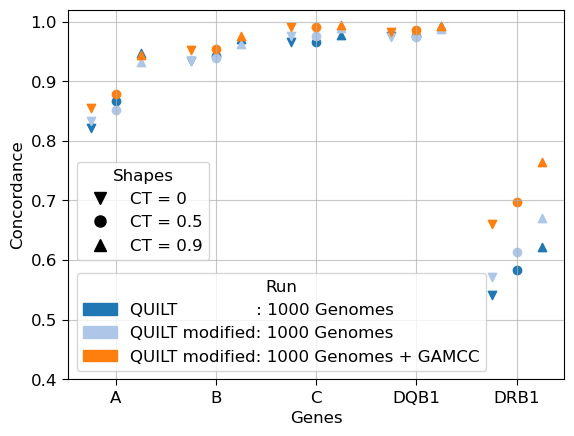

In [17]:
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'f6a.png'
title = ''

indices = [0, 5, 7]
report = lcwgsus.plot_hla_imputation_accuracy_lc(hla, hla_dirs, labels, modes, indices,
                                                save_fig = save_fig, outdir = outdir, save_name = save_name)

## F6b: Overall

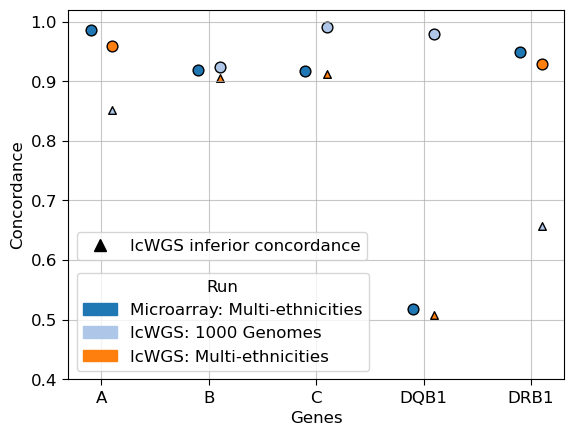

In [48]:
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'f6b.png'
title = ''

exclude_alleles = None
combined = 'combined'
recode_two_field = False
retain = 'fv'
cmap = CATEGORY_CMAP_STR

indices = [1, 7, 9]
hla_dirs_tmp = [hla_dirs[i] for i in indices]
labels_tmp = ['Microarray: Multi-ethnicities', 'lcWGS: 1000 Genomes', 'lcWGS: Multi-ethnicities']
modes_tmp = [hla_dirs[i] for i in indices]
indices = [0, 1, 2]

colors = plt.get_cmap(cmap).colors[:(len(labels_tmp))]
hex_codes = [mcolors.to_hex(color) for color in colors]
colors = dict(zip(labels_tmp, hex_codes))

hla_reports = []
for d, l in zip(hla_dirs_tmp, labels_tmp):
    report = lcwgsus.calculate_hla_imputation_accuracy(d, hla, l, exclude_alleles = exclude_alleles)
    hla_reports.append(report)
report = pd.concat(hla_reports)
report = report.sort_values(by = 'Locus')
hla_report = report[report['Resolution'] == 'Two field'].reset_index(drop = True)

xaxis = np.arange(1, 6)/5
offsets = [-0.02, 0.02, 0.02]
marker_sizes = [
    [60, 60, 60, 60, 60],
    [30, 60, 60, 60, 30],
    [60, 30, 30, 30, 60]
]

marker_shapes = [
    ['o', 'o', 'o', 'o', 'o'],
    ['^', 'o', 'o', 'o', '^'],
    ['o', '^', '^', '^', 'o']
]

for i, l in enumerate(labels_tmp):
    marker_size = marker_sizes[i]
    marker_shape = marker_shapes[i]
    tmp = hla_report[hla_report['Source'] == l]['Concordance'].values
    for j, g in enumerate(HLA_GENES):
        plt.scatter(xaxis[j] + offsets[i], tmp[j], c = colors[l], ec = 'black', marker = marker_shape[j], s = marker_size[j])

ax = plt.gca()       

color_legend = [mpatches.Patch(color=colors[l], label=l) for i, l in enumerate(labels_tmp)]
legend1 = ax.legend(handles=color_legend, title="Run", loc="lower left")
ax.add_artist(legend1)

shape_legend = [mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=8, 
                              label='lcWGS inferior concordance')]
legend2 = ax.legend(handles=shape_legend, loc="lower left", bbox_to_anchor=(0, 0.3))


plt.xlabel('Genes')
plt.ylabel('Concordance')
plt.xticks(xaxis, HLA_GENES)
plt.ylim((0.4, 1.02))
plt.grid(alpha = 0.7)

lcwgsus.save_figure(save_fig, outdir, save_name)

# F7 GYP

In [42]:
cov = pd.read_csv('results/coverage/gyp/gyp_coverage.tsv', sep = '\t')
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]

for s in cov.columns[1:]:
    cov[s] = cov[s]/(10000)
    
eth = pd.read_csv('data/metadata/ethnic_group.csv')
sl = pd.read_csv(SAMPLE_LINKER_FILE)
sl = sl[~sl['Sample_Name'].str.contains('mini')]

eth = eth[eth['Chip_Name'].isin(sl['Chip_Name'])]
sl = {k:v for k, v in zip(sl['Chip_Name'], sl['Seq_Name'])}
eth['Chip_Name'] = eth['Chip_Name'].apply(lambda x: sl[x])
eth = eth.sort_values(by = 'Chip_Name').reset_index(drop = True)
ethnicities = eth['ethnic'].unique().tolist()

## Without ethnicities

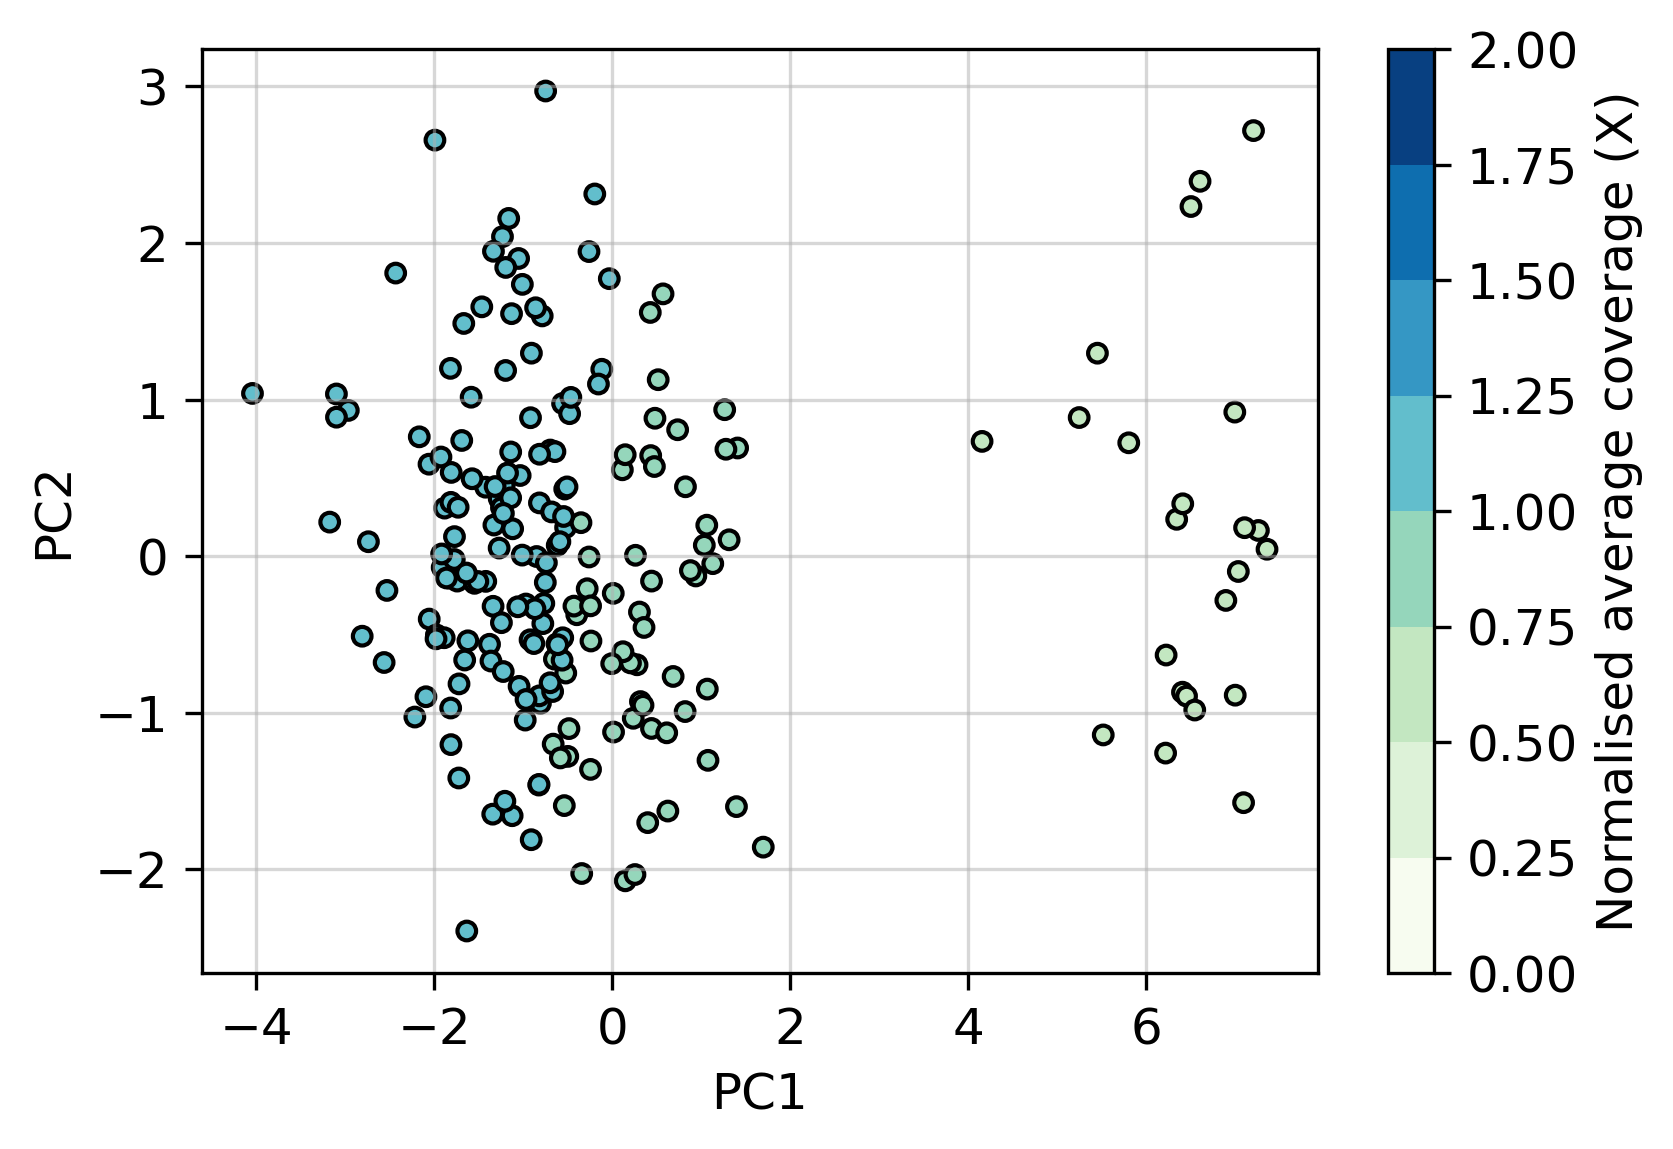

In [46]:
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'f7a.png'

extension1 = 0
d1_start = 143910000 - extension1
d1_end = 144030000 + extension1

flank = 100000
flank_cov = cov[((cov['position'] >= d1_start - flank) & (cov['position'] < d1_start)) | 
    ((cov['position'] > d1_end) & (cov['position'] <= d1_end+flank))].mean(axis = 0).iloc[1:]

cov1 = cov.copy()
for i, s in enumerate(cov1.columns[1:]):
    cov1[s] = cov1[s]/flank_cov.loc[s]

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]
pc_df['ethnic'] = eth['ethnic']
pc_df['cov'] = avg_coverage

markers = ['o', 'v', '*', '^']

fig = plt.figure(figsize=(6, 4), dpi = 300)

im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = pc_df['cov'],
                     cmap='GnBu', norm=norm, edgecolor='black', s = 20, label = e)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')

lcwgsus.save_figure(save_fig, outdir, save_name)

## With ethnicities

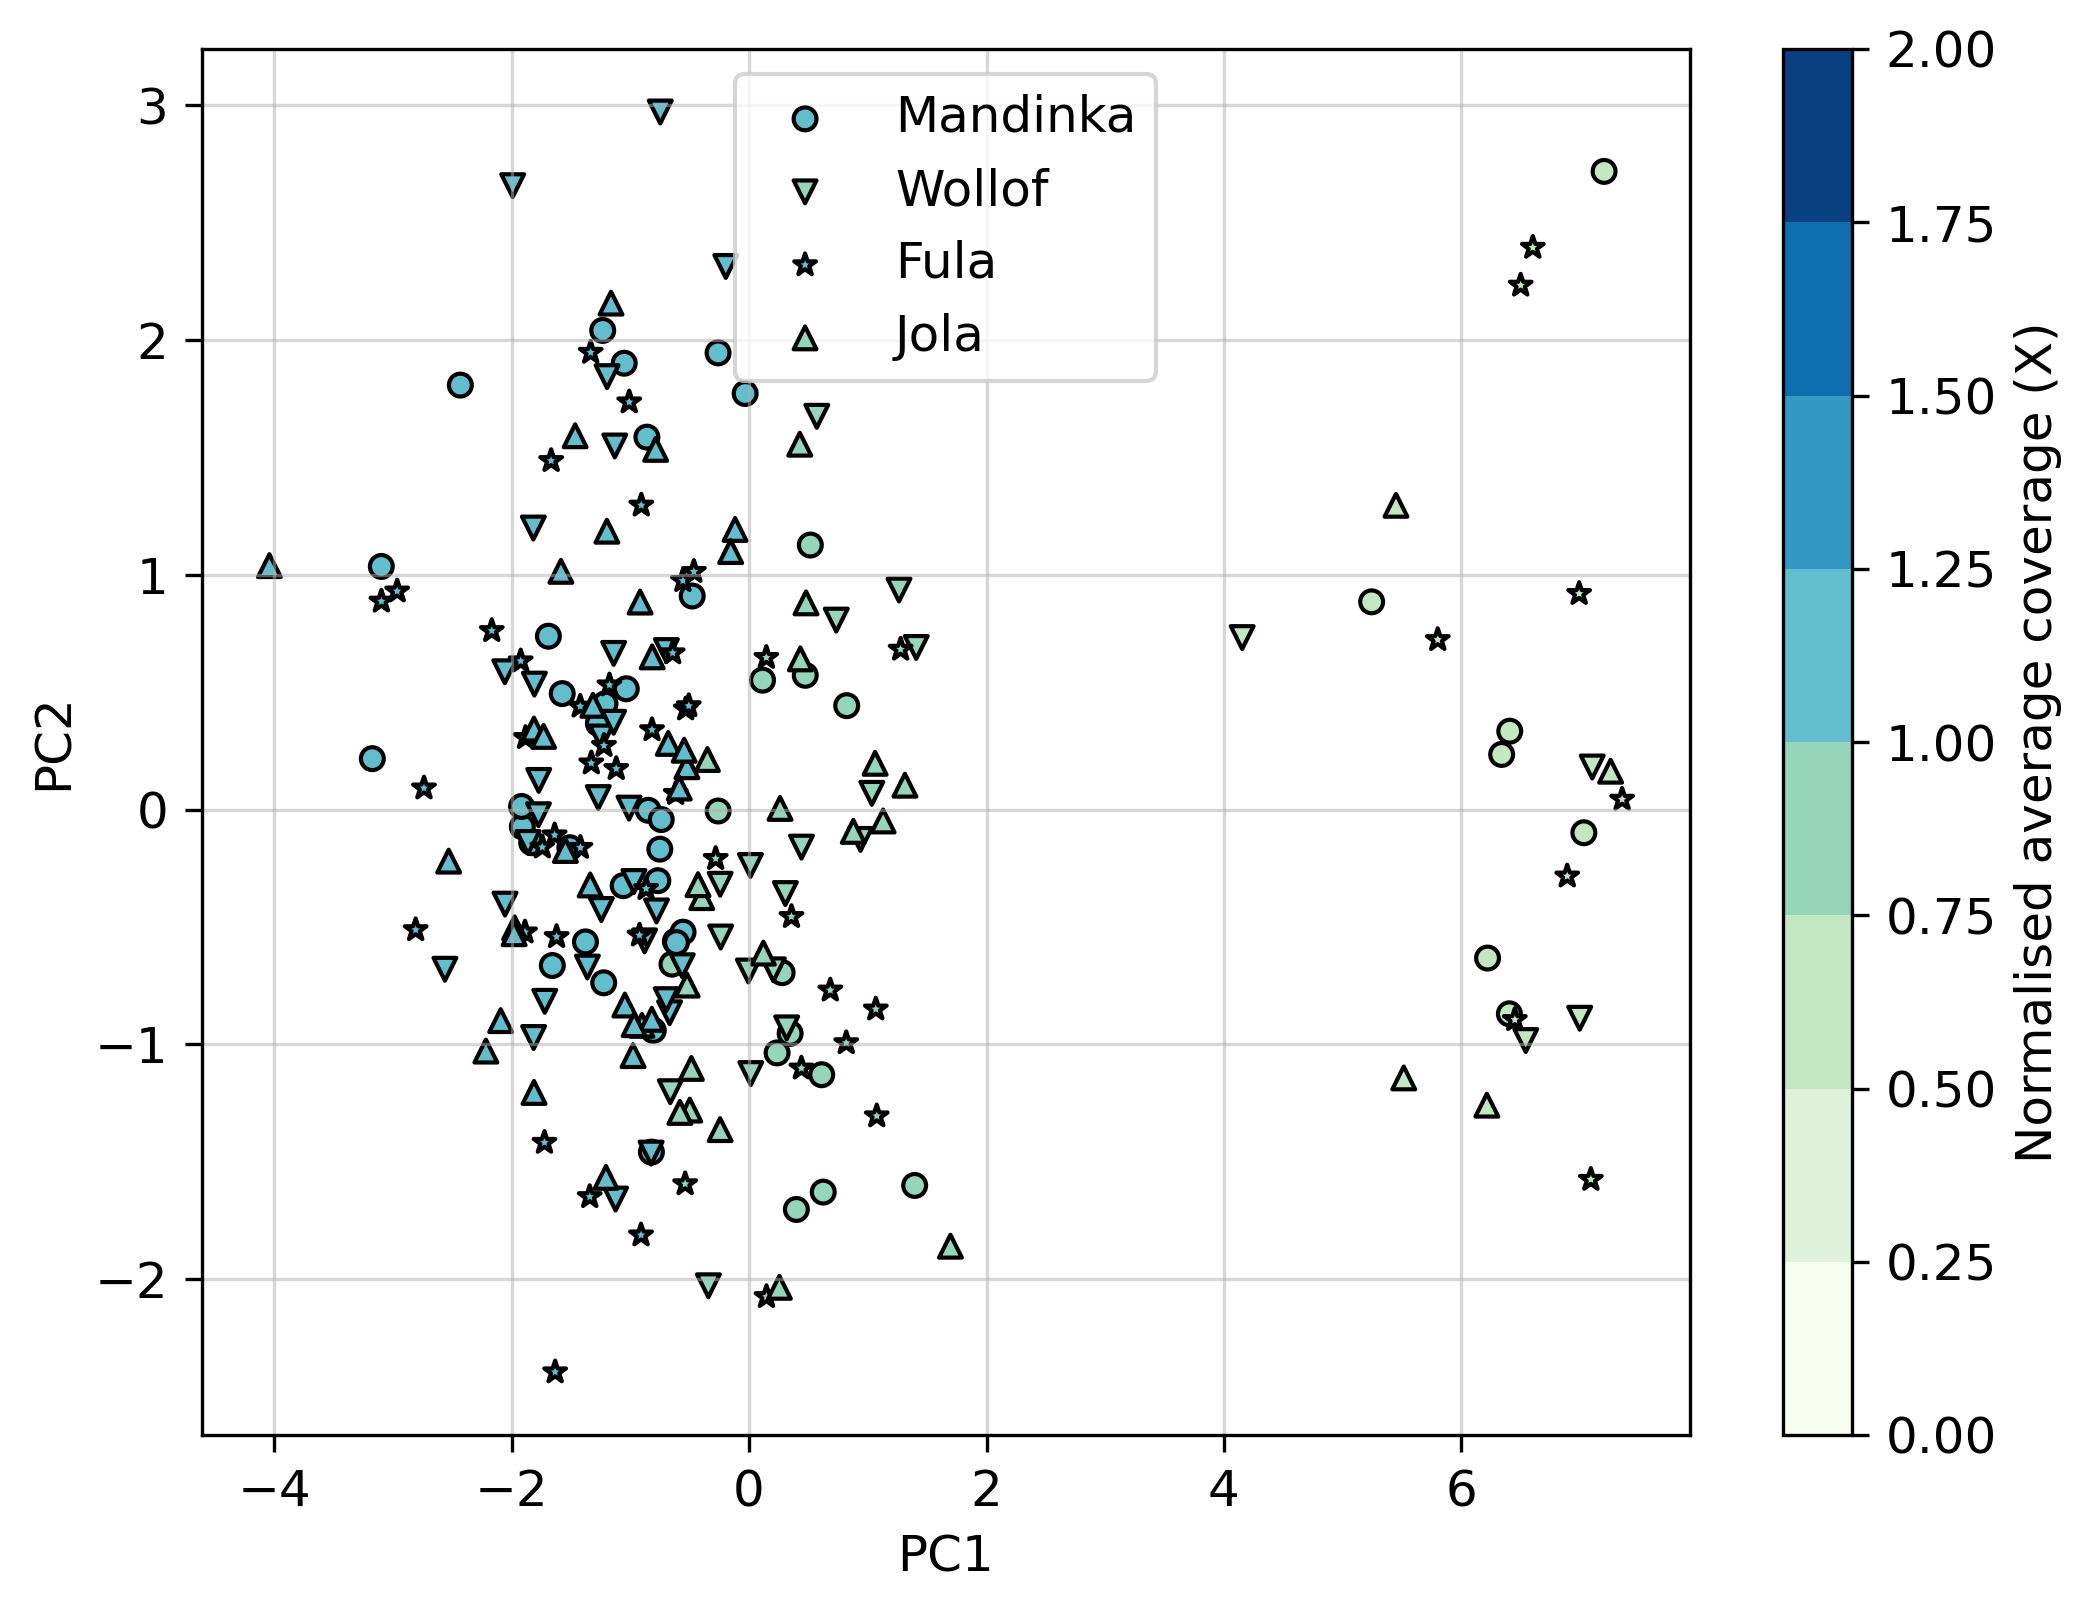

In [48]:
extension1 = 0
d1_start = 143910000 - extension1
d1_end = 144030000 + extension1

flank = 100000
flank_cov = cov[((cov['position'] >= d1_start - flank) & (cov['position'] < d1_start)) | 
    ((cov['position'] > d1_end) & (cov['position'] <= d1_end+flank))].mean(axis = 0).iloc[1:]

cov1 = cov.copy()
for i, s in enumerate(cov1.columns[1:]):
    cov1[s] = cov1[s]/flank_cov.loc[s]

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]
pc_df['ethnic'] = eth['ethnic']
pc_df['cov'] = avg_coverage

markers = ['o', 'v', '*', '^']

fig = plt.figure(figsize=(8, 6), dpi = 300)
for i, e in enumerate(ethnicities):
    tmp = pc_df[pc_df['ethnic'] == e]
    im = plt.scatter(tmp['PC1'], tmp['PC2'], c = tmp['cov'], marker = markers[i], 
                     cmap='GnBu', norm=norm, edgecolor='black', s = 30, label = e)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5)

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Coverage

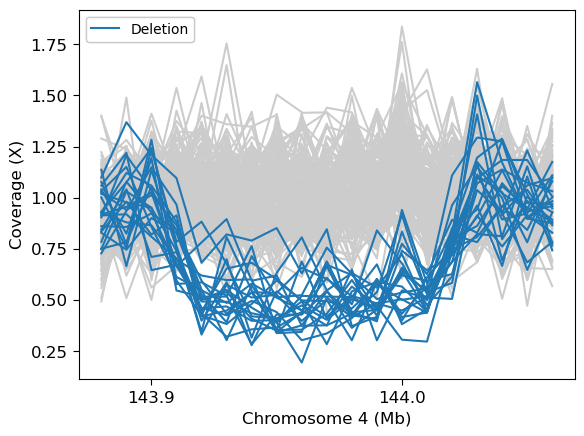

In [47]:
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'f7b.png'

e1 = 30000
de1_region = cov1[(cov1['position'] >= d1_start - e1) & (cov1['position'] <= d1_end + e1)]
de1_region['position'] = de1_region['position']/1000000

del1 = pc_df[pc_df['PC1'] < 3]
for i, s in enumerate(del1['Sample']):
    plt.plot(de1_region['position'], de1_region[s], alpha = 1, color = '0.8')

c = plt.get_cmap(CATEGORY_CMAP_STR).colors[:1][0]
c = mcolors.to_hex(c)

del1 = pc_df[pc_df['PC1'] > 3]
for i, s in enumerate(del1['Sample']):
    plt.plot(de1_region['position'], de1_region[s], alpha = 1, color = c)
    
tick_start = 143.9
tick_end = 144.1
tick_step = 0.1
ticks = np.arange(tick_start, tick_end, tick_step)
plt.xticks(ticks, [f"{tick:.1f}" for tick in ticks])

color_handles = [
    Line2D([0], [0], color=c, label='Deletion')
]

legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
legend1.get_title().set_fontsize(9)
plt.gca().add_artist(legend1)

plt.xlabel('Chromosome 4 (Mb)')
plt.ylabel('Coverage (X)')

lcwgsus.save_figure(save_fig, outdir, save_name)

## DEL2

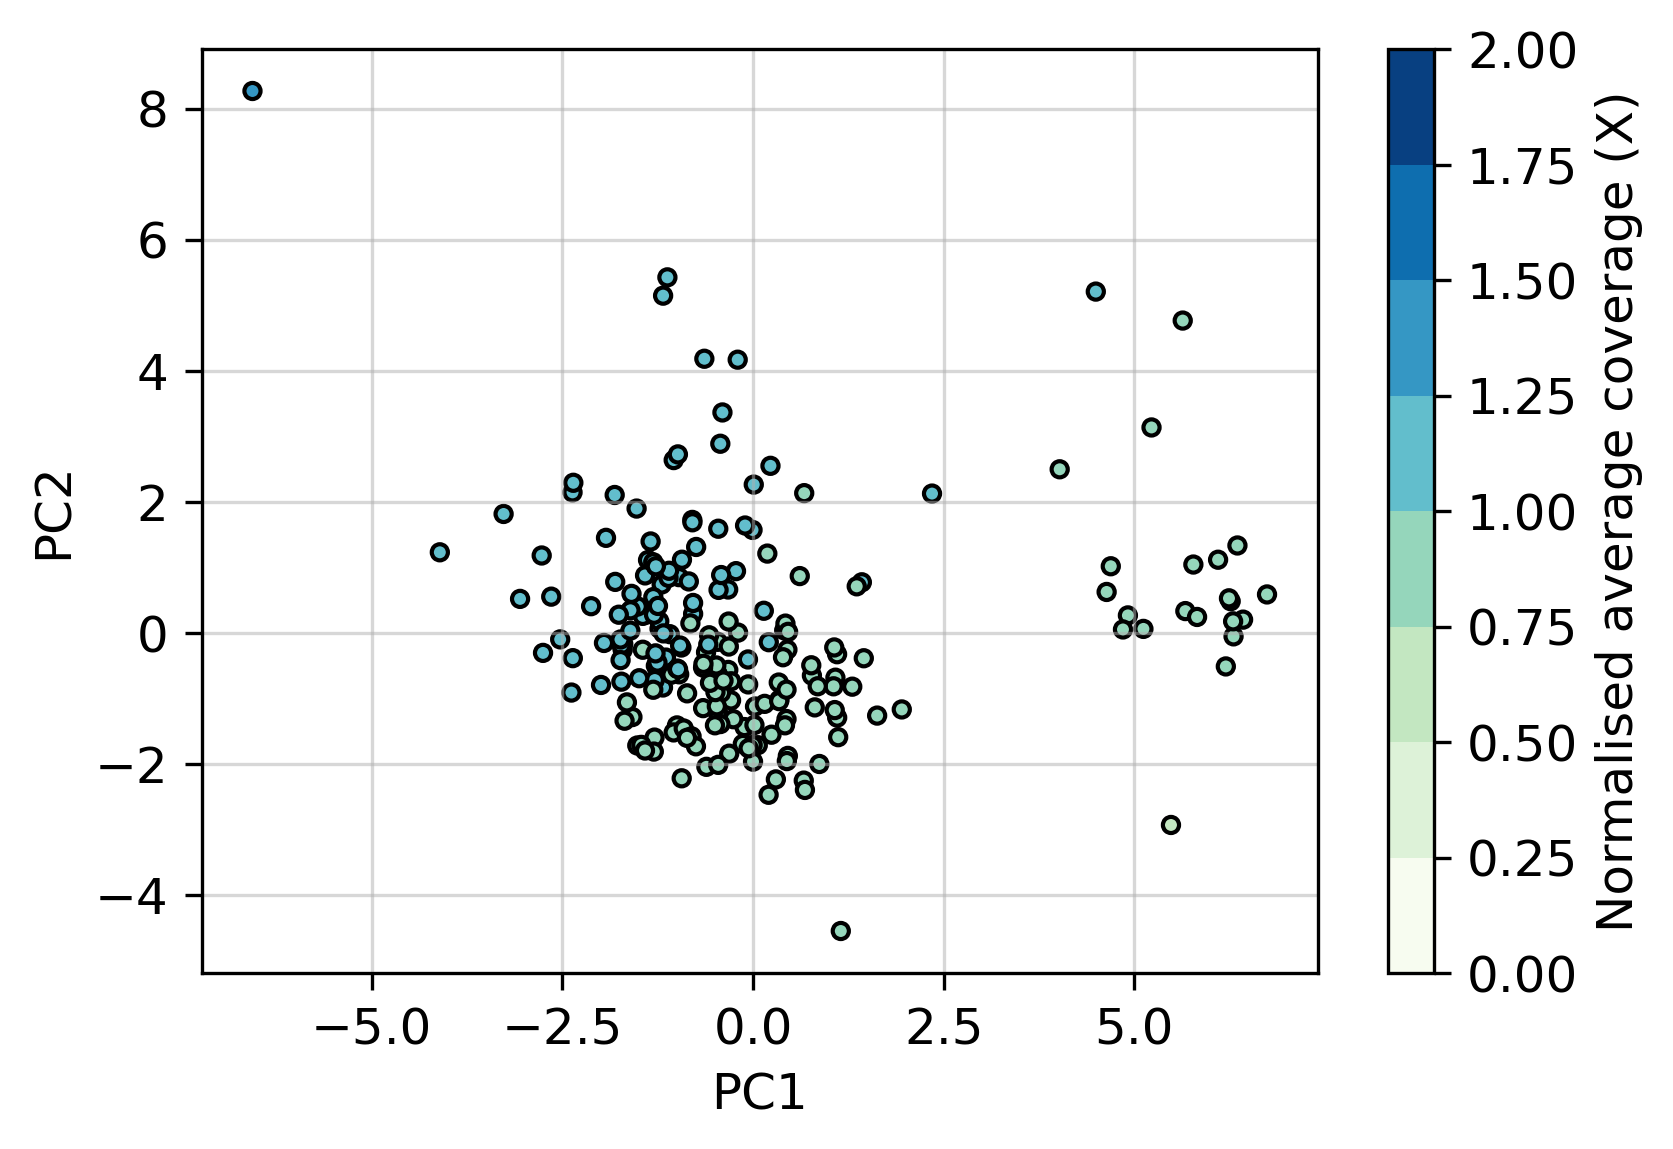

In [49]:
extension2 = 0
d2_start = 143780000 - extension2
d2_end = 143780000 + 210000 + extension2

flank = 100000
flank_cov = cov[((cov['position'] >= d2_start - flank) & (cov['position'] < d2_start)) | 
    ((cov['position'] > d2_end) & (cov['position'] <= d2_end+flank))].mean(axis = 0).iloc[1:]

cov2 = cov.copy()
for i, s in enumerate(cov2.columns[1:]):
    cov2[s] = cov2[s]/flank_cov.loc[s]

normalized_df = cov2[(cov2['position'] >= d2_start) & (cov2['position'] <= d2_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]


fig = plt.figure(figsize=(6, 4), dpi = 300)
# ax = fig.gca()
im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = avg_coverage, cmap='GnBu', norm = norm, edgecolor='black', s = 15)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# SF1 lcWGS sample performance

## SF1a Scatterplot

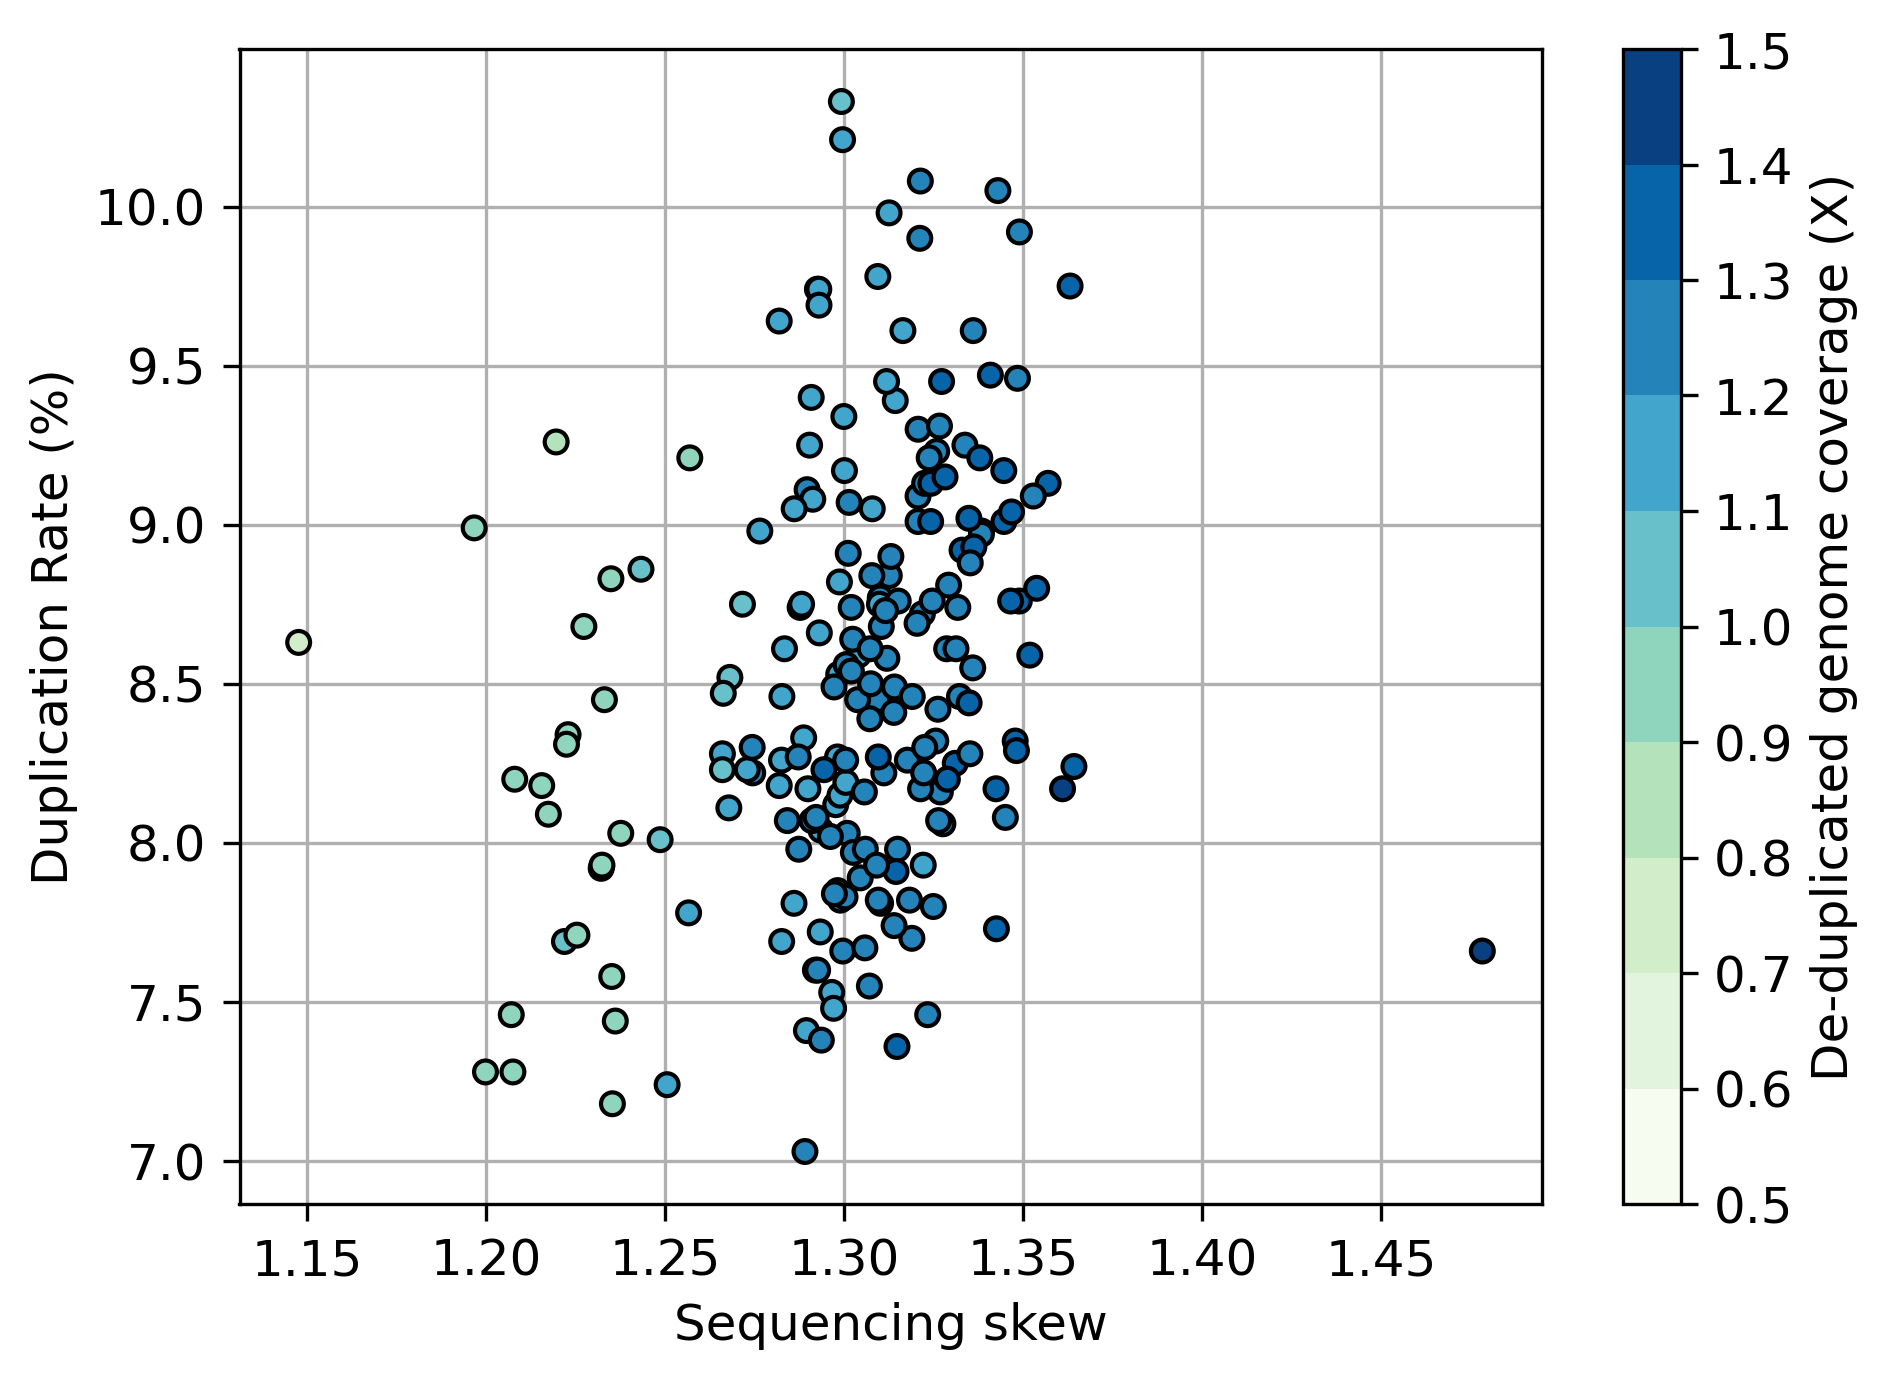

In [54]:
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'sf1a.png'

metrics = pd.read_csv('results/metrics.csv')
expectation_ary = []
for mu in metrics['Coverage']:
    poisson_expectation = np.cumsum(
            poisson.pmf(np.arange(10), mu=mu, loc=0))
    expectation_ary.append(poisson_expectation[0])
metrics['Sequencing skew'] = metrics['Uncoverage']/expectation_ary

fv = metrics[~metrics['Sample_Name'].str.contains('mini')]

title = 'lcWGS sample performance'

plt.figure(figsize=(7, 5), dpi = 300)
ax = plt.subplot(1, 1, 1)
plt.grid(True, zorder = 1)

cmap = plt.get_cmap('GnBu')
magnitude = 10
bounds = np.linspace(0.5, 1.5, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = plt.scatter(fv['Sequencing skew'], 
                 fv['Dup_Rate'] * 100, c = fv['Coverage'], edgecolor='black', cmap=cmap, 
                 norm=norm, s = 30, marker = 'o', label = 'Full Volume', zorder = 2)
plt.colorbar(im, boundaries=bounds, ticks = bounds, label='De-duplicated genome coverage (X)')

plt.xlabel('Sequencing skew')
plt.ylabel('Duplication Rate (%)')

lcwgsus.save_figure(save_fig, outdir, save_name)

## SF1b Histogram

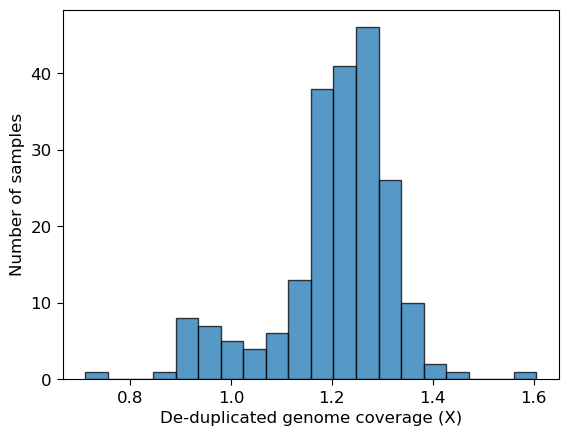

In [56]:
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'sf1b.png'

metrics = pd.read_csv('results/metrics.csv')
fv = metrics[~metrics['Sample_Name'].str.contains('mini')]
plt.hist(fv['Coverage'], bins = 20, ec = 'black', alpha = 0.75)
plt.xlabel('De-duplicated genome coverage (X)')
plt.ylabel('Number of samples')
lcwgsus.save_figure(save_fig, outdir, save_name)

# SF2 Chip QC

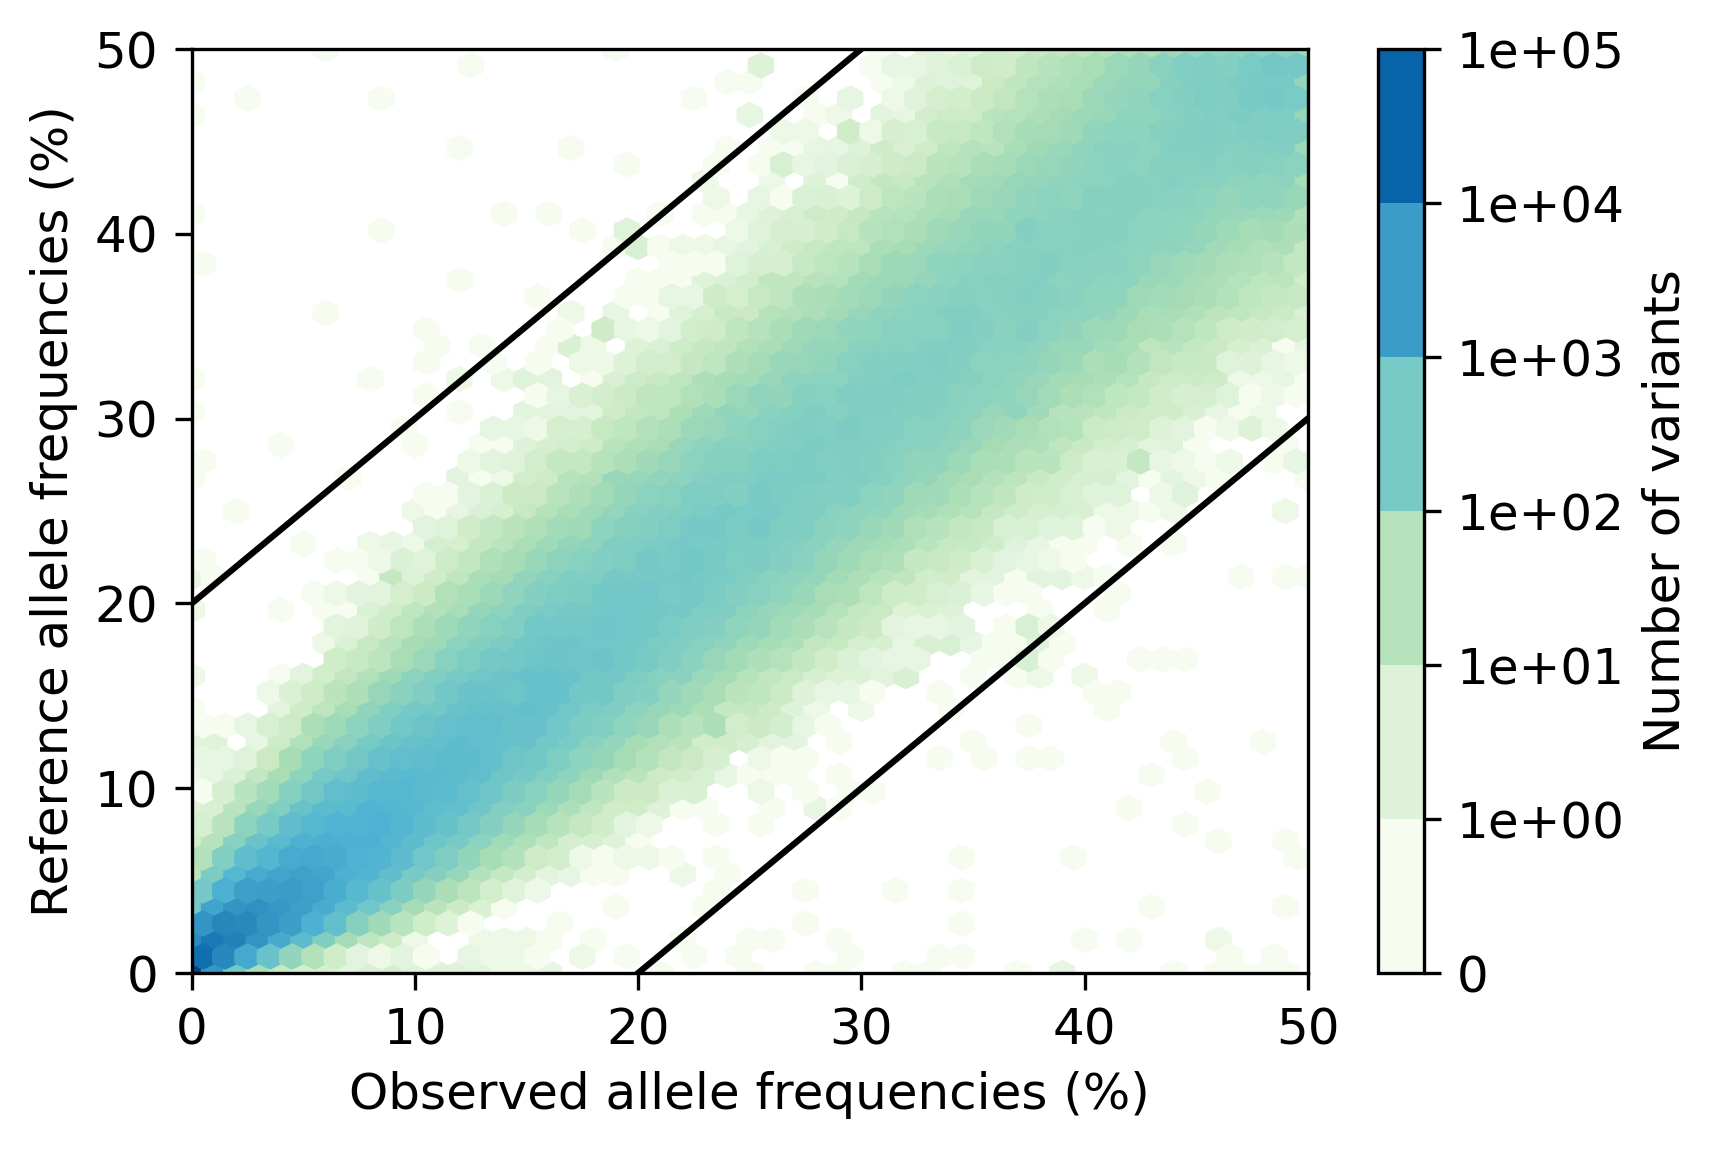

In [41]:
db = sqlite3.connect( "results/chip/qc/chip.qc.sqlite" )
snp = pd.read_sql_query( "SELECT * FROM autosomesView", db )
sample = pd.read_sql_query( "SELECT * FROM sample_statsView", db )
ethnic = pd.read_csv('data/metadata/ethnic_group.csv')
ethnic = ethnic.rename(columns = {'Chip_Name': 'sample_id'})
PC = pd.read_sql_query( "SELECT * FROM PCsView", db )
PC = PC[PC['analysis']=='PCs:thin_1bp:exclude-duplicates']
PC = PC.merge(ethnic, on = 'sample_id', how = 'left')

df = lcwgsus.read_vcf('results/chip/vcf/chip_genotype.vcf.gz')

kinship = pd.read_csv( "results/chip/qc/PCs/chip_kinship_thin_1bp.exclude-duplicates.tsv.gz", comment = '#', sep = '\t')

snp = pd.merge(snp, df[['ID', 'ref', 'alt', 'pos']], left_on = 'rsid', right_on = 'ID')
snp = snp.drop(columns = ['alleleA', 'alleleB', 'position']).rename(columns = {'ref': 'alleleA', 'alt': 'alleleB', 'pos': 'position'})

snp_missing = 0.05
snp_hwe = 1e-6
sample_missing = 0.05
heterozygosity_nstd = 3

drop_history = {}
num = snp.shape[0]
drop_history['original'] = num

snp = snp[~snp['chromosome'].isin(['MT', 'NA'])]
drop_history['drop_non-autosome'] = num - snp.shape[0]
num = snp.shape[0]
snp = snp[snp['missing_proportion'] < 0.2]
drop_history['drop_snp_missing_0.2'] = num - snp.shape[0]
num = snp.shape[0]
snp = snp[snp['HW_exact_p_value'] > snp_hwe]
drop_history['drop_snp_hwe_1e-6'] = num - snp.shape[0]
num = snp.shape[0]
snp = snp[snp['missing_proportion'] < snp_missing]
drop_history['drop_snp_missing_0.05'] = num - snp.shape[0]
num = snp.shape[0]

chromosomes = [i for i in range(1,23)]
oneKGmafs = ["/well/band/users/rbx225/recyclable_files/AFs/oneKG_MAFs/oneKG_AF_AFR_chr" + str(i) + ".txt" for i in chromosomes]
oneKGaf = lcwgsus.multi_read_af_chunks(oneKGmafs, ncores = 4)
oneKGaf['MAF'] = oneKGaf['MAF'].astype(float)
oneKGaf = oneKGaf.rename(columns = {'MAF': 'prop'})
oneKGaf['prop'] = np.where(oneKGaf['prop'] > 0.5, 1 - oneKGaf['prop'], oneKGaf['prop'])

GGVPmafs = ["/well/band/users/rbx225/recyclable_files/AFs/ggvp_AFs/ggvp_AF_chr" + str(i) + ".txt" for i in chromosomes]
GGVPaf = lcwgsus.multi_read_af_chunks(GGVPmafs, ncores = 4)
GGVPaf['MAF'] = GGVPaf['MAF'].astype(float)
GGVPaf = GGVPaf.rename(columns = {'MAF': 'prop'})
GGVPaf['prop'] = np.where(GGVPaf['prop'] > 0.5, 1 - GGVPaf['prop'], GGVPaf['prop'])
af = pd.merge(oneKGaf, GGVPaf, on = ['chromosome', 'position', 'ref', 'alt'], how = 'outer')
af['prop'] = af['prop_x'].combine_first(af['prop_y'])
af = af.drop(columns = ['prop_x', 'prop_y'])

chip_af = snp[['chromosome', 'position', 'alleleA', 'alleleB', 'minor_allele_frequency']]
chip_af = chip_af.rename(columns = {'alleleA': 'ref', 'alleleB': 'alt', 'minor_allele_frequency': 'prop'})
chip_af = chip_af[chip_af['chromosome'].isin([str(i) for i in range(1,23)])]
chip_af['chromosome'] = 'chr' + chip_af['chromosome'].astype(str)
chip_af['ref'] = chip_af['ref'].astype(str)
chip_af['alt'] = chip_af['alt'].astype(str)

def fill_prop(r):
    if pd.isna(r['prop_y']):
        r['prop_y'] = r['prop_x']
    return r

final = pd.merge(chip_af, af, on = ['chromosome', 'position', 'ref', 'alt'], how = 'left')
final = final.apply(fill_prop, axis = 1)

y = np.arange(51)/100

xp = y+0.2
xm = y-0.2

save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'sf2.png'

bounds = np.logspace(0, 5, 6)
bounds = np.insert(bounds, 0, 0)
norm = mcolors.BoundaryNorm(bounds, COLORBAR_CMAP.N)
fmt = lambda x, pos: '{:.0e}'.format(x) if x > 0 else 0

plt.figure(figsize=(6, 4), dpi = 300)
im = plt.hexbin(final['prop_x']*100, final['prop_y']*100, gridsize = 50, bins = 'log', cmap = COLORBAR_CMAP)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            format=FuncFormatter(fmt),
            label='Number of variants')
plt.xlabel('Observed allele frequencies (%)')
plt.ylabel('Reference allele frequencies (%)')
plt.plot(xp*100, y*100, color = 'black')
plt.plot(xm*100, y*100, color = 'black')
plt.xlim([0, 50])
plt.ylim([0, 50])

lcwgsus.save_figure(save_fig, outdir, save_name)

# SF3 Gambian PCA

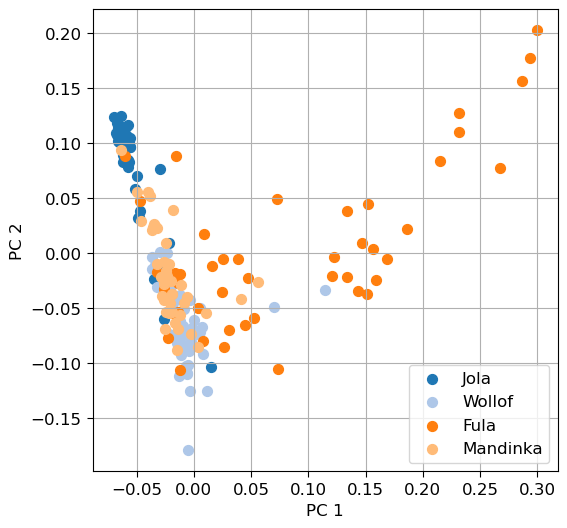

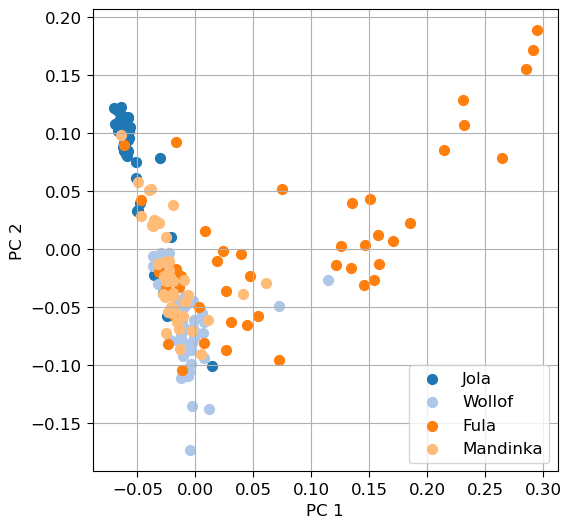

In [57]:
ethnic = pd.read_csv('data/metadata/ethnic_group.csv')
ethnic = ethnic.rename(columns = {'Chip_Name': 'FID'})
sl = pd.read_csv(SAMPLE_LINKER_FILE)
sl = sl[~sl['Sample_Name'].str.contains('mini')]
sl = {k:v for k,v in zip(sl['Sample_Name'], sl['Chip_Name'])}
PCchip = pd.read_csv('results/chip/qc/PCs/PCs.eigenvec', sep = ' ', header = None, names = ['FID', 'IID'] + ['PC' + str(i) for i in range(1,11)])
PCchip = PCchip.drop(columns = 'IID')
PClc = pd.read_csv('results/wip_vcfs/oneKG/vanilla/chip_sites/PCs.eigenvec', sep = ' ', header = None, names = ['FID', 'IID'] + ['PC' + str(i) for i in range(1,11)])
PClc = PClc[~PClc['IID'].str.contains('mini')]
PClc = PClc.drop(columns = 'IID')
def recode_names(r, sl = sl):
    r['FID'] = sl[r['FID']]
    return r
PClc = PClc.apply(recode_names, axis = 1)
PCchip = pd.merge(PCchip, ethnic, on = 'FID')
PClc = pd.merge(PClc, ethnic, on = 'FID').sort_values(by = 'FID')
PClc['PC2'] = -PClc['PC2']

outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'sf3a.png'
lcwgsus.plot_pc(PClc, title = '', save_fig = save_fig, outdir = outdir, save_name = save_name)
save_name = 'sf3b.png'
lcwgsus.plot_pc(PCchip, title = '', save_fig = save_fig, outdir = outdir, save_name = save_name)

# SF4 GWAS catalogue variants

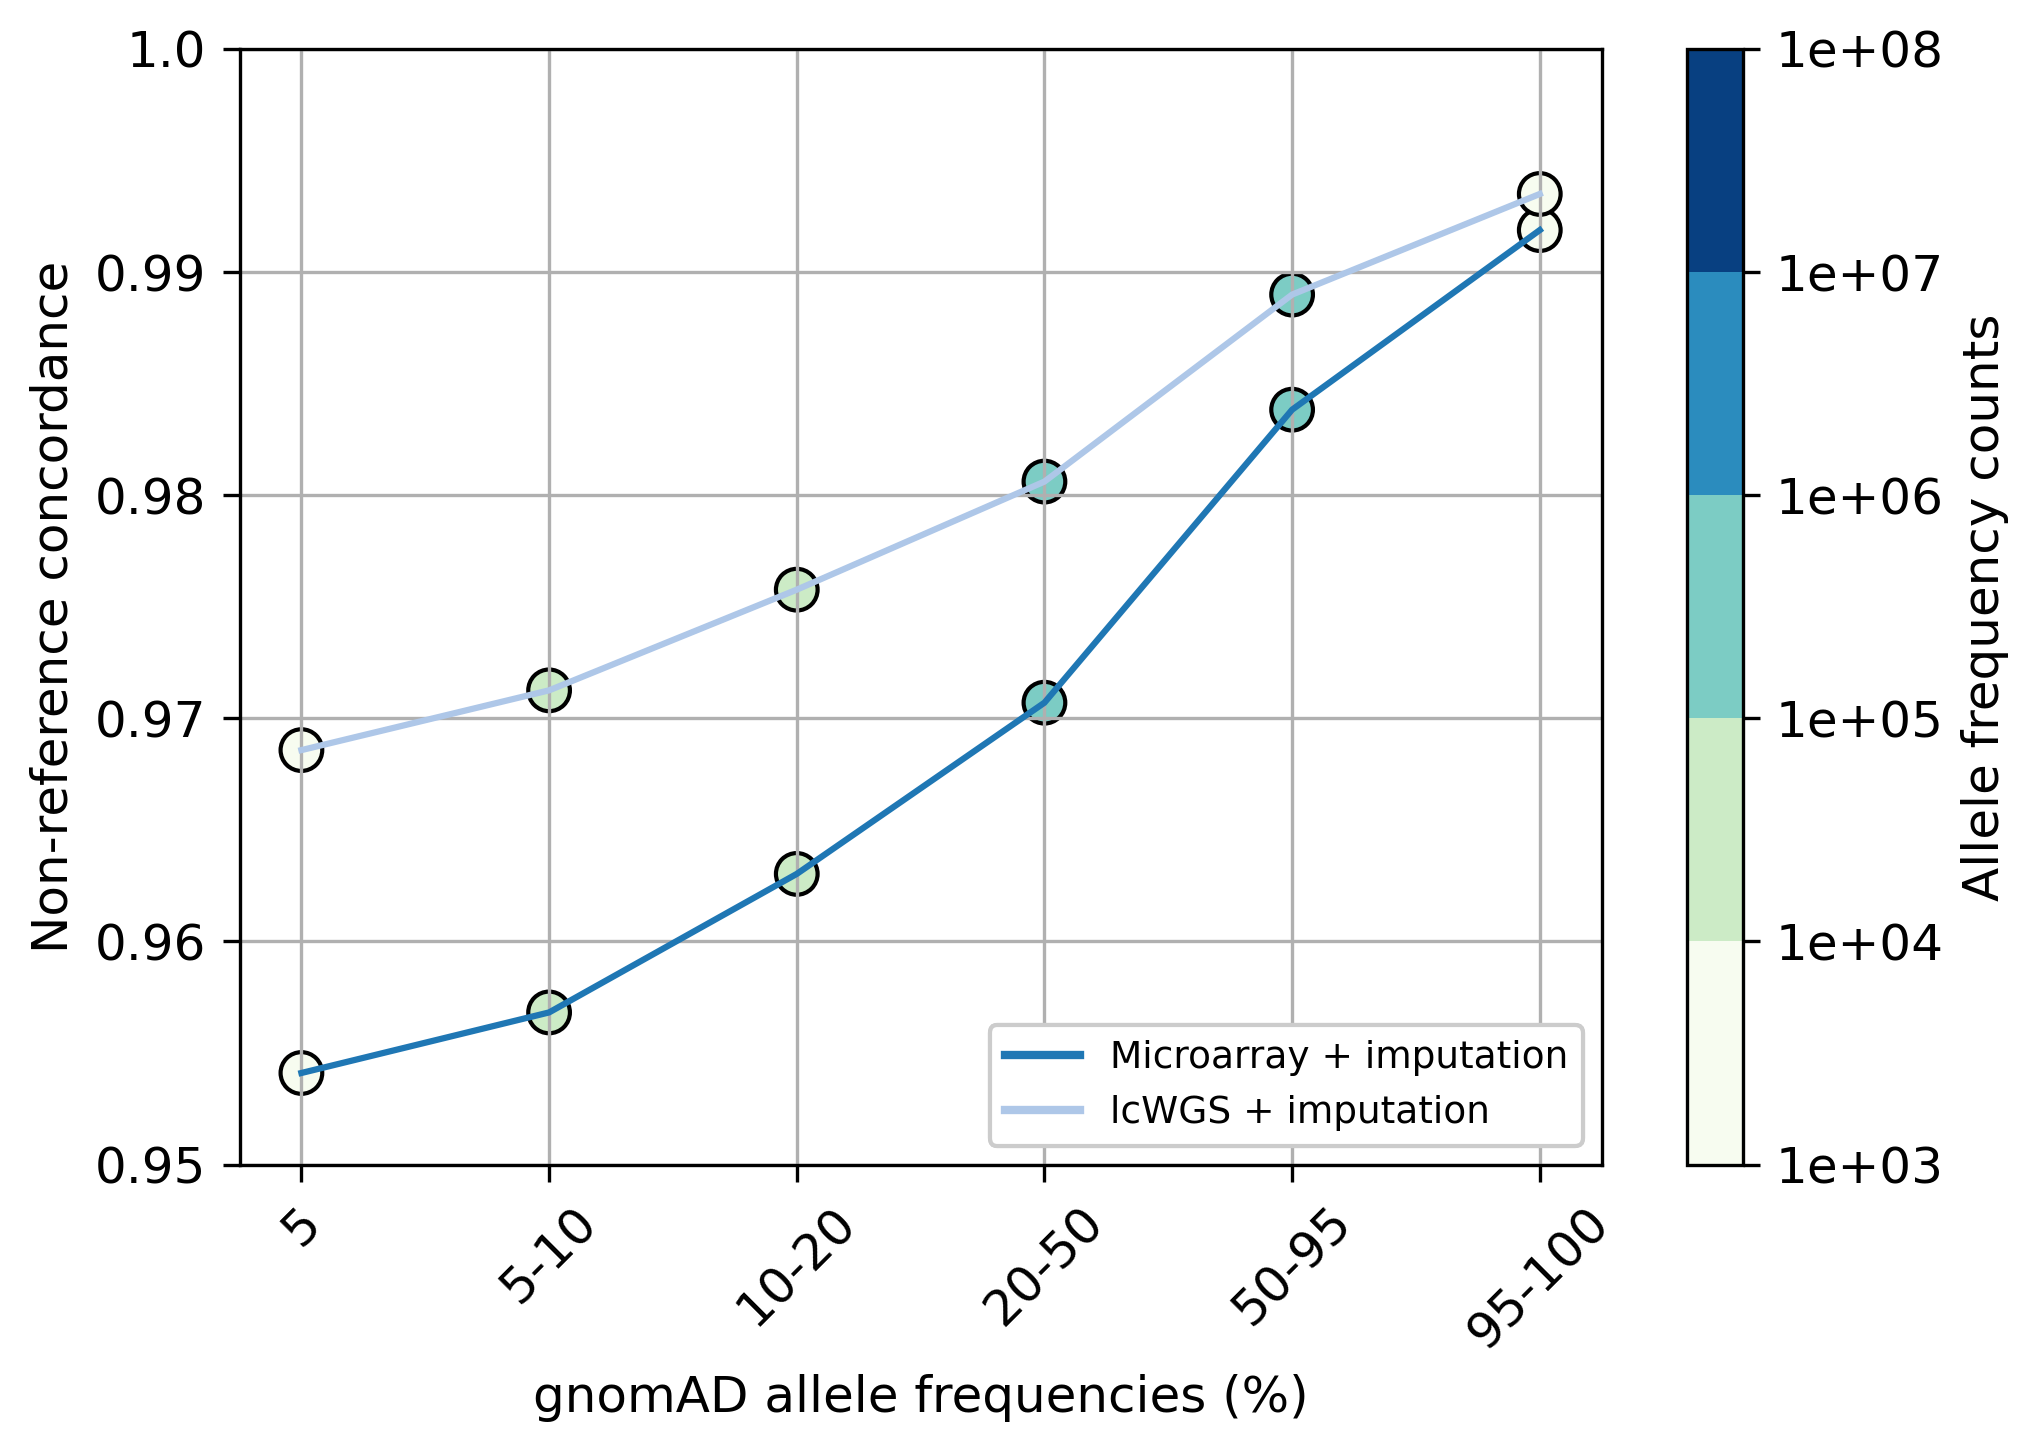

In [58]:
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'sf4.png'

gwassnps = pd.read_csv("/well/band/users/rbx225/recyclable_files/bedgraph/gwas_snps.tsv", sep = '\t', header = None, names = ['chr', 'pos', 'ID']).drop(columns = 'ID')
gwassnps = gwassnps[(~gwassnps['chr'].str.contains('alt')) & (~gwassnps['chr'].str.contains('X')) & (~gwassnps['chr'].str.contains('Y'))& (~gwassnps['chr'].str.contains('random'))]
gwassnps['chr'] = gwassnps['chr'].str.split('chr').str.get(1).astype(int)
gwassnps = gwassnps.drop_duplicates()
gwassnps = gwassnps.sort_values(by = ['chr', 'pos'], ascending = True).reset_index(drop = True)

runs = ['chip_topmed--hc--snps_gw', 'lc_malariaGen_v1_b38_topmed--hc--snps_gw']
impaccs = []

for r in runs:
    h = [pd.read_csv('results/imputation_comparison/vanilla/' + r + '/impacc/all_samples/by_variant/chr' + str(i) + '.h.tsv', sep = '\t') for i in CHROMOSOMES_ALL]
    h = pd.concat(h)
    h = h[h['r2'] != -9]
    gwas = pd.merge(h, gwassnps, on = ['chr', 'pos'])
    h_impacc = lcwgsus.generate_h_impacc(gwas)
    impaccs.append(h_impacc)
    
impaccs[0].loc[0, 'r2'] = 0
impaccs[1].loc[0, 'r2'] = 0

labels = ['Microarray + imputation', 'lcWGS + imputation']
title = ''

metric='NRC'
marker_size=100
colorbar_cmap=COLORBAR_CMAP
line_colors=CATEGORY_CMAP_HEX

colors = [line_colors[i] for i in [0,1]]

cols = ['AF', metric, metric + '_AC']
df_lst = [impacc[cols] for impacc in impaccs]

fig1 = plt.figure(figsize=(7, 5), dpi = 300)
ax = fig1.add_subplot(111)

magnitude = 5
bounds = np.logspace(3, 8, magnitude + 1)
norm = mcolors.BoundaryNorm(bounds, colorbar_cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

threshold = 0.05
set_ylim = False
subplot = False

for i in range(len(df_lst)):
    triplet = df_lst[i]
    if threshold is not None:
        triplet = triplet[triplet['AF'] >= threshold]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = lcwgsus.generate_af_axis(triplet[c0].values)
    vals = triplet[c1]
    allele_counts = triplet[c2]

    plt.plot(x, vals, c = colors[i])
    plt.xticks(x, afs, rotation=45)

    im = ax.scatter(x,
                    vals,
                    c=allele_counts,
                    edgecolor='black',
                    cmap=colorbar_cmap,
                    norm=norm,
                    s=marker_size)
    
    tick_start = 0.95
    tick_end = 1
    tick_step = 0.1
    ticks = np.linspace(tick_start, tick_end, 6)
    plt.yticks(ticks, [tick for tick in ticks])
    
if not subplot:
    plt.colorbar(im,
                boundaries=bounds,
                ticks=bounds,
                format=FuncFormatter(fmt),
                label='Allele frequency counts')

    plt.xlabel('gnomAD allele frequencies (%)')
    
    color_handles = [
        Line2D([0], [0], color=line_colors[0], lw=2, label=labels[0]),
        Line2D([0], [0], color=line_colors[1], lw=2, label=labels[1])
    ]

    legend1 = plt.legend(handles=color_handles, loc='lower right', prop={'size': 9}, framealpha=1)
    legend1.get_title().set_fontsize(9)
    plt.gca().add_artist(legend1)

    plt.ylabel('Non-reference concordance')
ax.grid()
fig1.tight_layout()

lcwgsus.save_figure(save_fig, outdir, save_name)

# cutoffs_l = [0, 0.01, 0.05, 0.1]
# cutoffs_u = [0.01, 0.05, 0.1, 1]
# labels = ['<1', '1-5', '5-20', '>20']

# impaccs_avg = []

# for df in impaccs:
#     res = pd.DataFrame(columns = ['AF', 'NRC', 'NRC_AC'])
#     for i, (l, u) in enumerate(zip(cutoffs_l, cutoffs_u)):
#         tmp = df[(df['AF'] > l) & (df['AF'] <= u)]
#         label = labels[i]
#         avg = lcwgsus.calculate_weighted_average(tmp['NRC'].to_numpy(), tmp['NRC_AC'].to_numpy())
#         res.loc[len(res)] = [label, avg, tmp['NRC_AC'].sum()]
#     impaccs_avg.append(res)
    
# impaccs_avg[1]

# SF5 Long-read and short-read simulations

## SF5a: Short-read

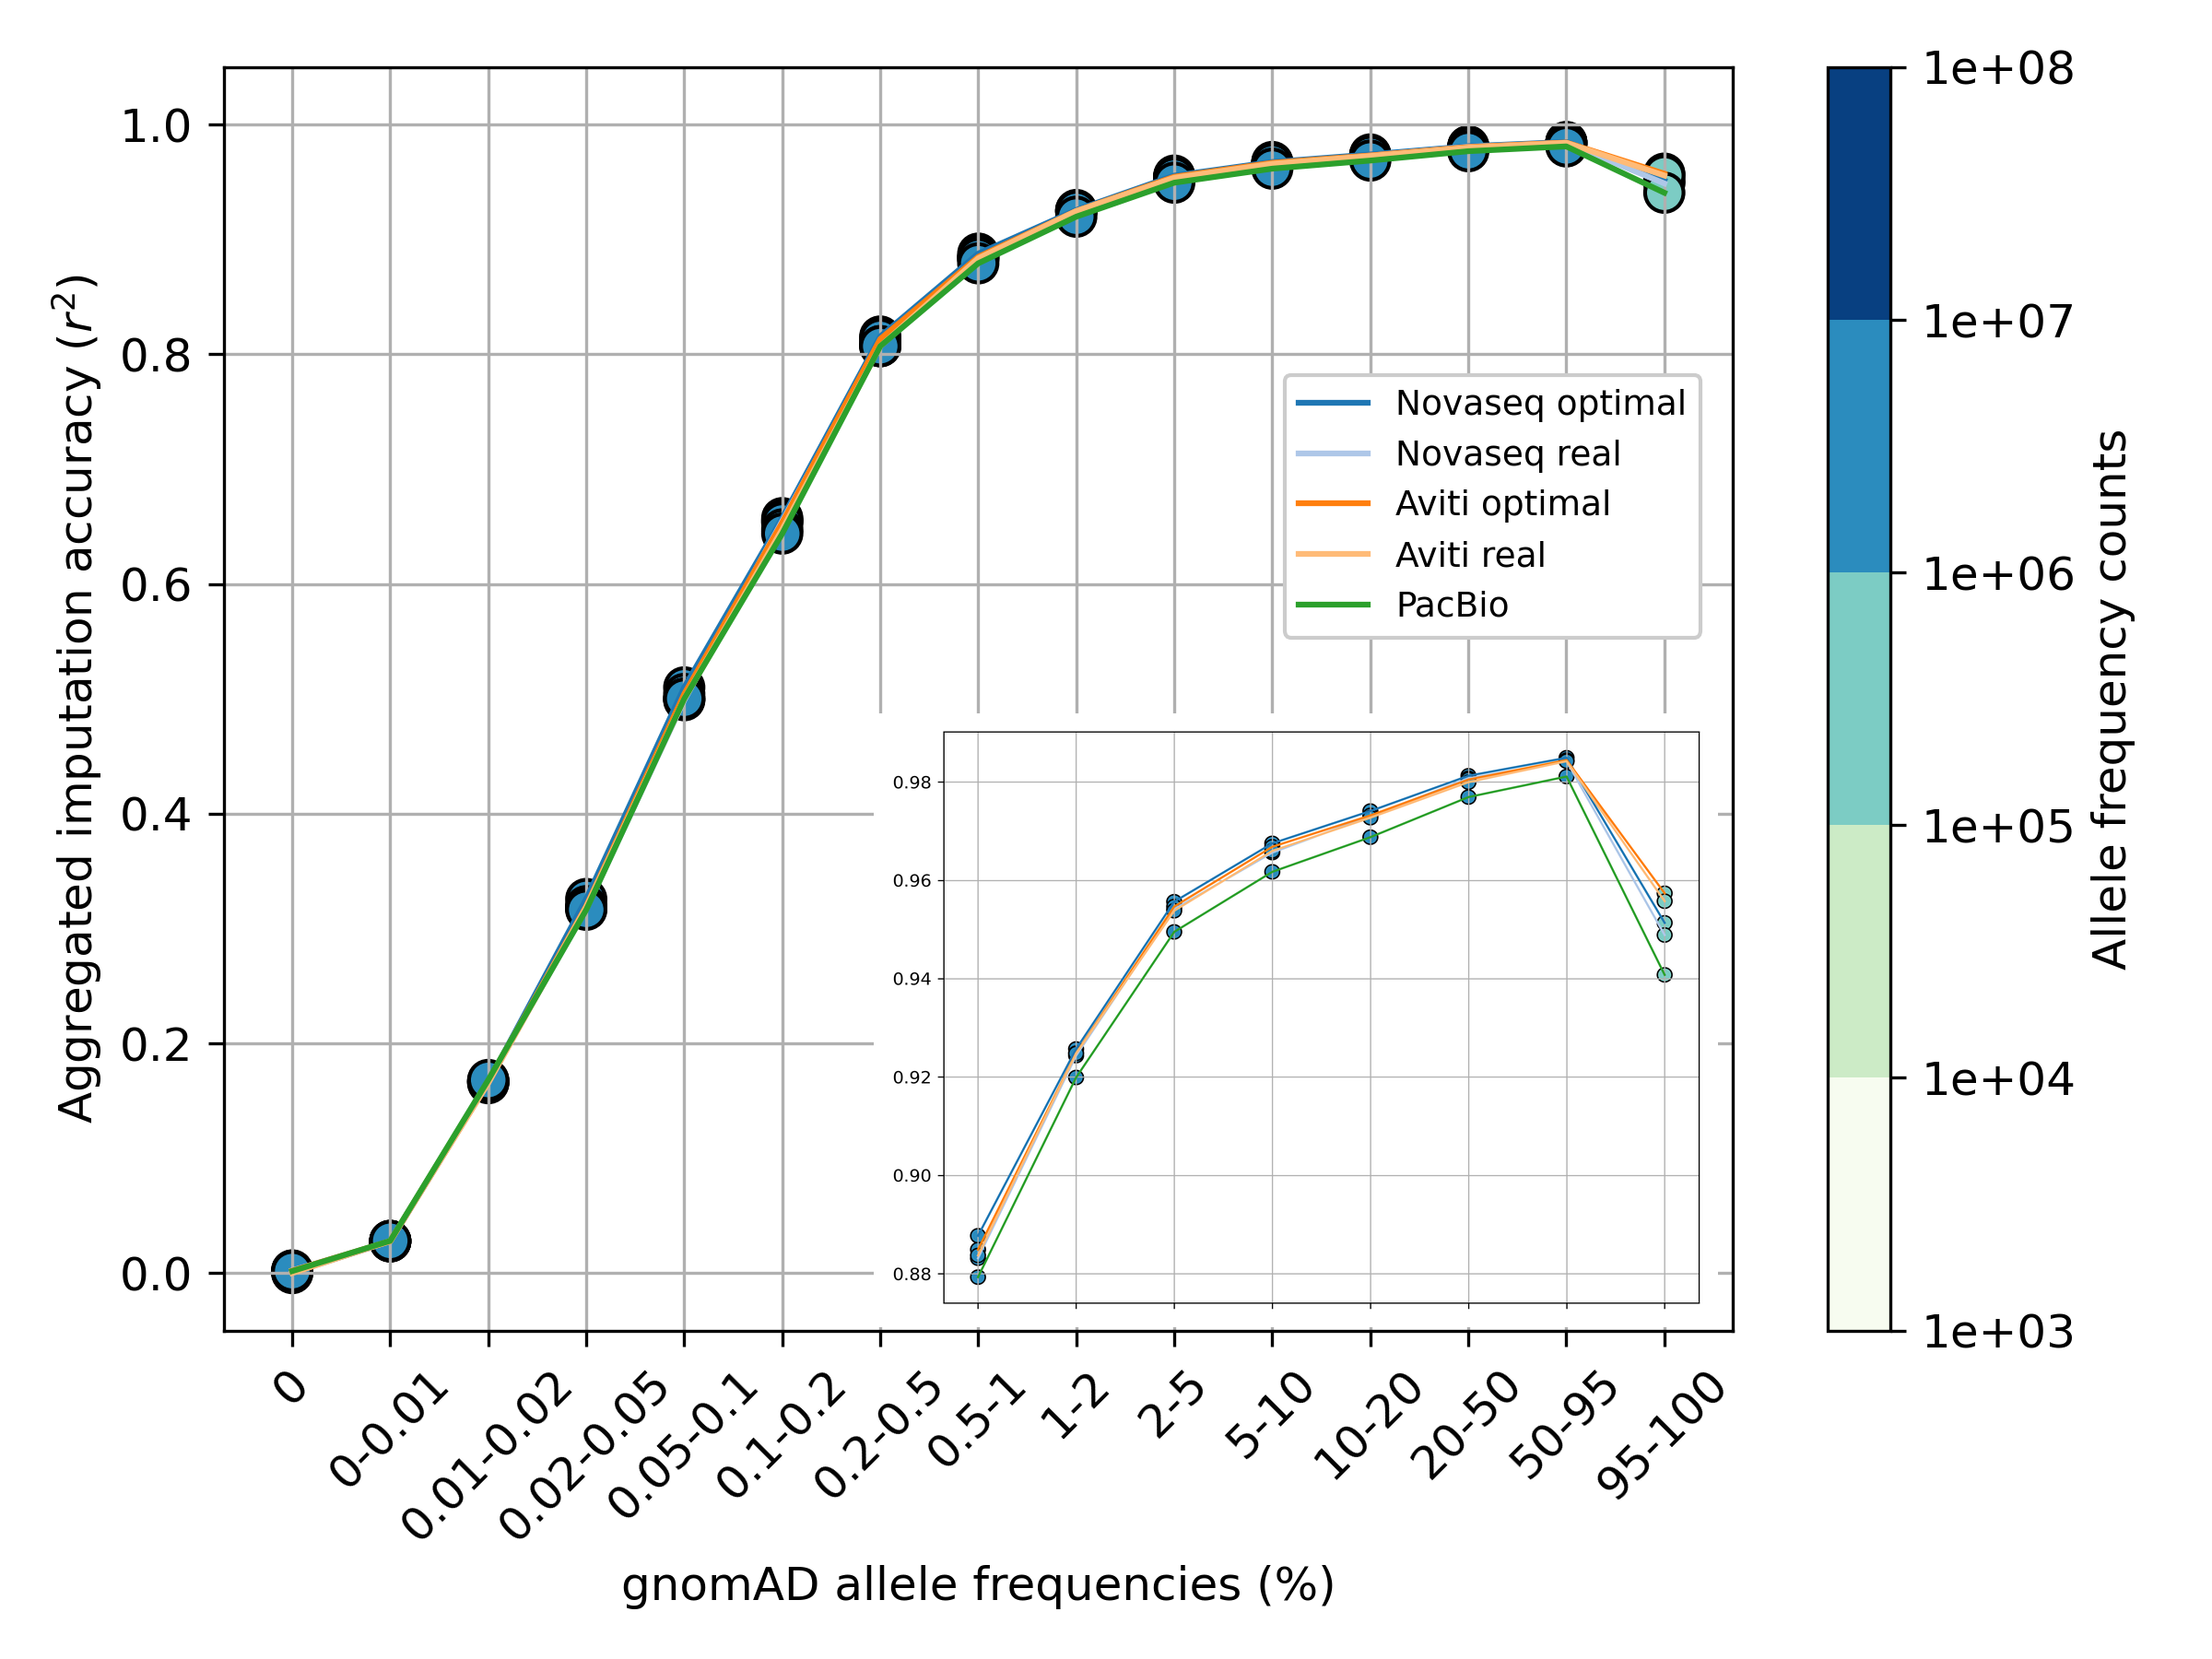

In [72]:
sr_rls = ["Novaseq long", "Novaseq optimal", "Novaseq real", "Novaseq short",
          "Aviti long", "Aviti optimal", "Aviti real", "Aviti short"]
sr_rls_old = ["151-long", "151-optimal", "151-real", "151-short", "300-long", "300-optimal", "300-real", "300-short"]

# sr_vanilla = pd.read_csv("/well/band/users/rbx225/archive/GAMCC_old/imputation_comparison/vanilla/lc_oneKG--hc--snps_gw/impacc/all_samples/by_sample/all.v.impacc.tsv", sep = '\t')
chrs = [pd.read_csv("/well/band/users/rbx225/GAMCC/results/imputation_comparison/sr_simulation/lc_oneKG--hc--snps_gw/impacc/all_samples/by_sample/chr" + i + ".v.tsv", sep = '\t') for i in CHROMOSOMES_ALL]

sr_ary = []
for r in sr_rls_old:
    sr_impaccs = []
    for df in chrs:
        sr_impaccs.append(df[df['sample'] == r].drop(columns = 'sample'))
    sr_ary.append(lcwgsus.average_impacc_by_chr(sr_impaccs))

lr_rls = ['500b']
chrs = [pd.read_csv("/well/band/users/rbx225/GAMCC/results/imputation_comparison/lr_simulation/lc_oneKG--hc--snps_gw/impacc/all_samples/by_sample/chr" + i + ".v.tsv", sep = '\t') for i in CHROMOSOMES_ALL]
lr_ary = []
for r in lr_rls:
    lr_impaccs = []
    for df in chrs:
        lr_impaccs.append(df[df['sample'] == r].drop(columns = 'sample'))
    lr_ary.append(lcwgsus.average_impacc_by_chr(lr_impaccs))

ixs = [1,2,5,6,8]
labels = [(sr_rls + ['PacBio'])[i] for i in ixs]
dfs = [(sr_ary + lr_ary)[i] for i in [1,2,5,6,8]]
title = ''
threshold = 0.01

save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'sf5a.png'

fig1 = lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
fig2 = lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = threshold, title = title, set_ylim = False, subplot = True)
lcwgsus.combine_imputation_accuracy_plots(fig1, fig2, 
                                       threshold = threshold, 
                                       save_fig = save_fig, 
                                       outdir = outdir, 
                                       save_name = save_name)

# ixs = [1,2,5,6]
# labels = [sr_rls[i] for i in ixs]
# dfs = sr_ary
# title = ''
# t = 0.01

# save_fig = True
# save_prefix = 'sf4a'
# res = lcwgsus.plot_imputation_accuracy_sequential(ixs, dfs, labels, title, t,
#                                          save_fig = save_fig, outdir = outdir, save_prefix = save_prefix)
# res[-1]

## SF5b: Long-read

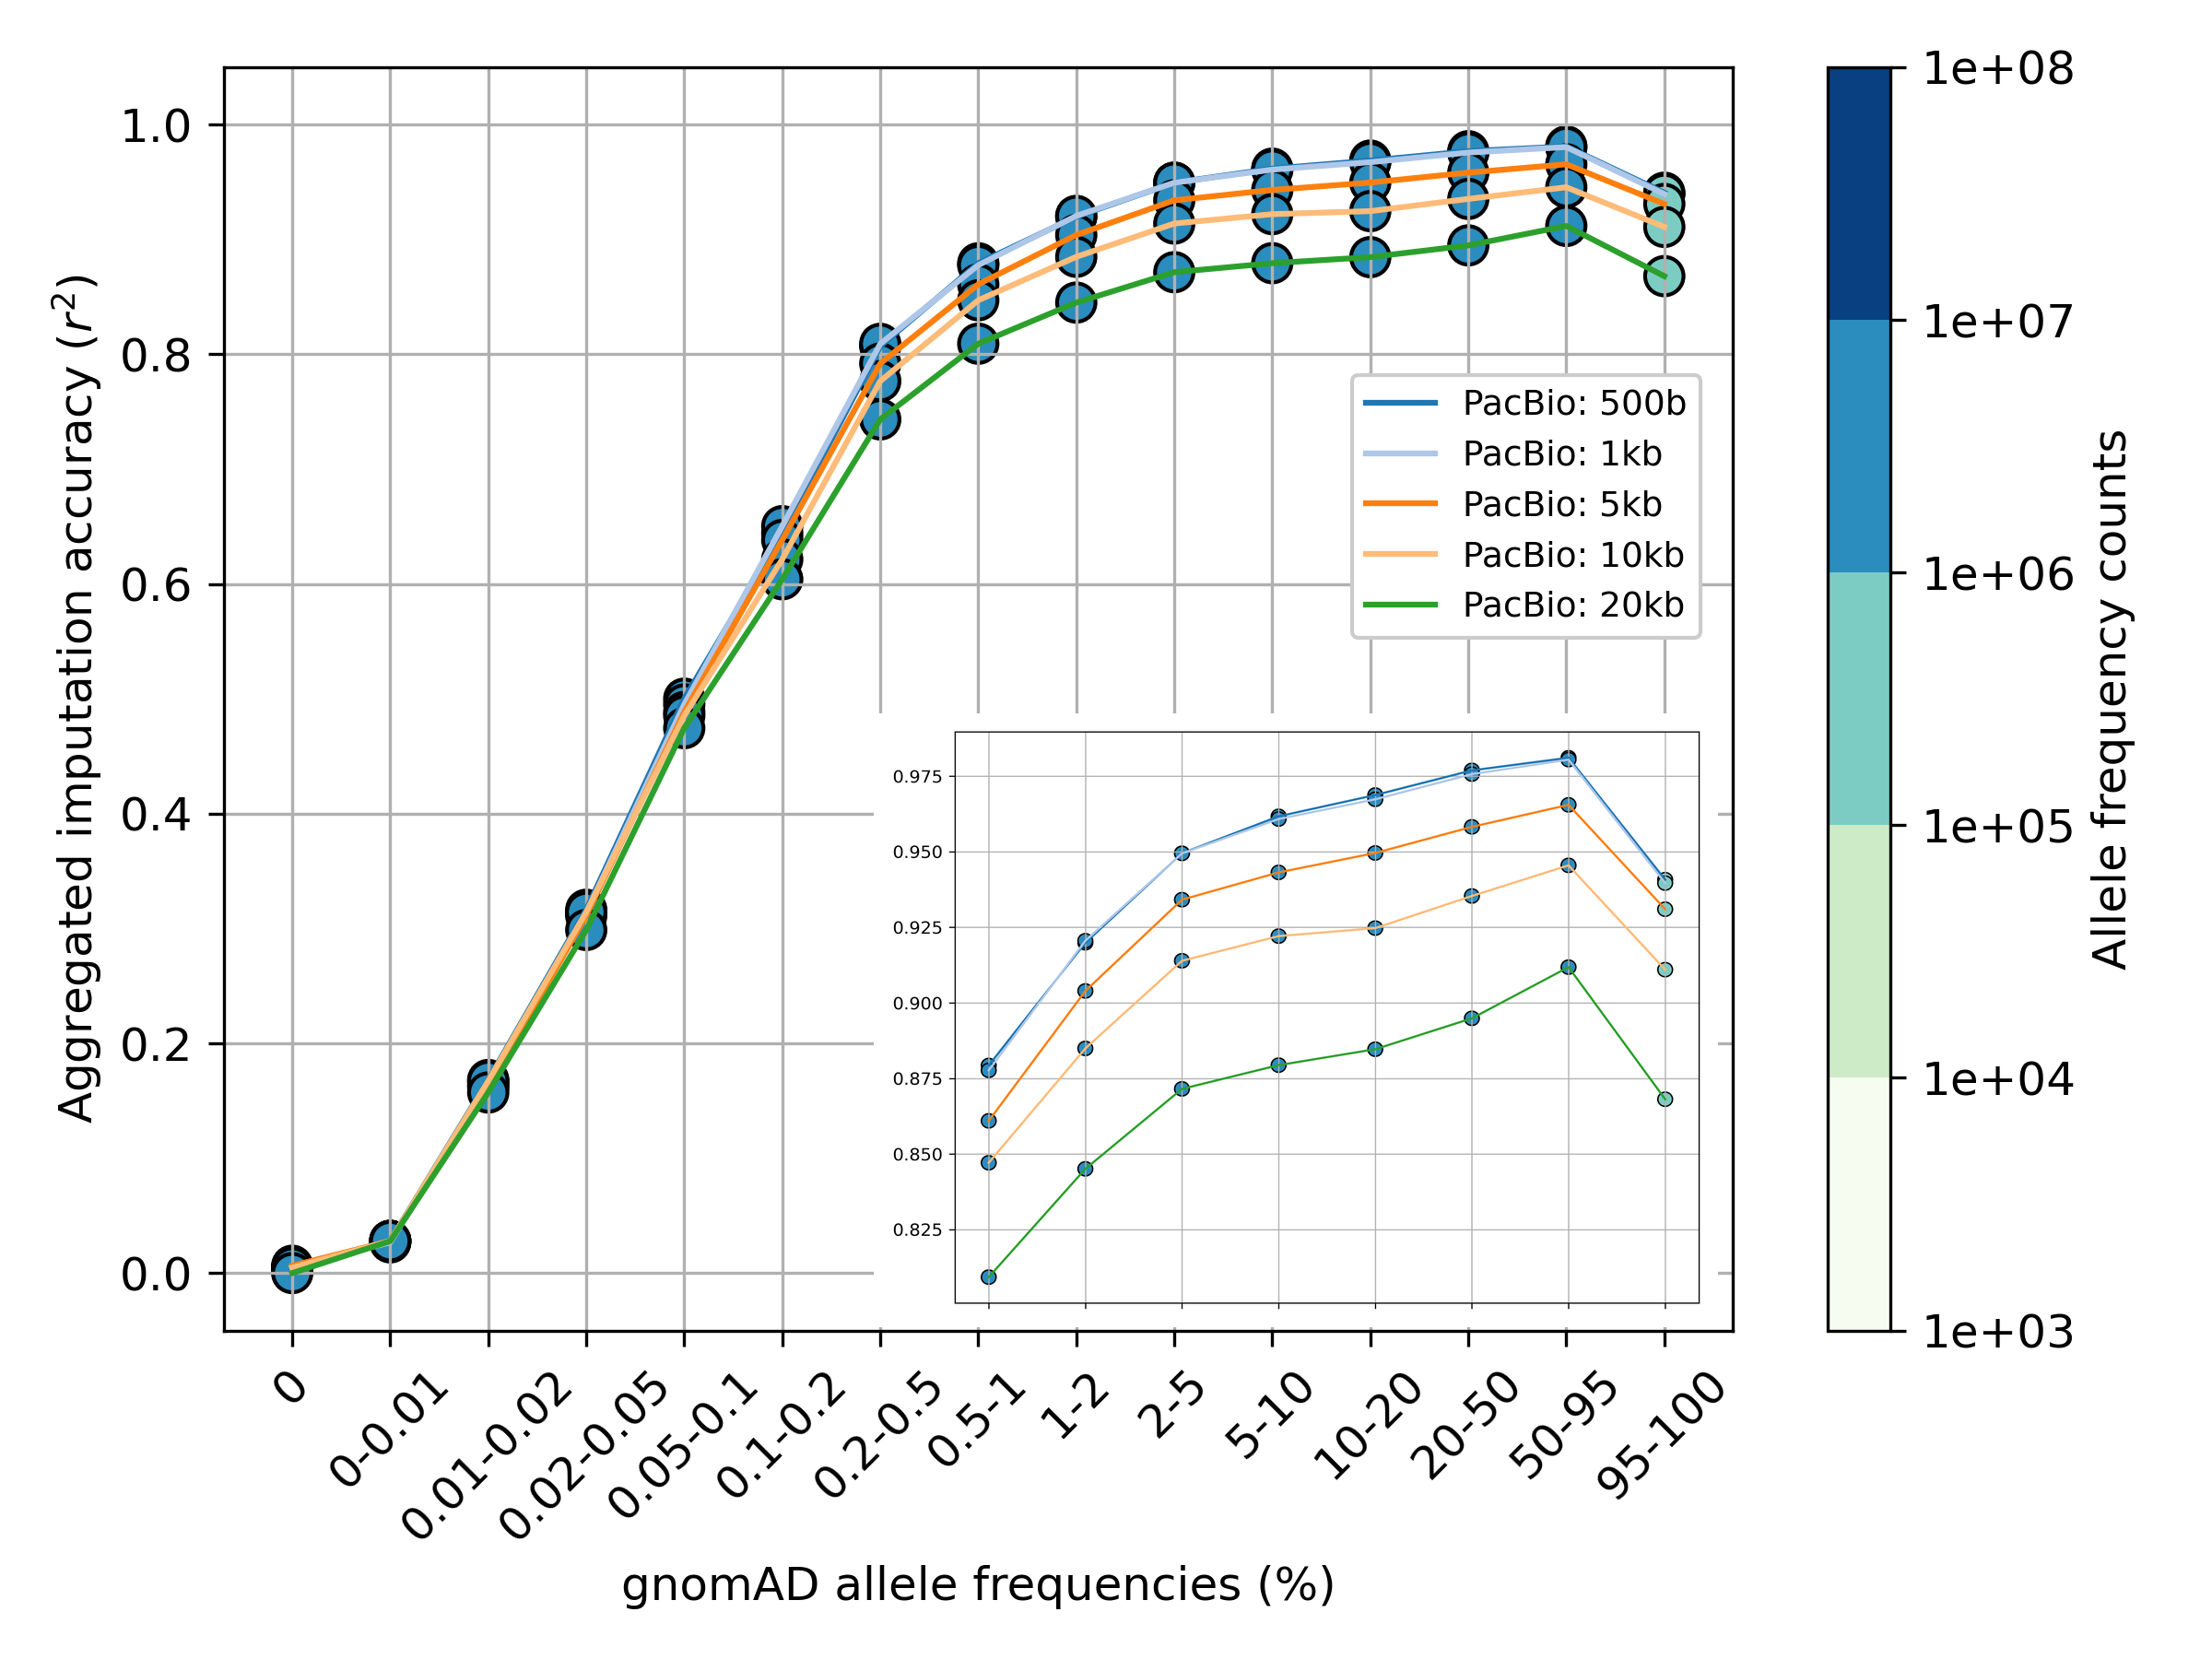

In [74]:
lr_rls = ['500b', '1kb', '5kb', '10kb', '20kb']

chrs = [pd.read_csv("/well/band/users/rbx225/GAMCC/results/imputation_comparison/lr_simulation/lc_oneKG--hc--snps_gw/impacc/all_samples/by_sample/chr" + i + ".v.tsv", sep = '\t') for i in CHROMOSOMES_ALL]

lr_ary = []
for r in lr_rls:
    lr_impaccs = []
    for df in chrs:
        lr_impaccs.append(df[df['sample'] == r].drop(columns = 'sample'))
    lr_ary.append(lcwgsus.average_impacc_by_chr(lr_impaccs))

dfs = lr_ary
labels = ['PacBio: 500b', 'PacBio: 1kb', 'PacBio: 5kb', 'PacBio: 10kb', 'PacBio: 20kb']
title = ''
threshold = 0.01

save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'sf5b.png'

fig1 = lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
fig2 = lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = threshold, title = title, set_ylim = False, subplot = True)
lcwgsus.combine_imputation_accuracy_plots(fig1, fig2, 
                                       threshold = threshold, 
                                       save_fig = save_fig, 
                                       outdir = outdir, 
                                       save_name = save_name)

# save_fig = True
# save_prefix = 'sf4b'
# res = lcwgsus.plot_imputation_accuracy_sequential([0, 1, 2, 3, 4], dfs, labels, title, t,
#                                          save_fig = save_fig, outdir = outdir, save_prefix = save_prefix)
# res[-1]

# SF6 Phasing GAMCC

In [80]:
def plot_phase(return_dict, ix, title = '', colors = CATEGORY_CMAP_HEX, ax = None):
    oldphase1, oldphase2, phased1, phased2 = return_dict['initial_phase_res']
    phased1, phased2 = return_dict['phases_ary'][ix]
    
    np.random.seed(42)
    jitter1 = np.random.normal(loc=0, scale=0.4, size=len(phased1))
    jitter2 = np.random.normal(loc=0, scale=0.4, size=len(phased1))
    oldphase1 = oldphase1 + jitter1
    oldphase2 = oldphase2 + jitter2
    
    gene = return_dict['gene']
    hlatypes = return_dict['hlatypes']
    tmp = hlatypes[(hlatypes[f'HLA-{gene} 1'] != hlatypes[f'HLA-{gene} 2'])]

    phase1_indices = np.intersect1d(np.where(phased1)[0], tmp.index)
    phase2_indices = np.intersect1d(np.where(phased2)[0], tmp.index)
    unphased_indices = np.intersect1d(np.where(~phased1 & ~phased2)[0], tmp.index)
    
    swap_mask = oldphase1 > oldphase2
    oldphase1_swapped = np.where(swap_mask, oldphase2, oldphase1)
    oldphase2_swapped = np.where(swap_mask, oldphase1, oldphase2)

    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(oldphase1[phase1_indices], oldphase2[phase1_indices], alpha = 0.5, c=colors[0], ec = 'black', label = 'phased')
    ax.scatter(oldphase2[phase2_indices], oldphase1[phase2_indices], alpha = 0.5, c=colors[0], ec = 'black')
    ax.scatter(oldphase1_swapped[unphased_indices], oldphase2_swapped[unphased_indices], 
            alpha=0.5, c=colors[2], ec='black', label='unphased')
    
    ymax = max(np.nan_to_num(oldphase1, nan=0).max(), np.nan_to_num(oldphase2, nan=0).max())
    if ix == 0:
        ax.plot([-1, 2], [1, 4], linestyle = '--', color = 'black')
        ax.plot([2, 4], [4, 4], linestyle = '--', color = 'black')
        ax.plot([4, 4], [4, ymax], linestyle = '--', color = 'black')
    else:
        xmax = ax.get_xlim()[1]
        ax.plot([0, xmax], [0, xmax], linestyle = '--', color = 'black')
    
    N = len(tmp)
    unphased_percentage = np.round((N-len(unphased_indices))*100/N, 1)

    if title != '':
        ax.set_title(f'Step {ix}: {unphased_percentage}% of {N} samples are phased')
    else:
        ax.set_title(title)
    ax.legend()
    ax.set_xlabel('# Mismatch true phase')
    ax.set_ylabel('# Mismatch wrong phase')
    return None

In [81]:
ipd_gen_file_dir = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments_v3570/'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')
samples_to_remove = []

gamcc_hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv', unique_two_field = True)
gamcc_hla = gamcc_hla[['SampleID', 'Locus', 'Two field1', 'Two field2']].reset_index(drop = True)

colnames = ['Sample ID'] + [label for g in HLA_GENES for label in [f'HLA-{g} 1', f'HLA-{g} 2']]
hlatypes = pd.DataFrame(columns = colnames)
for s in gamcc_hla['SampleID'].unique():
    tmp = gamcc_hla[gamcc_hla['SampleID'] == s]
    row = [s] + tmp[['Two field1', 'Two field2']].values.ravel().tolist()
    hlatypes.loc[len(hlatypes)] = row

reference_allele_file = '/well/band/users/rbx225/recyclable_files/hla/b38_reference_alleles.tsv'
reference_allele_ary = np.array(lcwgsus.read_tsv_as_lst(reference_allele_file))
# phased_vcf = "/well/band/users/rbx225/GAMCC/results/two-stage-imputation/vanilla/malariaGen_v1_b38_topmed/vcf/chr6.dose.vcf.gz"
phased_vcf = '/well/band/users/rbx225/GAMCC/results/imputation/vcfs/malariaGen_v1_b38/quilt.chr6.vcf.gz'

subset_vcf_samples = lcwgsus.read_tsv_as_lst('/well/band/users/rbx225/GAMCC/data/sample_tsvs/fv_gm_names.tsv')
subset_vcf_samples = ','.join(subset_vcf_samples)

sample_linker = pd.read_csv(SAMPLE_LINKER_FILE)
sample_linker = {k:v for k, v in zip(sample_linker['Sample_Name'], sample_linker['Chip_Name'])}

return_dict_ary = []
metrics = pd.DataFrame(columns = ['Gene', 'Length', 'n_SNP', 'n_heterozygous', 'n_phased'])
for gene in HLA_GENES:
    return_dict = phase_hla_on_haplotypes(gene = gene, 
                                ipd_gen_file_dir = ipd_gen_file_dir, 
                                hla_gene_information = hla_gene_information, 
                                hlatypes = hlatypes,
                                phased_vcf = phased_vcf, 
                                reference_allele_ary = reference_allele_ary, 
                                read_from_QUILT = True, 
                                subset_vcf_samples = subset_vcf_samples,
                                sample_linker = sample_linker)
        
    return_dict_ary.append(return_dict)

    ix = hla_gene_information[hla_gene_information['Name'] == f'HLA-{gene}'].index[0]
    length = (hla_gene_information['End'] - hla_gene_information['Start']).loc[ix]
    n_snp = len(return_dict['merged_snps'])
    n_heterozygous = len(hlatypes[(hlatypes[f'HLA-{gene} 1'] != hlatypes[f'HLA-{gene} 2'])])
    n_phased = n_heterozygous-len(return_dict['unphased_df'])

    metrics.loc[len(metrics)] = [gene, length, n_snp, n_heterozygous, n_phased]

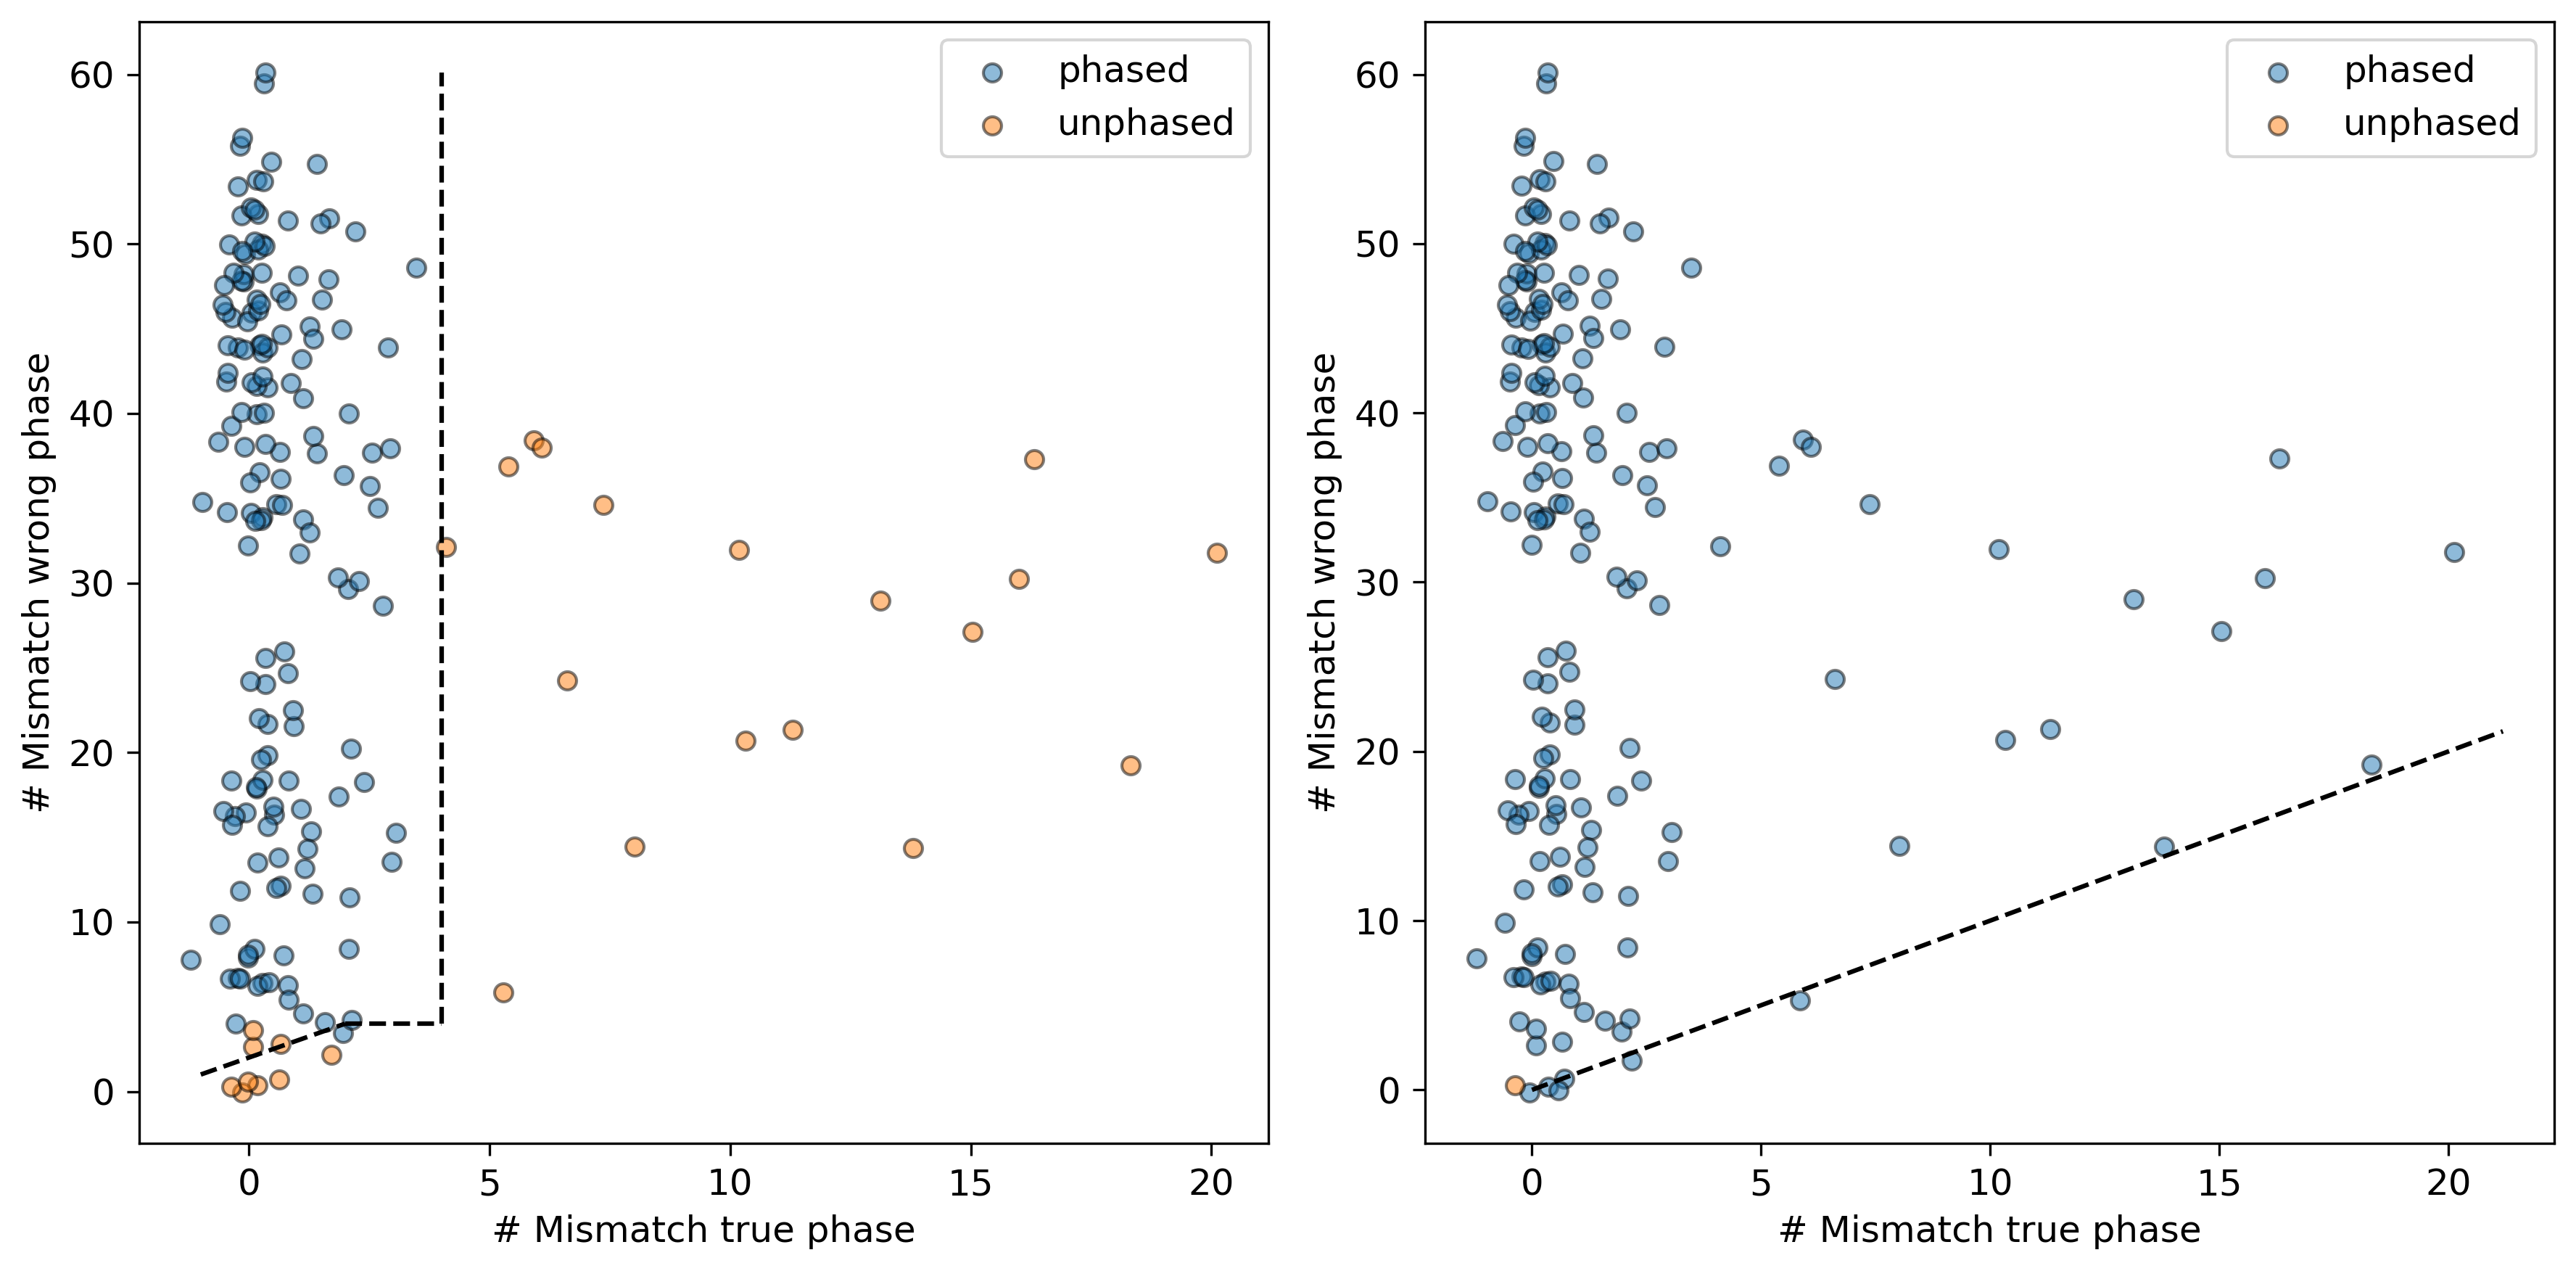

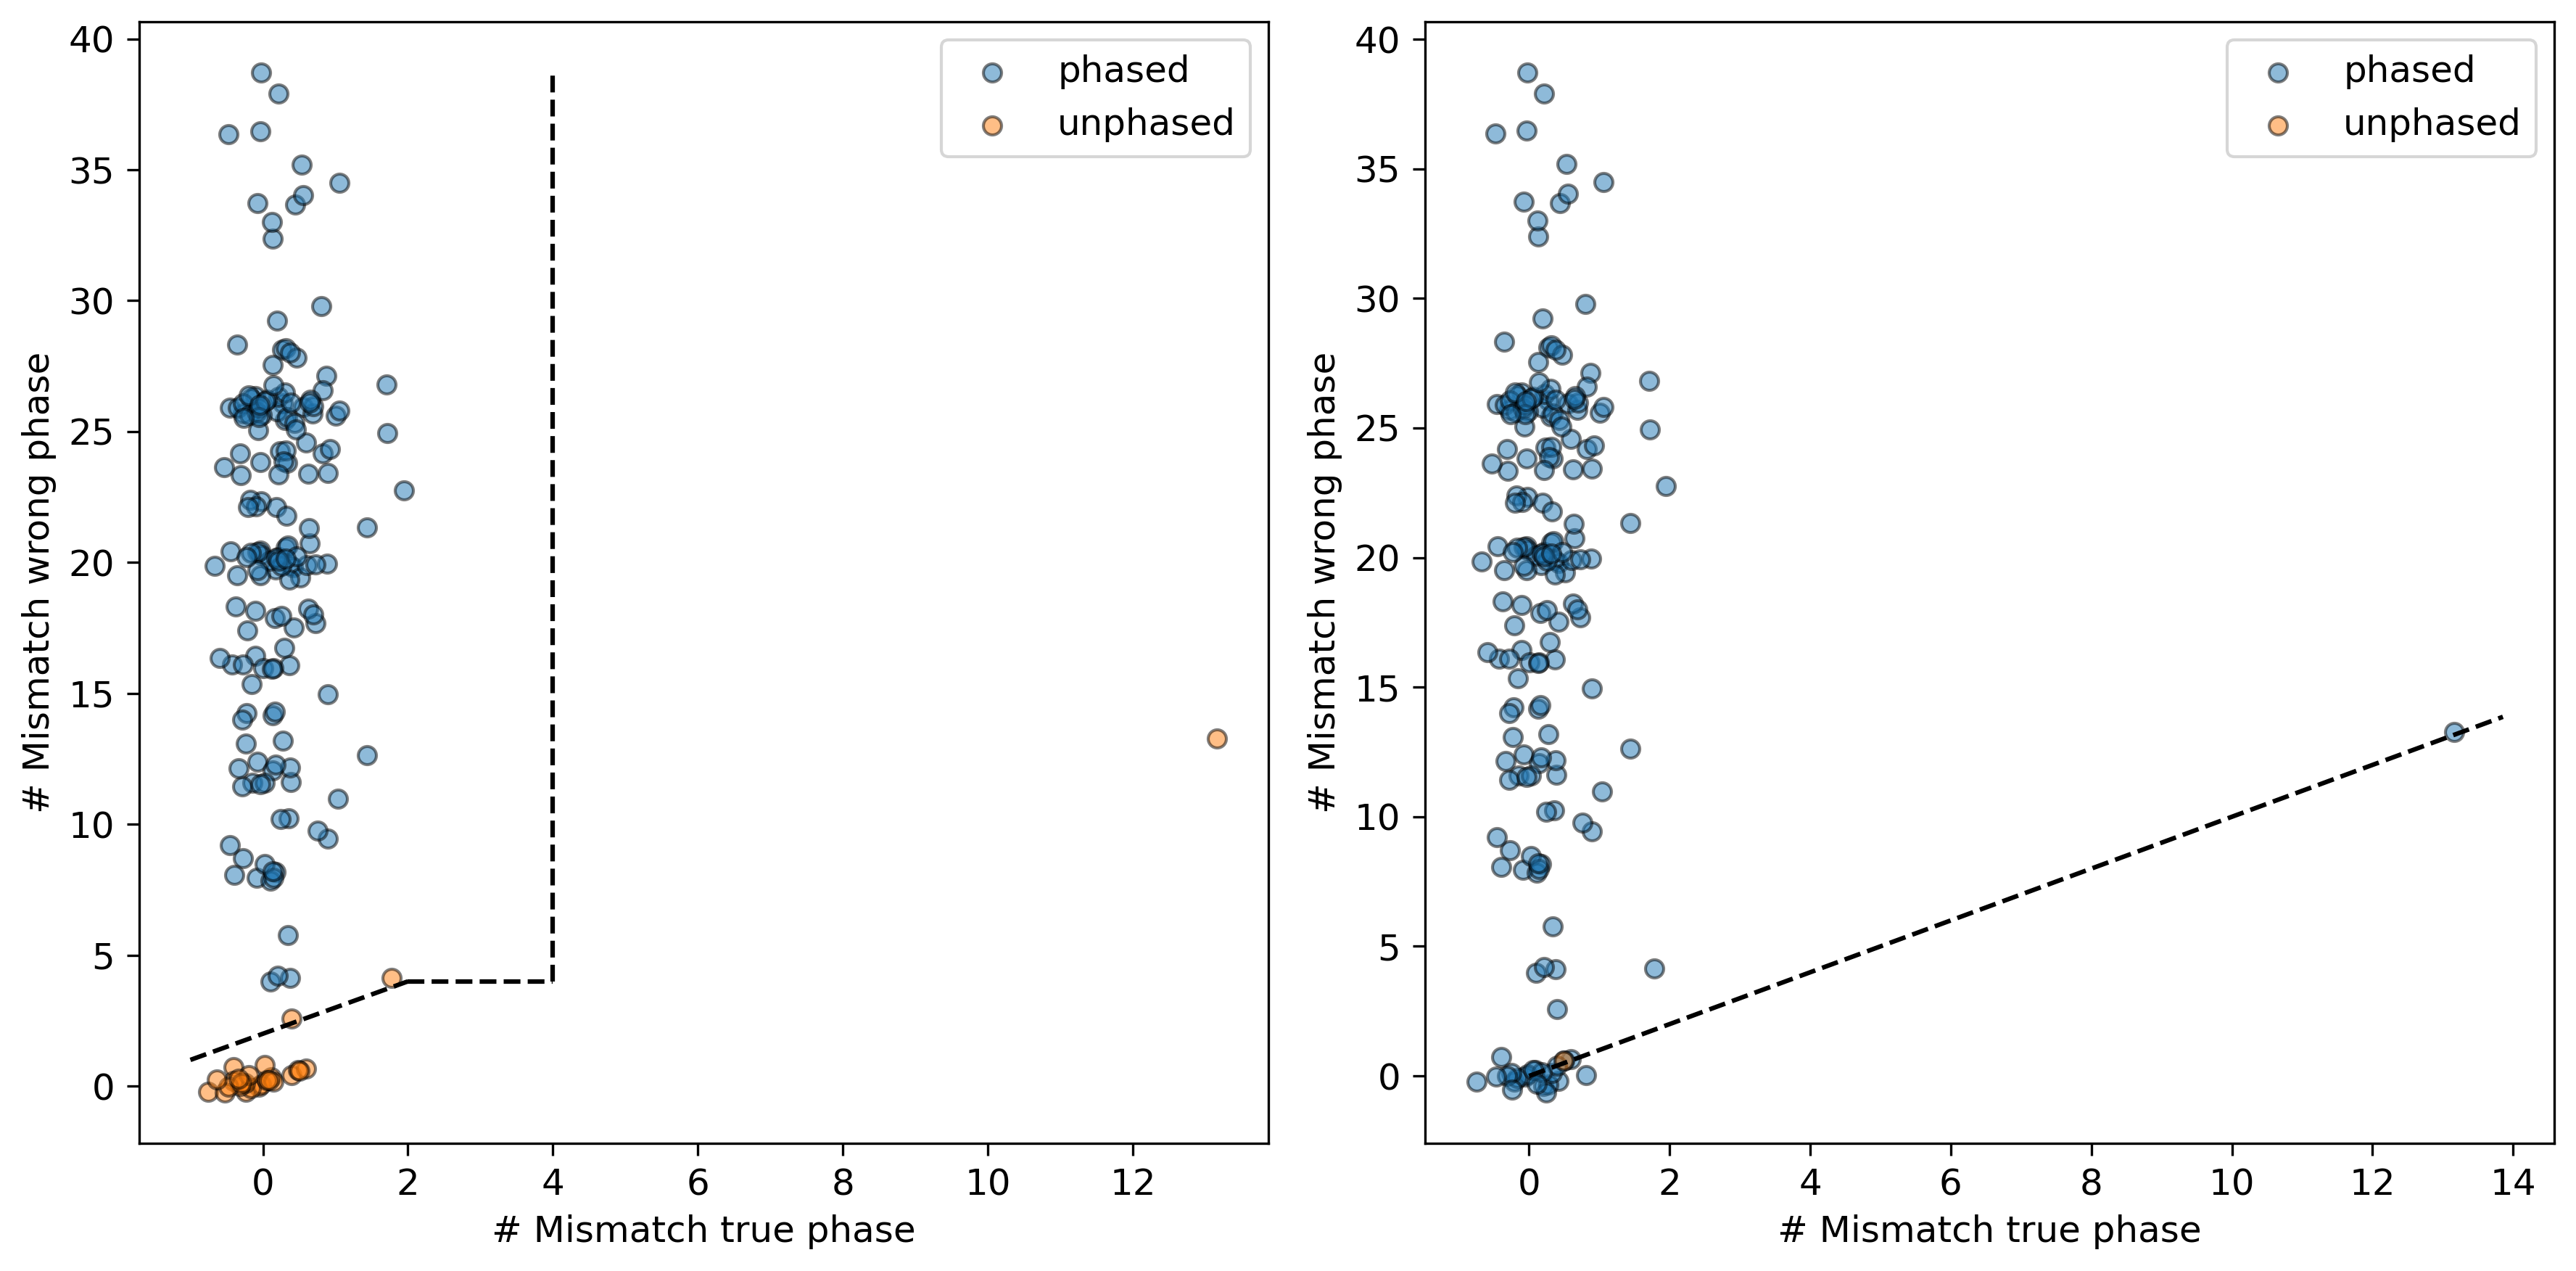

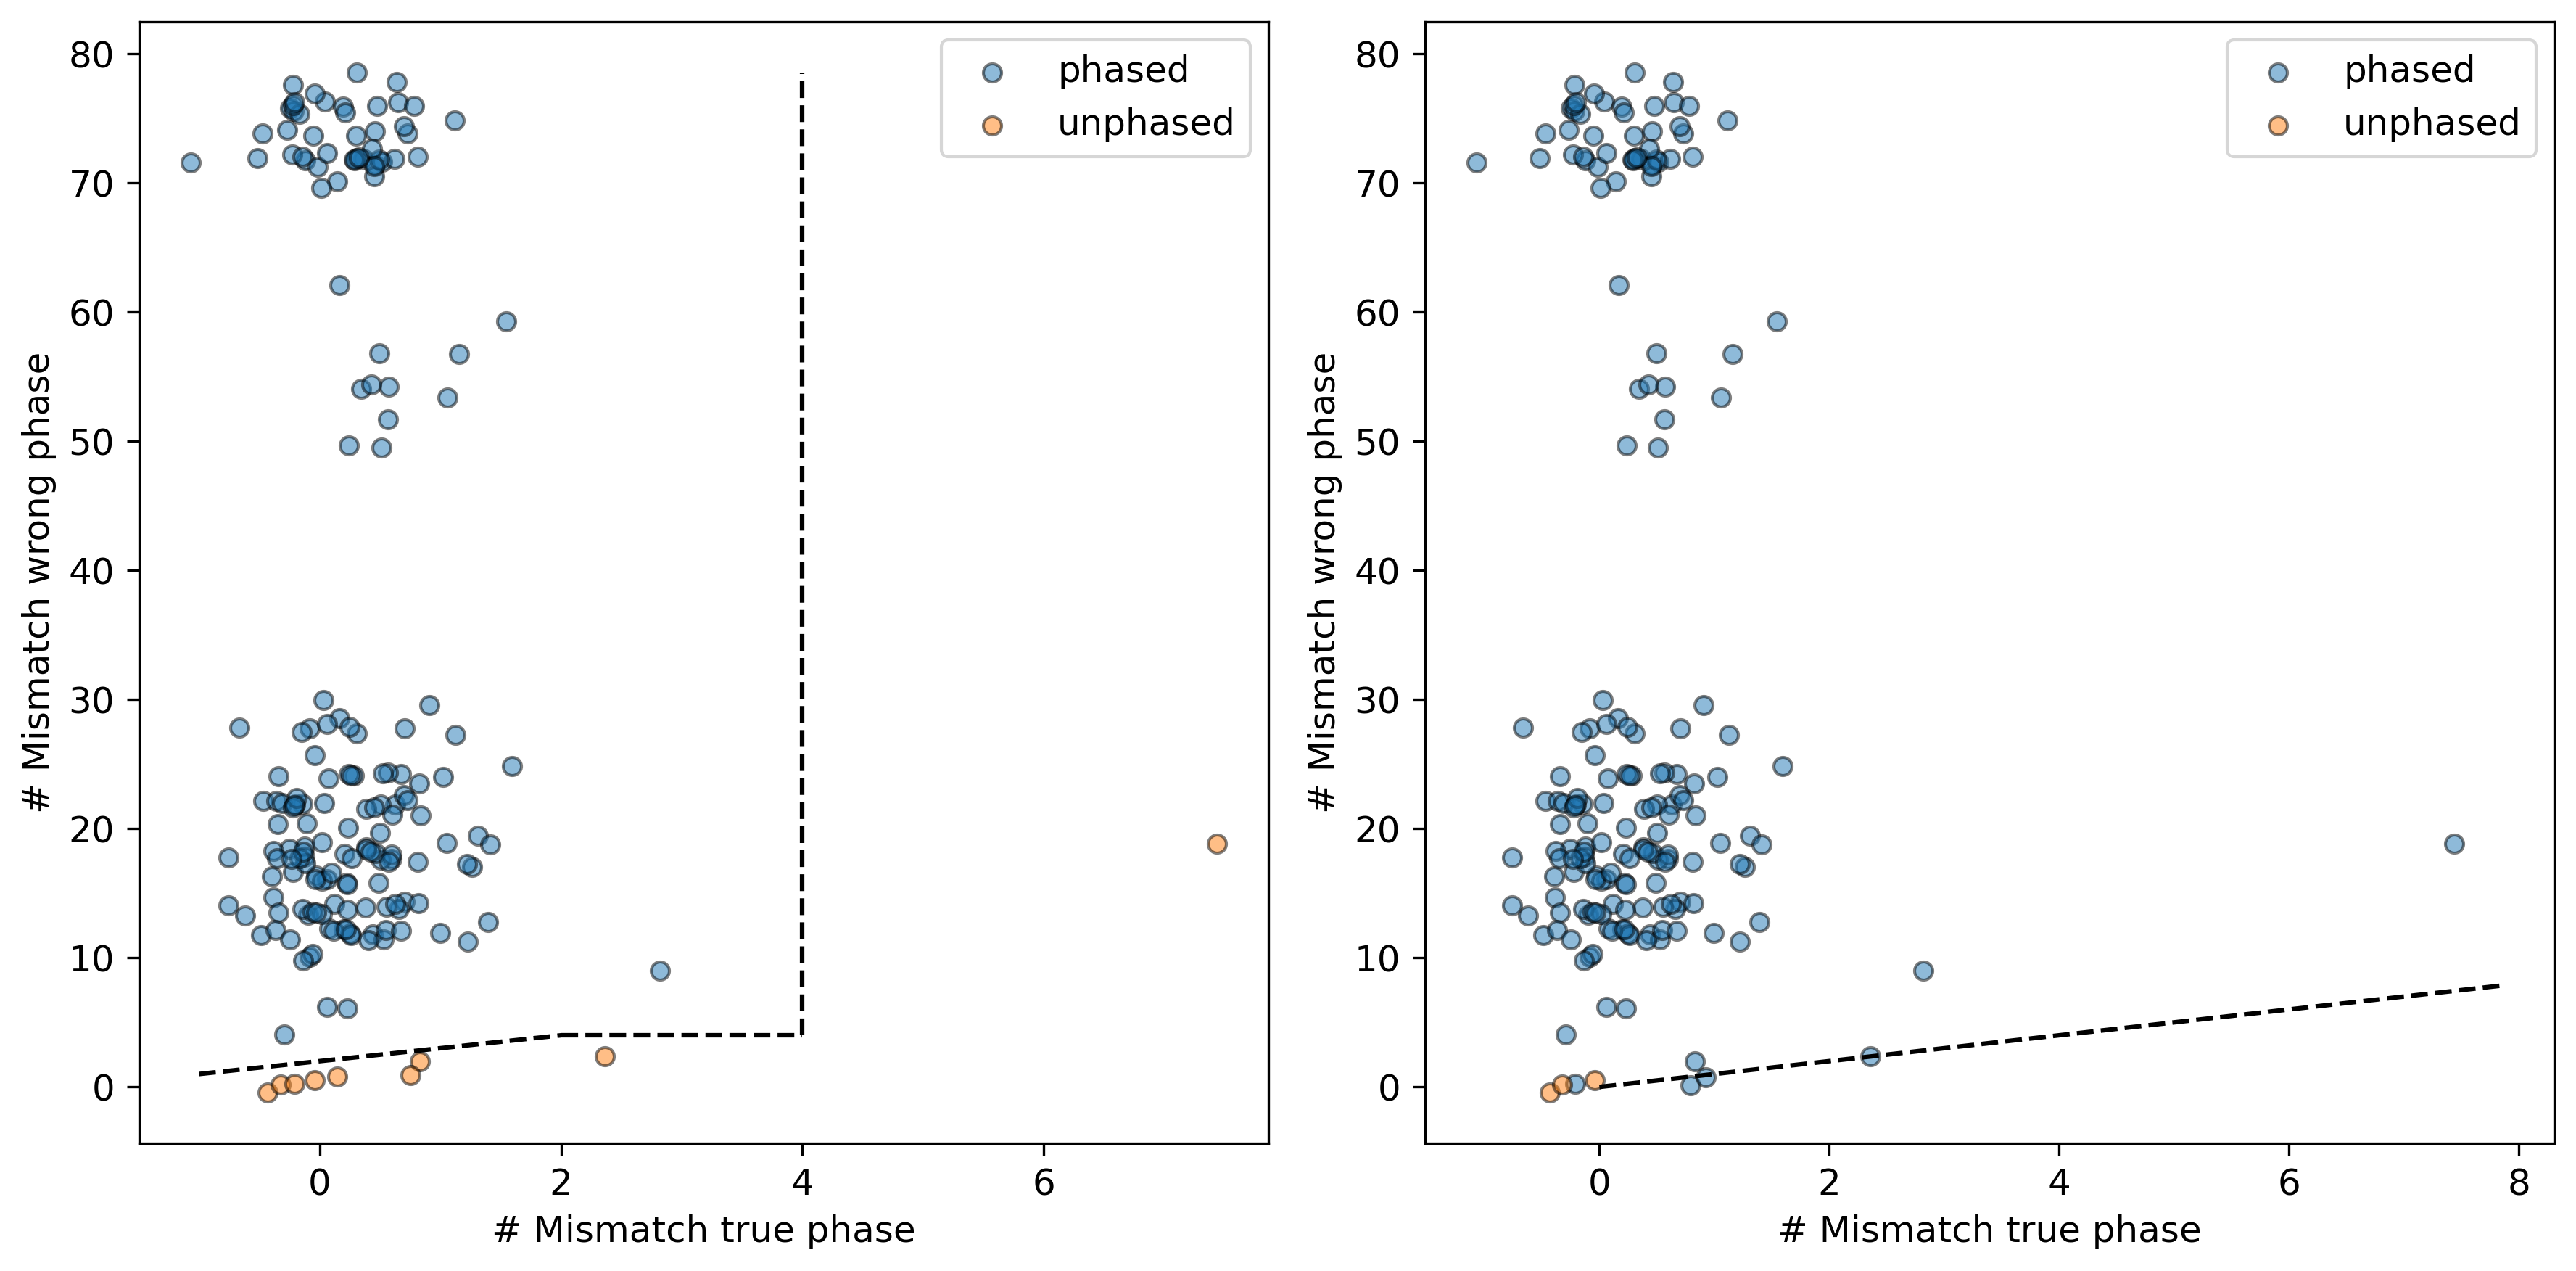

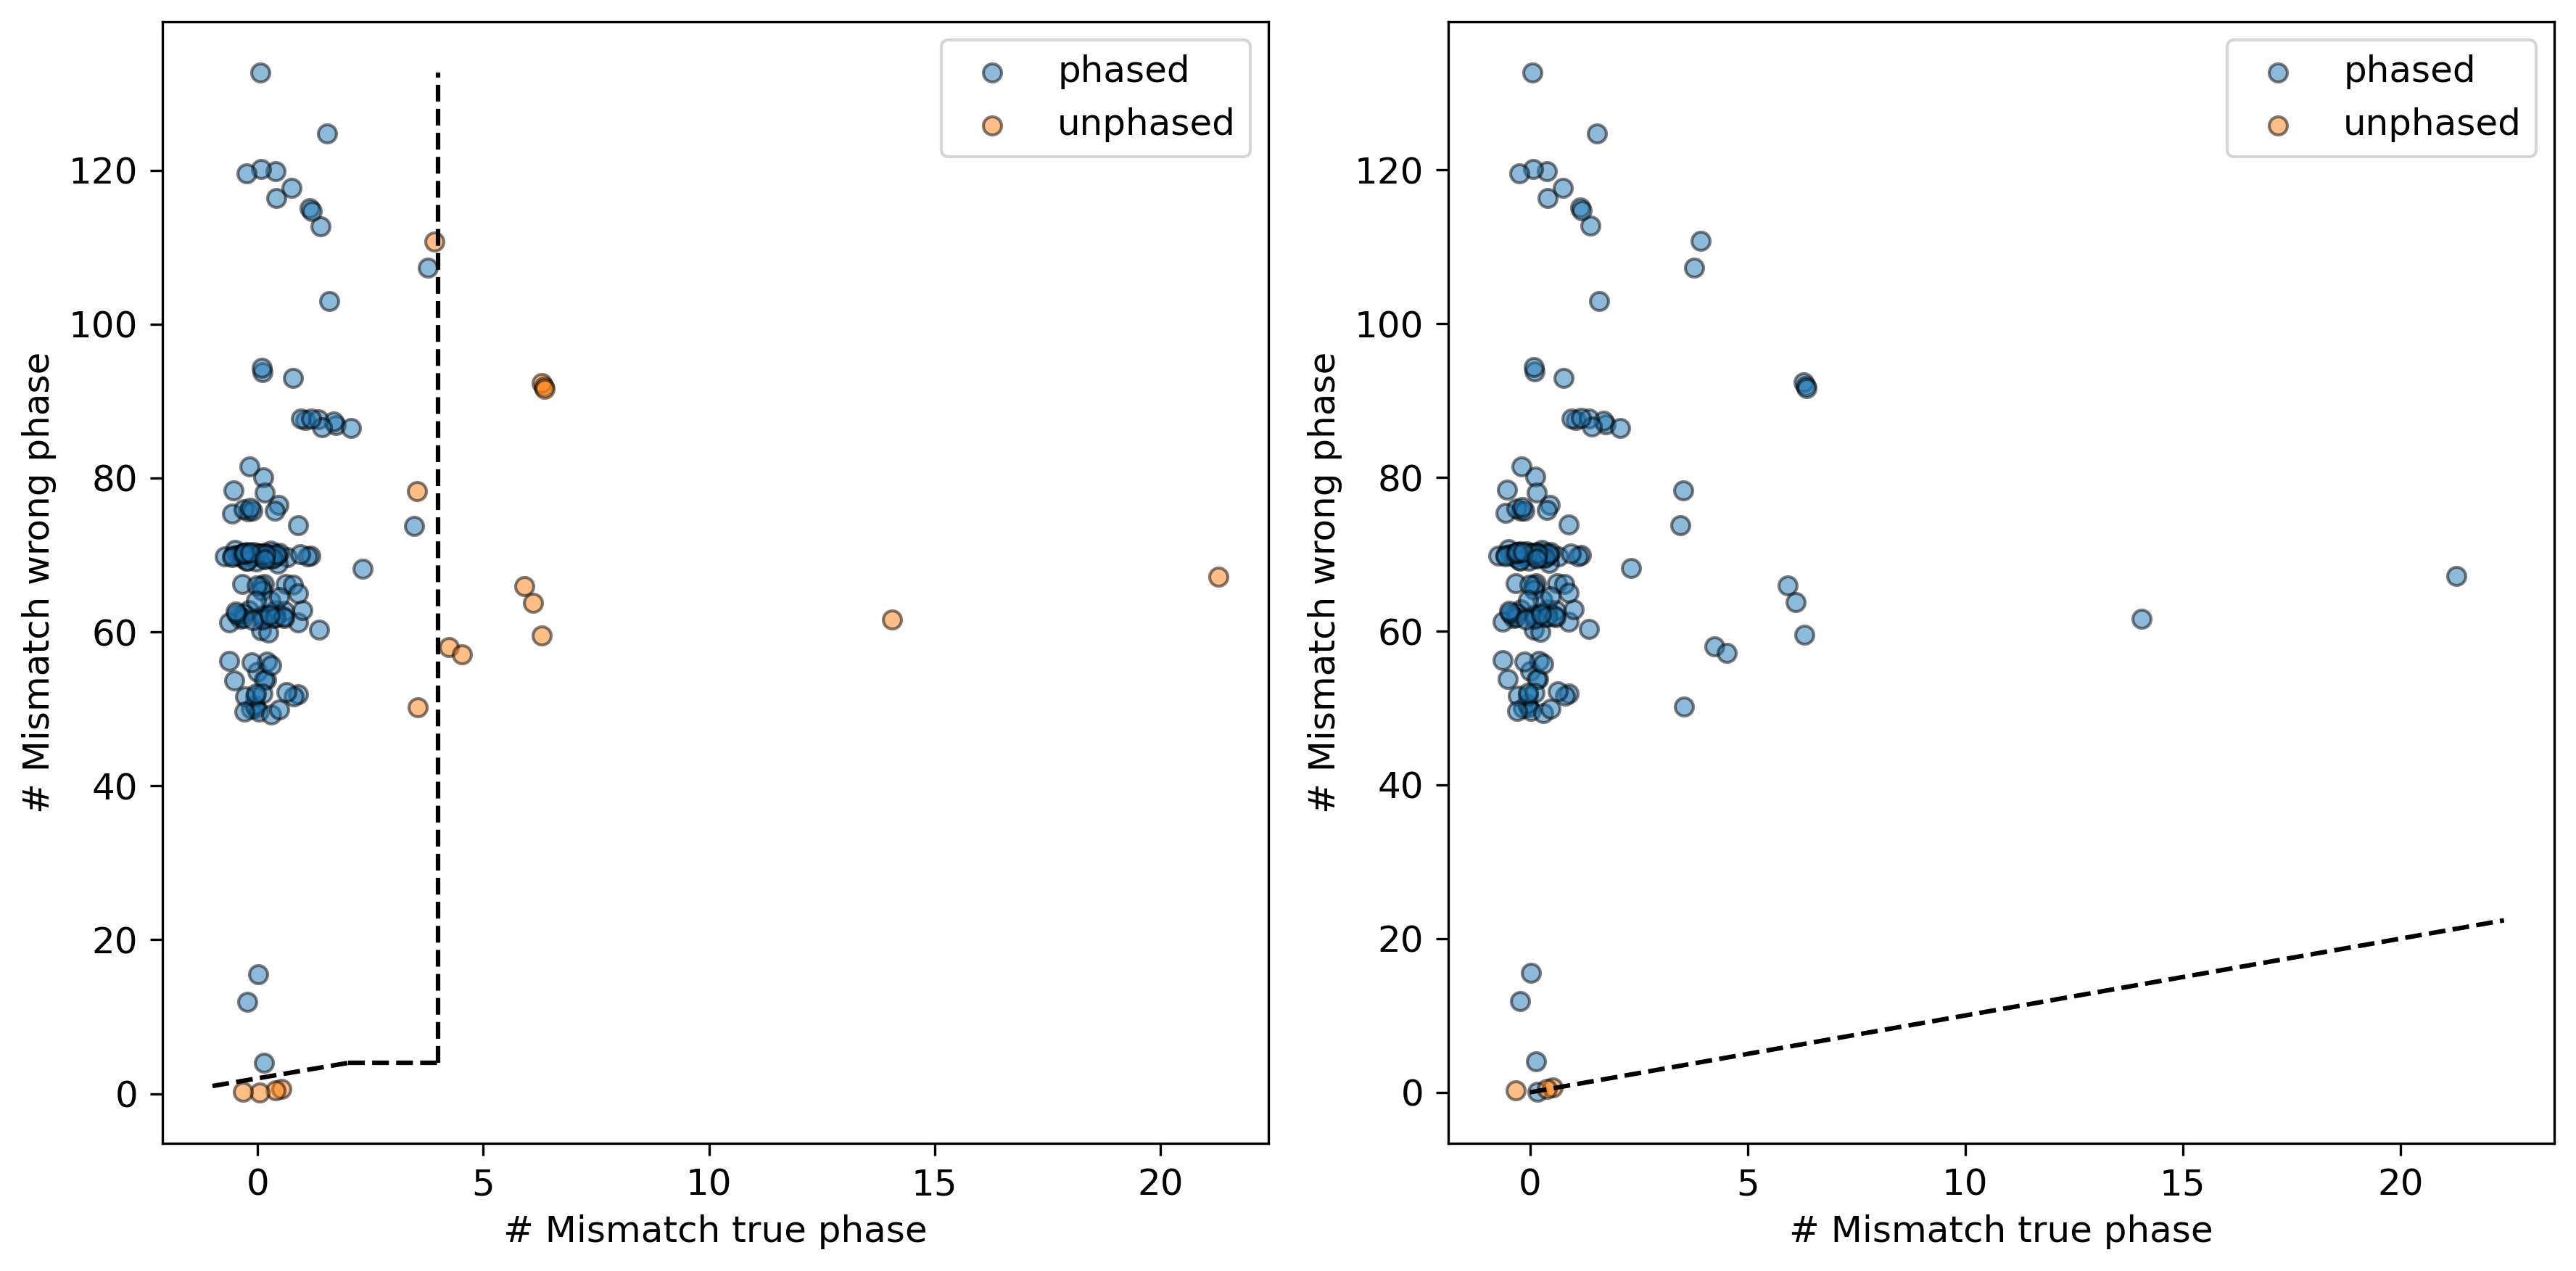

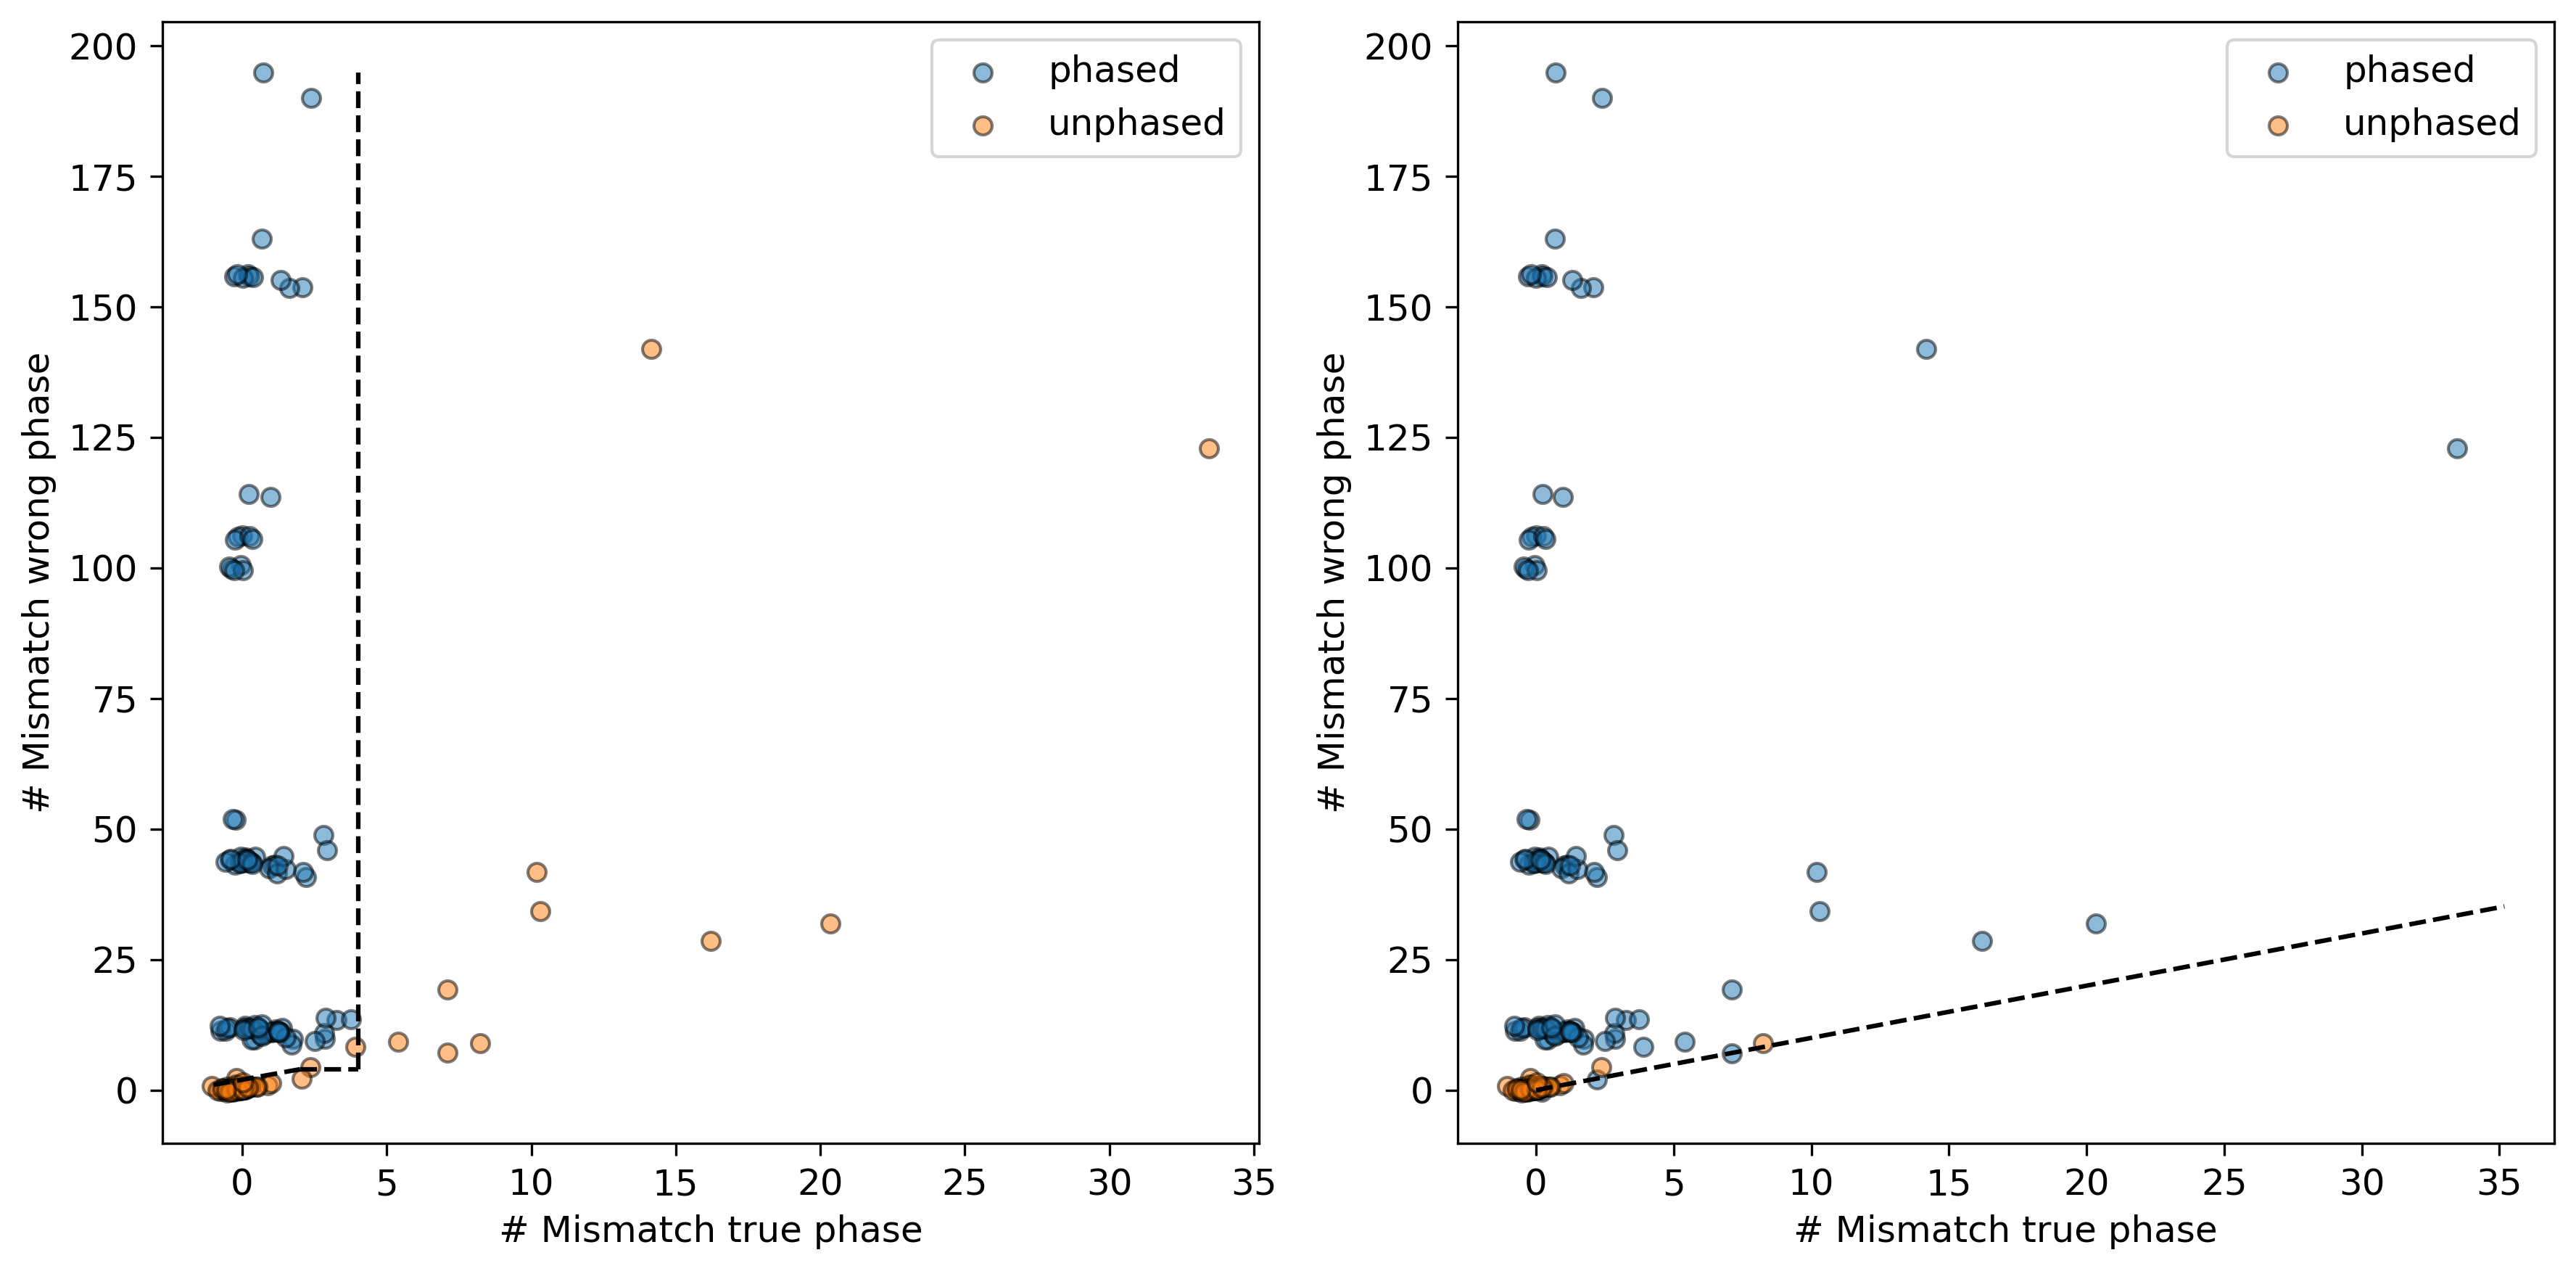

In [86]:
suffix = ['a', 'b', 'c', 'd', 'e']
for i, (gene, r) in enumerate(zip(HLA_GENES, return_dict_ary)):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi = 300)

    plot_phase(r, 0, ax=axes[0], title = '')
    plot_phase(r, -1, ax=axes[1], title = '')

    plt.tight_layout()
    
    save_fig = True
    outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
    save_name = f'sf6{suffix[i]}.png'
    
    lcwgsus.save_figure(save_fig, outdir, save_name)
    plt.show()

# SF7 n_reads

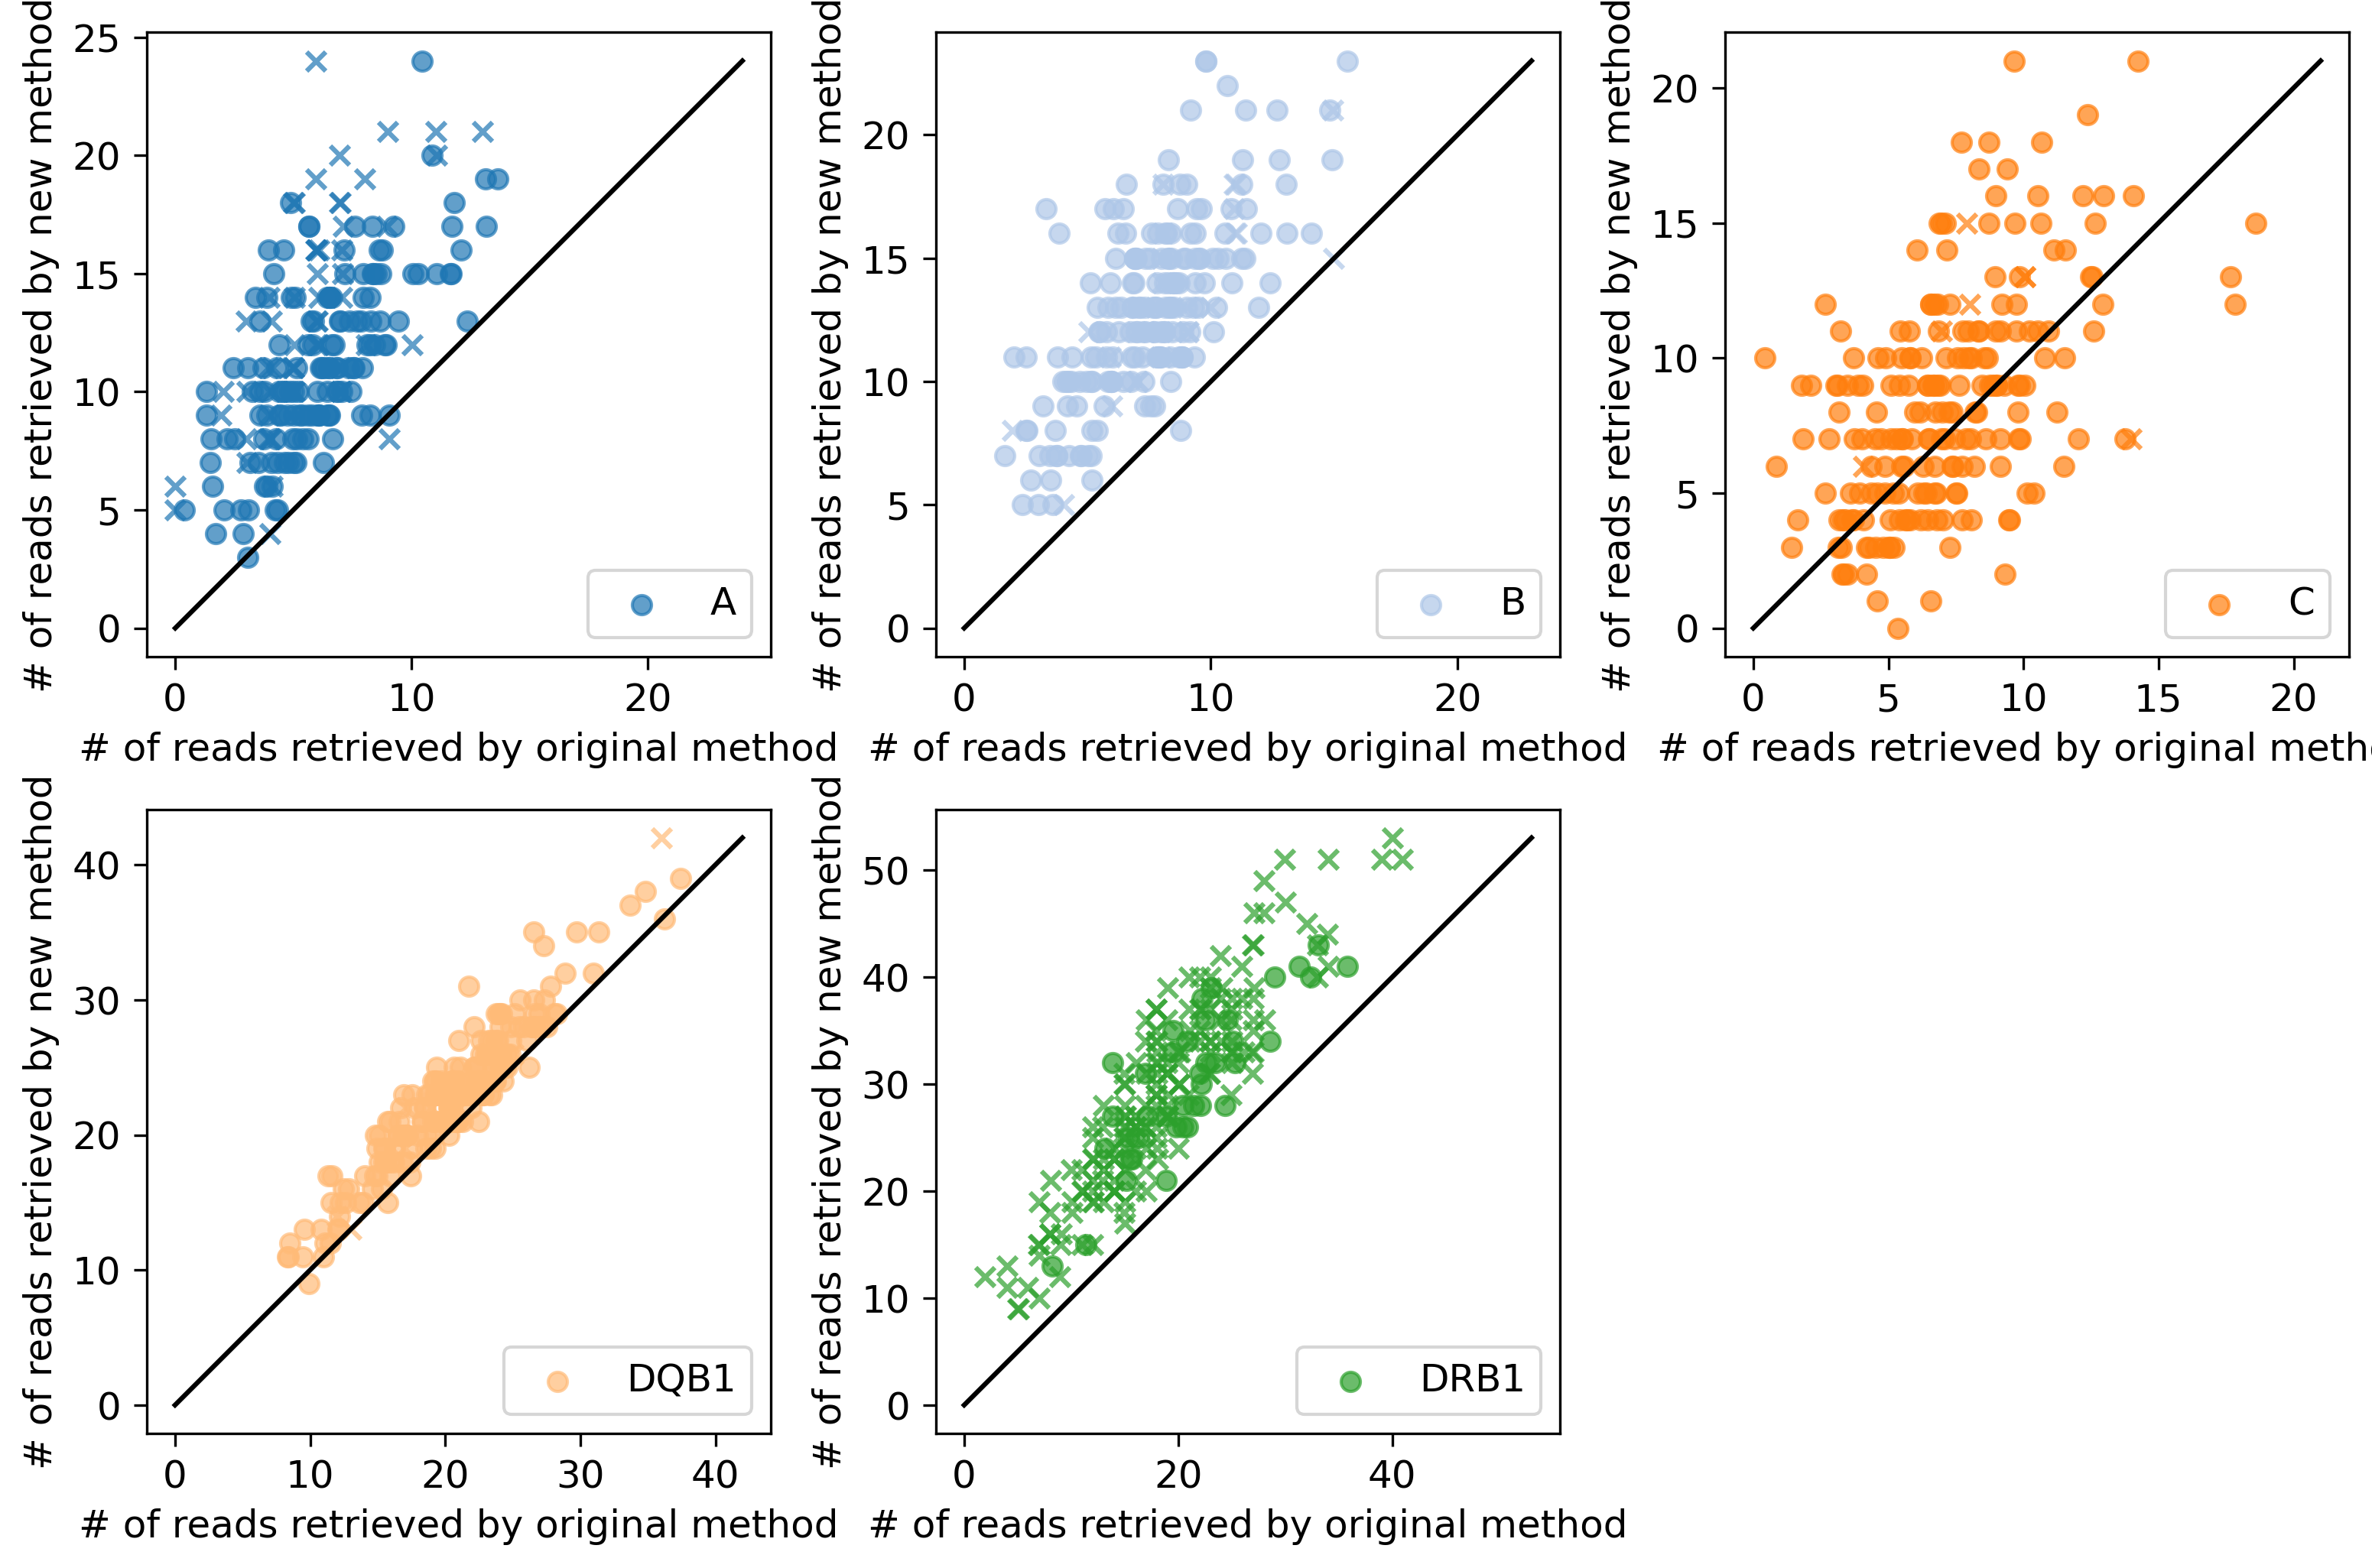

In [76]:
save_fig = True
outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_name = 'sf7.png'

ofile = f'results/hla/imputation/metrics/QUILT_HLA_result_merged_ref/n_reads.tsv'
n_reads = pd.read_csv(ofile, sep = '\t')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10.5, 7), dpi = 300)
axes = axes.flatten()

for i, g in enumerate(HLA_GENES):
    ax = axes[i]
    tmp = n_reads[n_reads['Locus'] == g]
    
    correct = tmp[tmp['Two field match'] == 2]
    jitter = np.random.normal(loc=0, scale=0.5, size=len(correct))
    ax.scatter(correct['qn'] + jitter, correct['n'], marker='o', c=CATEGORY_CMAP_HEX[i], alpha=0.7, label=g)

    incorrect = tmp[tmp['Two field match'] < 2]
    jitter = np.random.normal(loc=0, scale=0.05, size=len(incorrect))
    ax.scatter(incorrect['qn'] + jitter, incorrect['n'], marker='x', c=CATEGORY_CMAP_HEX[i], alpha=0.7)

    n_max = max(correct['n'].max(), correct['qn'].max(), incorrect['n'].max(), incorrect['qn'].max())
    ax.plot([0, n_max], [0, n_max], color='black')

    ax.set_xlabel('# of reads retrieved by original method')
    ax.set_ylabel('# of reads retrieved by new method')
    ax.legend(loc = 'lower right')


fig.delaxes(axes[-1])
plt.tight_layout()

lcwgsus.save_figure(save_fig, outdir, save_name)